# Paws and Prediction
## Overview of the project
0. Import libraries
1. Load and transform data
2. Visualize data
3. Train Class to initialize all training

\\


## Misc
- Loss function: Cross Entropy :https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

- Optimizer? Adam optimizer

\\

## To explore for multi-class classification problem:
1. Fine-tuning more layers (compared to just the final layer, and then incrementally increasing the number of layers fine-tuned).
2. Different learning rates and/or learning rate schedulers for different layers.
3. Benefit of applying data augmentations (flip, small rotations, crops, small size scaling).
4. Effect of fine-tuning or not the batch-norm parameters and updating the estimate of the batch mean and standard deviations on the final performance on the new dataset.

In [2]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torchvision.transforms import RandomApply

from tqdm import tqdm
import time
from sklearn.metrics import classification_report

In [3]:
## for gpu usage, check true
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## 1. Load and transform data

We might want to think about how we transform the data and the splitting
Also about the size (now [3, 384, 384]), will probably require a lot of compute to train? Look up what seems reasonable

""The inference transforms are available at EfficientNet_B4_Weights.IMAGENET1K_V1.transforms and perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[384] using interpolation=InterpolationMode.BICUBIC, followed by a central crop of crop_size=[380]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].""


####ser ut som att man kan addera random augmentations :))

def get_train_transform(IMAGE_SIZE, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    retur

In [4]:
from torch.utils.data import Dataset

class TrDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, y = self.base[idx]
        return self.transformations(x), y



class LoadData:
    def __init__(self):
        self.dataset_trainval = None
        self.test_dataset = None

        self.transform_images()
        self.mult_dataset()

        self.classes, self.class_labels = self.get_classes()

        #self.data_loaders()

    def get_classes(self):
        if self.dataset_trainval is not None:
            dataset = self.dataset_trainval
        else:
            dataset = OxfordIIITPet(root='./data', download=True, split = "trainval")

        class_labels = dataset.classes
        class_labels_dict = {}

        for i, breed in enumerate(class_labels):
            class_labels_dict[i] = breed

        return len(class_labels), class_labels_dict


    def mult_dataset(self):
        """Load the multclass dataset"""

        self.dataset_trainval = OxfordIIITPet(root='./data', download=True, split = "trainval")
        self.test_dataset = OxfordIIITPet(root='./data', transform=self.transform, download=True, split = "test")

        return

    def data_loaders(self, batch_size=16, split_ratio=0.8, labeled_percent = 1):
        """Initialize dataloaders"""

        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size

        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])
        train_dataset = TrDataset(train_dataset, self.transforms_aug)
        val_dataset = TrDataset(val_dataset, self.transform)

        if labeled_percent <1:
            print("true size = " + str(train_size))
            pseudo_train_size = int(labeled_percent *train_size)

            print("labeled train size = " + str(pseudo_train_size))


            pseudo_guess_size =  train_size -pseudo_train_size

            print("unlabeled size = " + str(pseudo_guess_size))

            train_pseudo, guess_pseudo = random_split(train_dataset, [pseudo_train_size, pseudo_guess_size])



            self.trainPseudo_loader =  DataLoader(train_pseudo, batch_size=batch_size, shuffle=True)


            self.guess_loader = DataLoader(guess_pseudo, batch_size=batch_size, shuffle=True)
            self.train_loader = [];

        else:
            self.trainPseudo_loader = [];
            self.guess_loader = [];
            self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #later add number of workers


        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=True)

        return


    def transform_images(self):
        self.transforms_aug = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5), #random flip
                        transforms.RandomApply([transforms.RandomRotation((-15, 15))], p=0.5), #random rotation
                        transforms.RandomApply([transforms.RandomResizedCrop(380, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.5), #random resizing
                        transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5), #random translation
                        transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
                        transforms.CenterCrop(380),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

        self.transform = transforms.Compose([
                        transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
                        transforms.CenterCrop(380),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])
        return




In [5]:
sizes = {
            'b0': (256, 224), 'b1': (256, 240), 'b2': (288, 288), 'b3': (320, 300),
            'b4': (384, 380), 'b5': (489, 456), 'b6': (561, 528), 'b7': (633, 600),
        }

## 2. Visualize Data with Augmentations
Augmentations done:
- random cropping
- random rotation
- random translations
- random flipping
(also scaled to a smaller size for efficiency)

### a) Visualize what the different augmentations do

In [6]:
transform = transforms.Compose([
                transforms.Resize(230, interpolation=InterpolationMode.BICUBIC),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                ])

transforms_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.99), #random flip
    transforms.RandomApply([transforms.RandomRotation((-15, 15))], p=0.99), #random rotation
    transforms.RandomApply([transforms.RandomResizedCrop(380, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.99), #random resizing
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.99), #random translation
    transforms.Resize(384, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
])


In [7]:
dataset = OxfordIIITPet(root='./data', download=True, split = "trainval")

random_indices = np.random.choice(len(dataset), 10)


In [8]:
class_labels = dataset.classes
class_labels_dict = {}

for i, breed in enumerate(class_labels):
    class_labels_dict[i] = breed

print(class_labels_dict)

{0: 'Abyssinian', 1: 'American Bulldog', 2: 'American Pit Bull Terrier', 3: 'Basset Hound', 4: 'Beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'Boxer', 9: 'British Shorthair', 10: 'Chihuahua', 11: 'Egyptian Mau', 12: 'English Cocker Spaniel', 13: 'English Setter', 14: 'German Shorthaired', 15: 'Great Pyrenees', 16: 'Havanese', 17: 'Japanese Chin', 18: 'Keeshond', 19: 'Leonberger', 20: 'Maine Coon', 21: 'Miniature Pinscher', 22: 'Newfoundland', 23: 'Persian', 24: 'Pomeranian', 25: 'Pug', 26: 'Ragdoll', 27: 'Russian Blue', 28: 'Saint Bernard', 29: 'Samoyed', 30: 'Scottish Terrier', 31: 'Shiba Inu', 32: 'Siamese', 33: 'Sphynx', 34: 'Staffordshire Bull Terrier', 35: 'Wheaten Terrier', 36: 'Yorkshire Terrier'}


In [9]:
images = []
images_aug = []
labels = []
random_indices = np.random.choice(len(dataset), 10)
for index in random_indices:
    img, lab = dataset[index]
    images.append(transform(img))
    images_aug.append(transforms_with_augmentation(img))
    labels.append(lab)

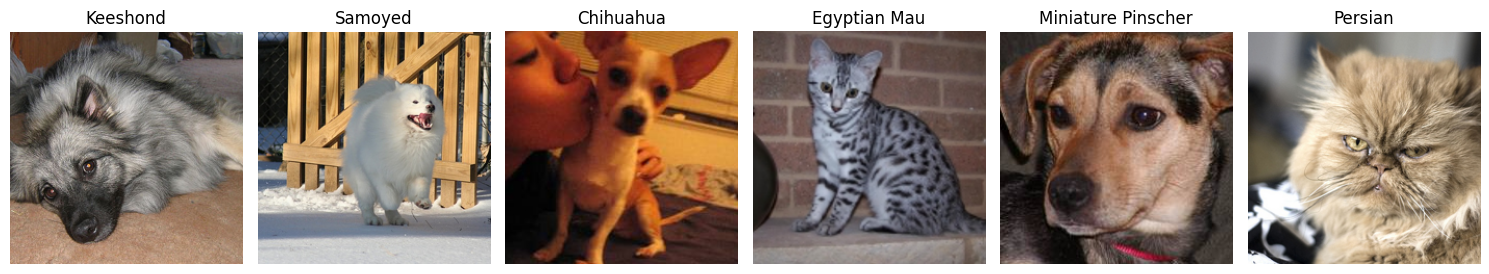

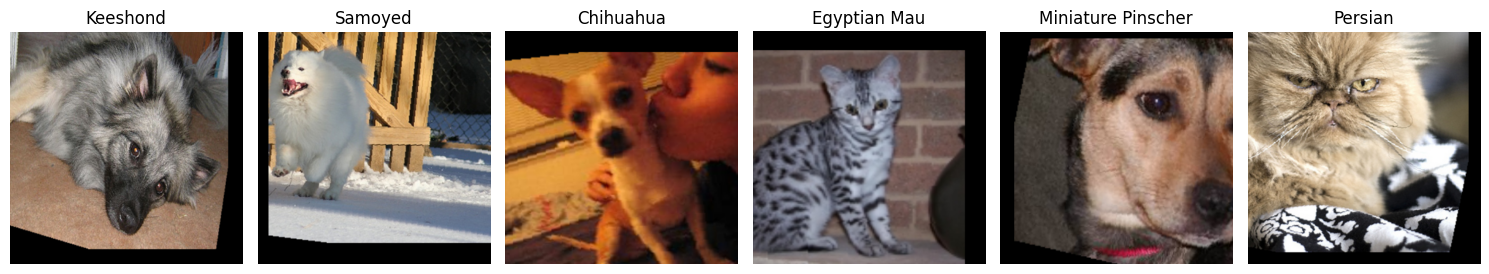

In [10]:
plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f'{class_labels_dict[labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('normal_img.png', dpi = 600)
plt.show()

plt.figure(figsize=(15, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images_aug[i].permute(1, 2, 0))
    plt.title(f'{class_labels_dict[labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('aug_img.png', dpi = 600)
plt.show()

### b) Visualize that the image will have different augmentations each time

In [11]:

transforms_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), #random flip
    transforms.RandomApply([transforms.RandomRotation((-30, 30))], p=0.5), #random rotation
    transforms.RandomApply([transforms.RandomResizedCrop(230, scale=(0.5, 1.0), ratio=(0.5, 1.5))], p=0.5), #random resizing
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5), #random translation
    transforms.Resize(230, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
dataset = OxfordIIITPet(root='./data',download=True, split = "trainval")

from torch.utils.data import Subset
first_image_idx = 0
subset = Subset(dataset, [first_image_idx])
subset = TrDataset(subset, transforms_with_augmentation)
imgs_loader = DataLoader(subset, batch_size=1, shuffle=True)

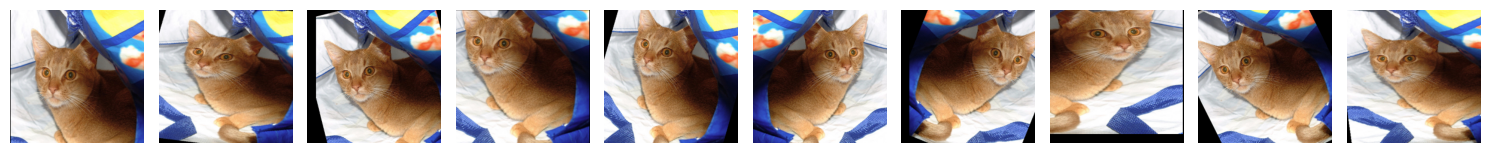

In [13]:
import matplotlib.pyplot as plt

# Assuming 'imgs' is a DataLoader object containing image tensors
plt.figure(figsize=(15, 15))
for i in range(10):
  for img, lab in imgs_loader:
    plt.subplot(1, 10, i + 1)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()


## 3. Load Model Class

In [16]:
class Model(nn.Module):
    def __init__(self, train, num_classes):
        super(Model, self).__init__()
        self.train = train
        self.model = models.efficientnet_b4(weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1)

        #self.model = models.efficientnet_b7(weights = models.EfficientNet_B7_Weights.IMAGENET1K_V1)

        for param in self.model.parameters():
            param.requires_grad = False

        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_features, num_classes, bias=True) #do we want to have a bias term?

        """
        self.model.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            #nn.Linear(num_features, 512),
            #nn.ReLU(inplace=True),
            #nn.Linear(512, 256),
            #nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
        """

    def unfreeze_bn_layers(self, model):
        def find_bn_layers(model):
            bn_layers = []
            for name, child in model.named_children():
                if isinstance(child, nn.BatchNorm2d):
                    for param in child.parameters():
                        param.requires_grad = True
                        bn_layers.append(param)
                else:
                    bn_layers.extend(find_bn_layers(child))
            return bn_layers

        bn_layers = find_bn_layers(self.model)
        bn_lr = self.train.lr
        self.train.optimizer.add_param_group({'params': bn_layers, 'lr': bn_lr})
        return


    def unfreeze_blocks(self):
        """Unfreezes the next layers in a predefined order by self.layers_to_finetune"""

        if self.train.lvl_of_unfrozen_layers >= len(self.train.layers_to_finetune):
            return

        new_params = []

        for name, param in self.train.layers_to_finetune[self.train.lvl_of_unfrozen_layers].named_parameters():
            if param.requires_grad == False:
                param.requires_grad = True
                new_params.append(param)

        self.train.optimizer.add_param_group({'params': new_params, 'lr': self.train.lr_per_layer[self.train.lvl_of_unfrozen_layers]})
        self.train.lvl_of_unfrozen_layers += 1
        return


    def forward(self, x):
        return self.model(x)


## 4. Train Class to initialize all training

In [17]:
#todo - add training and validation accuracy
#different learning rate?

class Train:
    def __init__(self, lr: float, bs: int, epochs: int, split_ratio: float, model, unfreeze_interval, _LoadData, change_of_learning_rate, reduce_learning_rate, training_mode=None, labeled_percent = 1):
        self.lr = lr
        self.batch_size = bs
        self.split_ratio = split_ratio
        self.epochs = epochs

        self.labeled_percent = labeled_percent

        self.data = _LoadData #kom på snyggare variablenamn
        self.data.data_loaders(self.batch_size, self.split_ratio,self.labeled_percent)

        self.num_classes = self.data.classes
        self.class_labels = self.data.class_labels

        self.color1 = '#FF6347'
        self.color2 = '#01A4B4'

        self.train_loader = self.data.train_loader
        self.val_loader = self.data.val_loader
        self.test_loader = self.data.test_loader
        self.train_pseudo_loader = self.data.trainPseudo_loader
        self.guess_loader = self.data.guess_loader

        self.model_class = Model(self, self.num_classes)
        self.model = self.model_class.model

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print('Using gpu: %s ' % torch.cuda.is_available())

        self.layers_to_finetune = [self.model.classifier, self.model.features[8],
                                   self.model.features[7][1].block, self.model.features[7][0].block,
                                   self.model.features[6][7].block, self.model.features[6][6].block,
                                   ] #Definierar vilka och i vilken ordning som moduler unfreeze
                                    #self.model.features[6][5].block, self.model.features[6][4].block
        self.lr_per_layer = [self.lr, self.lr/10, self.lr/100, self.lr/100, self.lr/100, self.lr/100, self.lr/1000, self.lr/1000] #Definierar vilken lr varje modul ska ha
        self.lvl_of_unfrozen_layers = 1
        self.unfreeze_interval = unfreeze_interval
        self.change_of_learning_rate = change_of_learning_rate
        self.reduce_learning_rate = reduce_learning_rate

        self.training_mode = training_mode

        self.val_loss = []
        self.train_loss = []

        self.test_y = None
        self.pred_y = None

        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam([{'params': param, 'lr': self.lr_per_layer[0]}
            for param in self.layers_to_finetune[0].parameters()])

        if self.training_mode == 1 or self.training_mode == 2:
            self.model_class.unfreeze_bn_layers(self.model)

        self.patience = 10

    def calculate_loss(self, dataloader):
        """Calculate validation loss"""

        self.model.eval()  # Set the model to evaluation mode
        epochloss = 0.0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                epochloss += loss.item()

        avg_loss = epochloss / len(dataloader)
        self.model.train()
        return avg_loss


    def reduce_lr(self):
          """ Reduces the lr by dividing it by 'change' for every layer"""

          for i, param_group in enumerate(self.optimizer.param_groups):
              param_group['lr'] = param_group['lr'] /self.change_of_learning_rate
          self.lr_per_layer = [lr / self.change_of_learning_rate for lr in self.lr_per_layer]


    def train(self):
        """Train the network"""
        self.model.train() #Bör inte störa "freezed" layers
        self.model.to(self.device)

        avg_epoch_loss = self.calculate_loss(self.train_loader)
        avg_val_loss = self.calculate_loss(self.val_loader)

        self.train_loss.append(avg_epoch_loss)
        self.val_loss.append(avg_val_loss)

        best_val_loss = np.Inf
        patience = 0
        start_time = time.time()  # Start timing

        for epoch in range(self.epochs):
            for images, labels in tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.epochs}', unit='batch'):
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()

            avg_epoch_loss = self.calculate_loss(self.train_loader)
            avg_val_loss = self.calculate_loss(self.val_loader)

            self.train_loss.append(avg_epoch_loss)
            self.val_loss.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                patience = 0
                best_val_loss = avg_val_loss
            else:
                patience += 1
                if patience == self.patience:
                    print(f'Epoch {epoch+1}, Training Loss: {avg_epoch_loss:.4f} \t Validation Loss: {avg_val_loss:.4f}. Early stopping triggered')
                    break

            if self.training_mode == 2 or self.training_mode == 3:
                if (epoch+1) % self.unfreeze_interval == 0 and epoch > 1:
                    self.model_class.unfreeze_blocks()

            print(f'Epoch {epoch+1}, Training Loss: {avg_epoch_loss:.6f} \t Validation Loss: {avg_val_loss:.6f}')

            if (epoch+1) % self.reduce_learning_rate == 0 and epoch > 1:
                self.reduce_lr()

            if (epoch+1) % 4 == 0:
                self.evaluate(self.val_loader)
                self.model.train()


        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Training finished in {elapsed_time:.2f} seconds')

        return

    def plot_loss_curves(self):
        """plot the loss on the training and validation set during training"""
        epochs = np.arange(0, len(self.train_loss))

        plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
        plt.plot(epochs, self.train_loss, color=self.color1, linewidth=2.5, label='Training Loss')
        plt.plot(epochs, self.val_loss, color=self.color2, linewidth=2.5, label='Validation Loss')
        plt.xlabel('Epoch')  # Adjust the fontsize as needed
        plt.ylabel('Loss')    # Adjust the fontsize as needed
        plt.legend(loc='upper right')
        plt.tight_layout()

        plt.savefig(f'acc{self.accuracy:.4f}_lr{self.lr}_epochs{self.epochs}_unfreezeinterval{self.unfreeze_interval}_reducelrinterval{self.reduce_learning_rate}_trainingmode{self.training_mode}.png', dpi=600)
        plt.show()


    def evaluate(self, dataloader):
        """Evaluate the model on the test dataset and return accuracy"""

        self.model.eval()  # Set the model to evaluation mode
        self.model.to(self.device)

        self.test_y = []
        self.pred_y = []

        with torch.no_grad():  # Disable gradient calculation during evaluation
            for images, labels in dataloader:
                self.test_y.extend(labels.cpu().numpy().flatten())
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)

                _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
                self.pred_y.extend(predicted.cpu().numpy().flatten())

        self.test_y = np.array(self.test_y)
        self.pred_y = np.array(self.pred_y)
        self.accuracy = np.mean(self.test_y == self.pred_y)

        if dataloader == self.test_loader:
            print(f'Accuracy of Test: {self.accuracy:.4f}')
        if dataloader == self.val_loader:
            print(f'Accuracy of Val: {self.accuracy:.4f}')
        return self.accuracy

    def classification_report(self):
        if self.test_y is None or self.pred_y is None:
            self.evaluate(self.test_loader)

        test_class_names = [self.class_labels[label] for label in self.test_y]
        pred_class_names = [self.class_labels[label] for label in self.pred_y]

        class_report = classification_report(test_class_names, pred_class_names)
        print(class_report)
        return class_report






    def pseudo_labels(self, mode = 0):


        saveLr = self.lr
        self.model.train() #Bör inte störa "freezed" layers
        self.model.to(self.device)
        patience = 0
        start_time = time.time()  # Start timing

        print(str(len(self.train_pseudo_loader.dataset)))


        # Train the labeled data
        for epoch in range(self.epochs):
            #epoch_loss = 0.0  # Initialize epoch loss

            for images, labels in tqdm(self.train_pseudo_loader, desc=f'Epoch {epoch+1}/{self.epochs}', unit='batch'):
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()

            if self.training_mode == 2 or self.training_mode == 3:
                if (epoch+1) % self.unfreeze_interval == 0 and epoch > 1:
                    self.model_class.unfreeze_blocks()


            if (epoch+1) % 8 == 0:
                self.reduce_lr()
                #self.plot_loss_curves()
                #self.evaluate()
                self.model.train()


        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Training finished in {elapsed_time:.2f} seconds')

        modified_dataset = []


        # Add train_pseudo_loader to train_loader
        for images, labels in self.train_pseudo_loader:
          images, labels = images.to("cpu"), labels.to("cpu")
          for image_idx, image in enumerate(images):
            for label_idx, label in enumerate(labels):
                if label_idx == image_idx:
                  modified_dataset.append((image, label.item()))
                  break



        self.model.eval()  # Set the model to evaluation mode
        self.model.to(self.device)
        correct = 0
        total = 0

        self.test_y = []
        self.pred_y = []
        j = 0
        # Predict labels and add those to train_loader
        with torch.no_grad():
            for images, labels in self.guess_loader:
                self.test_y.extend(labels.cpu().numpy().flatten())
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)

                _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
                self.pred_y.extend(predicted.cpu().numpy().flatten())
                labels_cpu = labels.cpu()  # Move to CPU
                labels_np = labels_cpu.numpy()


                images, labels = images.to("cpu"), labels.to("cpu")


                for image in images:
                  modified_dataset.append((image, self.pred_y[j]))
                  j += 1

        self.test_y = np.array(self.test_y)
        self.pred_y = np.array(self.pred_y)
        accuracy = np.mean(self.test_y == self.pred_y)



        print(f'Predicted Label Accuracy: {accuracy:.4f}')





        print(str(len(modified_dataset)))



        self.train_loader = DataLoader(modified_dataset, batch_size=self.batch_size, shuffle=True)
        if mode != 0:
            if mode == 1:
                self.model_class = Model(self, self.num_classes)
                self.model = self.model_class.model

            else:
                for param in self.model.parameters():
                    param.requires_grad = False

            self.lvl_of_unfrozen_layers = 1

            self.loss_func = nn.CrossEntropyLoss()
            self.optimizer = optim.Adam([{'params': param, 'lr': self.lr_per_layer[0]}
                for param in self.layers_to_finetune[0].parameters()])

            if self.training_mode == 1 or self.training_mode == 2:
                self.model_class.unfreeze_bn_layers(self.model)


        return


## Pseudo

### 50%

In [13]:

_LoadData = LoadData()
lr = 5e-3
unfreeze_interval = 4 #eller 2
reduce_learning_rate = 6
training_mode = 1


train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode, labeled_percent=0.5)

train.pseudo_labels()
train.classification_report()

true size = 2944
labeled train size = 1472
unlabeled size = 1472
Using gpu: True 
1472


Epoch 24/24: 100%|██████████| 92/92 [00:42<00:00,  2.19batch/s]


Training finished in 1013.12 seconds
Predicted Label Accuracy: 0.9552
2944
                            precision    recall  f1-score   support

                Abyssinian       0.93      0.97      0.95        39
          American Bulldog       0.81      0.88      0.84        33
 American Pit Bull Terrier       0.88      0.97      0.93        38
              Basset Hound       1.00      0.97      0.99        38
                    Beagle       1.00      1.00      1.00        40
                    Bengal       0.90      0.88      0.89        41
                    Birman       0.84      0.97      0.90        37
                    Bombay       1.00      1.00      1.00        43
                     Boxer       0.95      0.95      0.95        40
         British Shorthair       0.98      0.95      0.96        42
                 Chihuahua       0.85      0.97      0.91        40
              Egyptian Mau       0.91      0.93      0.92        42
    English Cocker Spaniel       0.97   

'                            precision    recall  f1-score   support\n\n                Abyssinian       0.93      0.97      0.95        39\n          American Bulldog       0.81      0.88      0.84        33\n American Pit Bull Terrier       0.88      0.97      0.93        38\n              Basset Hound       1.00      0.97      0.99        38\n                    Beagle       1.00      1.00      1.00        40\n                    Bengal       0.90      0.88      0.89        41\n                    Birman       0.84      0.97      0.90        37\n                    Bombay       1.00      1.00      1.00        43\n                     Boxer       0.95      0.95      0.95        40\n         British Shorthair       0.98      0.95      0.96        42\n                 Chihuahua       0.85      0.97      0.91        40\n              Egyptian Mau       0.91      0.93      0.92        42\n    English Cocker Spaniel       0.97      0.97      0.97        33\n            English Setter     

Epoch 1/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 1, Training Loss: 0.032265 	 Validation Loss: 0.156898


Epoch 2/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 2, Training Loss: 0.030789 	 Validation Loss: 0.156194


Epoch 3/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 3, Training Loss: 0.031541 	 Validation Loss: 0.152027


Epoch 4/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 4, Training Loss: 0.030339 	 Validation Loss: 0.148554
Accuracy of Val: 0.9524


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 5, Training Loss: 0.033060 	 Validation Loss: 0.160832


Epoch 6/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 6, Training Loss: 0.030968 	 Validation Loss: 0.150617


Epoch 7/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 7, Training Loss: 0.029901 	 Validation Loss: 0.154102


Epoch 8/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 8, Training Loss: 0.028775 	 Validation Loss: 0.151889
Accuracy of Val: 0.9497


Epoch 9/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 9, Training Loss: 0.029888 	 Validation Loss: 0.152765


Epoch 10/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 10, Training Loss: 0.030193 	 Validation Loss: 0.151276


Epoch 11/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 11, Training Loss: 0.029320 	 Validation Loss: 0.155224


Epoch 12/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 12, Training Loss: 0.030398 	 Validation Loss: 0.153453
Accuracy of Val: 0.9524


Epoch 13/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 13, Training Loss: 0.031230 	 Validation Loss: 0.157964


Epoch 14/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 14, Training Loss: 0.0298 	 Validation Loss: 0.1605. Early stopping triggered
Training finished in 1811.58 seconds
Accuracy of Val: 0.9497
Accuracy of Test: 0.9321


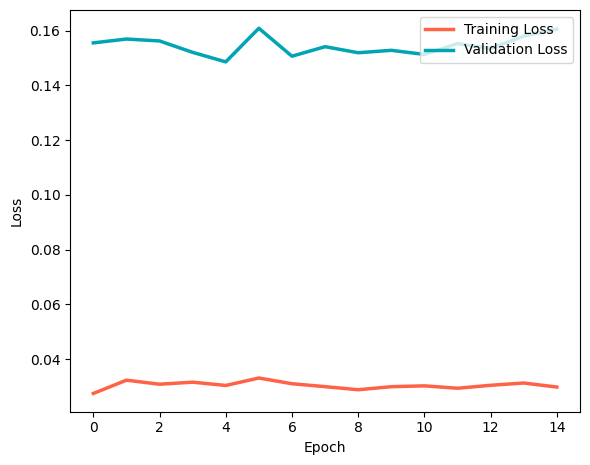

                            precision    recall  f1-score   support

                Abyssinian       0.96      0.93      0.94        98
          American Bulldog       0.77      0.91      0.83       100
 American Pit Bull Terrier       0.81      0.61      0.70       100
              Basset Hound       0.98      0.96      0.97       100
                    Beagle       0.96      0.95      0.95       100
                    Bengal       0.77      0.99      0.86       100
                    Birman       0.77      0.90      0.83       100
                    Bombay       0.85      0.99      0.92        88
                     Boxer       0.93      0.94      0.93        99
         British Shorthair       0.99      0.82      0.90       100
                 Chihuahua       0.94      0.93      0.93       100
              Egyptian Mau       0.93      0.86      0.89        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      1.00

'                            precision    recall  f1-score   support\n\n                Abyssinian       0.96      0.93      0.94        98\n          American Bulldog       0.77      0.91      0.83       100\n American Pit Bull Terrier       0.81      0.61      0.70       100\n              Basset Hound       0.98      0.96      0.97       100\n                    Beagle       0.96      0.95      0.95       100\n                    Bengal       0.77      0.99      0.86       100\n                    Birman       0.77      0.90      0.83       100\n                    Bombay       0.85      0.99      0.92        88\n                     Boxer       0.93      0.94      0.93        99\n         British Shorthair       0.99      0.82      0.90       100\n                 Chihuahua       0.94      0.93      0.93       100\n              Egyptian Mau       0.93      0.86      0.89        97\n    English Cocker Spaniel       0.99      1.00      1.00       100\n            English Setter     

In [14]:
train.train()
train.evaluate(train.val_loader)
train.evaluate(train.test_loader)
train.plot_loss_curves()
train.classification_report()

### 10%

In [11]:

_LoadData = LoadData()
lr = 5e-3
unfreeze_interval = 4 #eller 2
reduce_learning_rate = 6
training_mode = 1


train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode, labeled_percent=0.1)

train.pseudo_labels(mode =2)
train.classification_report()

true size = 2944
labeled train size = 294
unlabeled size = 2650
Using gpu: True 
294


Epoch 24/24: 100%|██████████| 19/19 [00:08<00:00,  2.23batch/s]


Training finished in 209.38 seconds
Predicted Label Accuracy: 0.8943
2944
                            precision    recall  f1-score   support

                Abyssinian       0.72      0.86      0.78        70
          American Bulldog       0.72      0.68      0.70        74
 American Pit Bull Terrier       0.93      0.81      0.87        69
              Basset Hound       0.96      0.92      0.94        79
                    Beagle       0.95      0.92      0.93        76
                    Bengal       0.66      0.53      0.58        72
                    Birman       0.82      0.87      0.84        71
                    Bombay       0.96      0.97      0.96        68
                     Boxer       0.82      0.90      0.86        69
         British Shorthair       0.86      0.76      0.81        72
                 Chihuahua       0.89      0.96      0.92        74
              Egyptian Mau       0.75      0.81      0.78        68
    English Cocker Spaniel       0.98    

'                            precision    recall  f1-score   support\n\n                Abyssinian       0.72      0.86      0.78        70\n          American Bulldog       0.72      0.68      0.70        74\n American Pit Bull Terrier       0.93      0.81      0.87        69\n              Basset Hound       0.96      0.92      0.94        79\n                    Beagle       0.95      0.92      0.93        76\n                    Bengal       0.66      0.53      0.58        72\n                    Birman       0.82      0.87      0.84        71\n                    Bombay       0.96      0.97      0.96        68\n                     Boxer       0.82      0.90      0.86        69\n         British Shorthair       0.86      0.76      0.81        72\n                 Chihuahua       0.89      0.96      0.92        74\n              Egyptian Mau       0.75      0.81      0.78        68\n    English Cocker Spaniel       0.98      0.69      0.81        80\n            English Setter     

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 1, Training Loss: 0.094448 	 Validation Loss: 0.270140


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 2, Training Loss: 0.053990 	 Validation Loss: 0.285053


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 3, Training Loss: 0.038150 	 Validation Loss: 0.287714


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 4, Training Loss: 0.023823 	 Validation Loss: 0.331913
Accuracy of Val: 0.9062


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 5, Training Loss: 0.019551 	 Validation Loss: 0.272229


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 6, Training Loss: 0.014214 	 Validation Loss: 0.306276


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 7, Training Loss: 0.010887 	 Validation Loss: 0.278772


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 8, Training Loss: 0.009442 	 Validation Loss: 0.283520
Accuracy of Val: 0.9253


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 9, Training Loss: 0.008624 	 Validation Loss: 0.283433


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 10, Training Loss: 0.007872 	 Validation Loss: 0.288138


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 11, Training Loss: 0.0069 	 Validation Loss: 0.2825. Early stopping triggered
Training finished in 1443.53 seconds
Accuracy of Val: 0.9307
Accuracy of Test: 0.8932


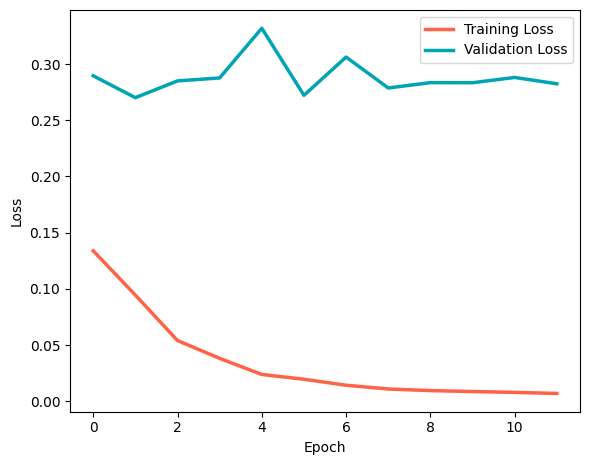

                            precision    recall  f1-score   support

                Abyssinian       0.75      0.79      0.77        98
          American Bulldog       0.57      0.68      0.62       100
 American Pit Bull Terrier       0.78      0.25      0.38       100
              Basset Hound       0.97      0.97      0.97       100
                    Beagle       0.96      0.96      0.96       100
                    Bengal       0.73      0.90      0.80       100
                    Birman       0.73      0.95      0.82       100
                    Bombay       0.88      0.95      0.91        88
                     Boxer       0.78      0.93      0.85        99
         British Shorthair       0.90      0.71      0.79       100
                 Chihuahua       0.95      0.93      0.94       100
              Egyptian Mau       0.82      0.89      0.85        97
    English Cocker Spaniel       1.00      0.87      0.93       100
            English Setter       0.93      1.00

'                            precision    recall  f1-score   support\n\n                Abyssinian       0.75      0.79      0.77        98\n          American Bulldog       0.57      0.68      0.62       100\n American Pit Bull Terrier       0.78      0.25      0.38       100\n              Basset Hound       0.97      0.97      0.97       100\n                    Beagle       0.96      0.96      0.96       100\n                    Bengal       0.73      0.90      0.80       100\n                    Birman       0.73      0.95      0.82       100\n                    Bombay       0.88      0.95      0.91        88\n                     Boxer       0.78      0.93      0.85        99\n         British Shorthair       0.90      0.71      0.79       100\n                 Chihuahua       0.95      0.93      0.94       100\n              Egyptian Mau       0.82      0.89      0.85        97\n    English Cocker Spaniel       1.00      0.87      0.93       100\n            English Setter     

In [12]:
train.train()
train.evaluate(train.val_loader)
train.evaluate(train.test_loader)
train.plot_loss_curves()
train.classification_report()

### 1%

In [18]:
_LoadData = LoadData()
lr = 5e-2
unfreeze_interval = 4 #eller 2
reduce_learning_rate = 6
training_mode = 1

train = Train(lr=lr, bs=16, epochs=16, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode, labeled_percent=0.01)
train.pseudo_labels()


train.classification_report()

true size = 2944
labeled train size = 29
unlabeled size = 2915
Using gpu: True 
29


Epoch 16/16: 100%|██████████| 2/2 [00:00<00:00,  2.48batch/s]


Training finished in 14.26 seconds
Predicted Label Accuracy: 0.3743
2944
                            precision    recall  f1-score   support

                Abyssinian       0.59      0.39      0.47        83
          American Bulldog       0.00      0.00      0.00        85
 American Pit Bull Terrier       0.39      0.54      0.45        83
              Basset Hound       0.00      0.00      0.00        82
                    Beagle       0.55      0.64      0.59        81
                    Bengal       0.00      0.00      0.00        85
                    Birman       0.00      0.00      0.00        82
                    Bombay       0.60      0.74      0.66        69
                     Boxer       0.30      0.94      0.45        80
         British Shorthair       0.57      0.90      0.70        81
                 Chihuahua       0.41      0.51      0.45        68
              Egyptian Mau       0.00      0.00      0.00        71
    English Cocker Spaniel       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                            precision    recall  f1-score   support\n\n                Abyssinian       0.59      0.39      0.47        83\n          American Bulldog       0.00      0.00      0.00        85\n American Pit Bull Terrier       0.39      0.54      0.45        83\n              Basset Hound       0.00      0.00      0.00        82\n                    Beagle       0.55      0.64      0.59        81\n                    Bengal       0.00      0.00      0.00        85\n                    Birman       0.00      0.00      0.00        82\n                    Bombay       0.60      0.74      0.66        69\n                     Boxer       0.30      0.94      0.45        80\n         British Shorthair       0.57      0.90      0.70        81\n                 Chihuahua       0.41      0.51      0.45        68\n              Egyptian Mau       0.00      0.00      0.00        71\n    English Cocker Spaniel       0.00      0.00      0.00        76\n            English Setter     

Epoch 1/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 1, Training Loss: 0.373220 	 Validation Loss: 8.671089


Epoch 2/16: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 2, Training Loss: 0.361863 	 Validation Loss: 8.705374


Epoch 3/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 3, Training Loss: 0.352349 	 Validation Loss: 8.839728


Epoch 4/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 4, Training Loss: 0.320717 	 Validation Loss: 8.850252
Accuracy of Val: 0.4008


Epoch 5/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 5, Training Loss: 0.327146 	 Validation Loss: 8.782632


Epoch 6/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 6, Training Loss: 0.299038 	 Validation Loss: 8.422894


Epoch 7/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 7, Training Loss: 0.288723 	 Validation Loss: 8.987102


Epoch 8/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 8, Training Loss: 0.292169 	 Validation Loss: 8.939996
Accuracy of Val: 0.4076


Epoch 9/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 9, Training Loss: 0.296941 	 Validation Loss: 9.021053


Epoch 10/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 10, Training Loss: 0.294386 	 Validation Loss: 8.991420


Epoch 11/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 11, Training Loss: 0.281944 	 Validation Loss: 8.895563


Epoch 12/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 12, Training Loss: 0.296230 	 Validation Loss: 8.608631
Accuracy of Val: 0.4090


Epoch 13/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 13, Training Loss: 0.283916 	 Validation Loss: 9.009799


Epoch 14/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 14, Training Loss: 0.281542 	 Validation Loss: 9.252446


Epoch 15/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 15, Training Loss: 0.289441 	 Validation Loss: 8.874734


Epoch 16/16: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 16, Training Loss: 0.2925 	 Validation Loss: 8.7460. Early stopping triggered
Training finished in 2056.69 seconds
Accuracy of Val: 0.4090
Accuracy of Test: 0.4023


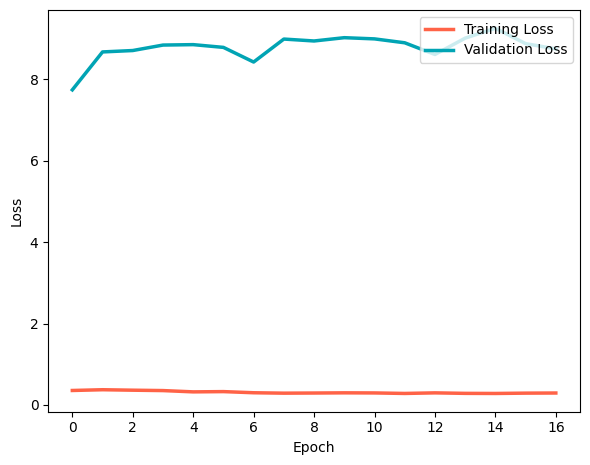

                            precision    recall  f1-score   support

                Abyssinian       0.65      0.37      0.47        98
          American Bulldog       0.00      0.00      0.00       100
 American Pit Bull Terrier       0.32      0.31      0.32       100
              Basset Hound       0.00      0.00      0.00       100
                    Beagle       0.70      0.91      0.79       100
                    Bengal       0.00      0.00      0.00       100
                    Birman       0.00      0.00      0.00       100
                    Bombay       0.70      0.91      0.79        88
                     Boxer       0.30      0.96      0.46        99
         British Shorthair       0.51      0.81      0.62       100
                 Chihuahua       0.46      0.75      0.57       100
              Egyptian Mau       0.00      0.00      0.00        97
    English Cocker Spaniel       0.00      0.00      0.00       100
            English Setter       0.19      1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                            precision    recall  f1-score   support\n\n                Abyssinian       0.65      0.37      0.47        98\n          American Bulldog       0.00      0.00      0.00       100\n American Pit Bull Terrier       0.32      0.31      0.32       100\n              Basset Hound       0.00      0.00      0.00       100\n                    Beagle       0.70      0.91      0.79       100\n                    Bengal       0.00      0.00      0.00       100\n                    Birman       0.00      0.00      0.00       100\n                    Bombay       0.70      0.91      0.79        88\n                     Boxer       0.30      0.96      0.46        99\n         British Shorthair       0.51      0.81      0.62       100\n                 Chihuahua       0.46      0.75      0.57       100\n              Egyptian Mau       0.00      0.00      0.00        97\n    English Cocker Spaniel       0.00      0.00      0.00       100\n            English Setter     

In [19]:
train.train()
train.evaluate(train.val_loader)
train.evaluate(train.test_loader)
train.plot_loss_curves()
train.classification_report()

## 5. Train the networks

In [ ]:
_LoadData = LoadData()

RUN 0
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.152533 	 Validation Loss: 0.190956


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.075682 	 Validation Loss: 0.153262


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.048927 	 Validation Loss: 0.125656


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.043848 	 Validation Loss: 0.139977
Accuracy of Val: 0.9524
Accuracy of Test: 0.9289
Training finished in 696.93 seconds
Accuracy of Val: 0.9524
Accuracy of Test: 0.9289


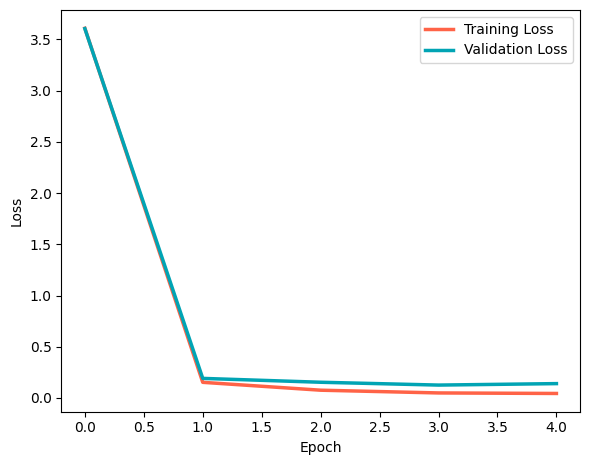

                            precision    recall  f1-score   support

                Abyssinian       0.95      0.89      0.92        98
          American Bulldog       0.84      0.87      0.85       100
 American Pit Bull Terrier       0.98      0.44      0.61       100
              Basset Hound       1.00      0.91      0.95       100
                    Beagle       0.91      0.99      0.95       100
                    Bengal       0.90      0.77      0.83       100
                    Birman       0.84      0.75      0.79       100
                    Bombay       0.87      0.99      0.93        88
                     Boxer       0.84      0.96      0.90        99
         British Shorthair       0.95      0.86      0.90       100
                 Chihuahua       0.90      0.97      0.93       100
              Egyptian Mau       0.69      0.98      0.81        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       0.99      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.141320 	 Validation Loss: 0.214868


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.062242 	 Validation Loss: 0.157925


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.047740 	 Validation Loss: 0.130174


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.035018 	 Validation Loss: 0.131122
Accuracy of Val: 0.9511
Accuracy of Test: 0.9349


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.024394 	 Validation Loss: 0.158188


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.024585 	 Validation Loss: 0.168137


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.016112 	 Validation Loss: 0.141296


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.011758 	 Validation Loss: 0.125029
Accuracy of Val: 0.9592
Accuracy of Test: 0.9411


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.012535 	 Validation Loss: 0.127714


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.008460 	 Validation Loss: 0.127120


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.008527 	 Validation Loss: 0.129213


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.008300 	 Validation Loss: 0.124175
Accuracy of Val: 0.9592
Accuracy of Test: 0.9376


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.009693 	 Validation Loss: 0.124643


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.009290 	 Validation Loss: 0.122010


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.008764 	 Validation Loss: 0.129121


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.006662 	 Validation Loss: 0.125170
Accuracy of Val: 0.9538
Accuracy of Test: 0.9430


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.008764 	 Validation Loss: 0.125685


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.010361 	 Validation Loss: 0.124332


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.006295 	 Validation Loss: 0.131886


Epoch 20/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 20, Training Loss: 0.007562 	 Validation Loss: 0.126456
Accuracy of Val: 0.9538
Accuracy of Test: 0.9387


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.007895 	 Validation Loss: 0.120204


Epoch 22/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 22, Training Loss: 0.007875 	 Validation Loss: 0.121492


Epoch 23/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 23, Training Loss: 0.008669 	 Validation Loss: 0.125205


Epoch 24/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 24, Training Loss: 0.008479 	 Validation Loss: 0.121765
Accuracy of Val: 0.9592
Accuracy of Test: 0.9398
Training finished in 4177.48 seconds
Accuracy of Val: 0.9592
Accuracy of Test: 0.9398


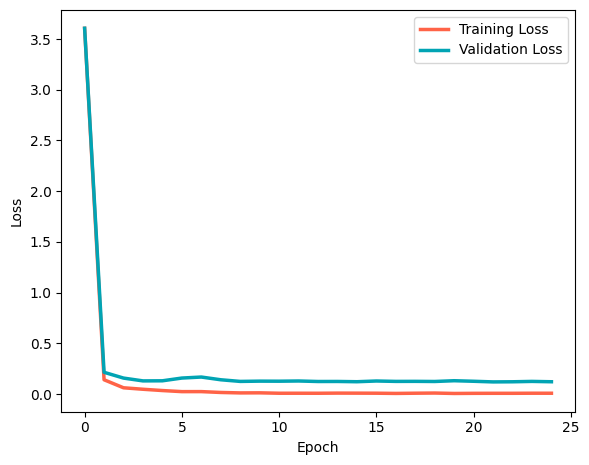

                            precision    recall  f1-score   support

                Abyssinian       0.96      0.94      0.95        98
          American Bulldog       0.85      0.93      0.89       100
 American Pit Bull Terrier       0.91      0.61      0.73       100
              Basset Hound       0.94      0.95      0.95       100
                    Beagle       0.95      0.92      0.93       100
                    Bengal       0.77      0.95      0.85       100
                    Birman       0.79      0.89      0.84       100
                    Bombay       0.87      0.99      0.93        88
                     Boxer       0.91      0.93      0.92        99
         British Shorthair       0.98      0.85      0.91       100
                 Chihuahua       0.94      0.96      0.95       100
              Egyptian Mau       0.90      0.88      0.89        97
    English Cocker Spaniel       0.99      0.99      0.99       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.137529 	 Validation Loss: 0.219362


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.075823 	 Validation Loss: 0.184747


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.064339 	 Validation Loss: 0.200287


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.036439 	 Validation Loss: 0.184558
Accuracy of Val: 0.9321
Accuracy of Test: 0.9286
Training finished in 694.10 seconds
Accuracy of Val: 0.9321
Accuracy of Test: 0.9286


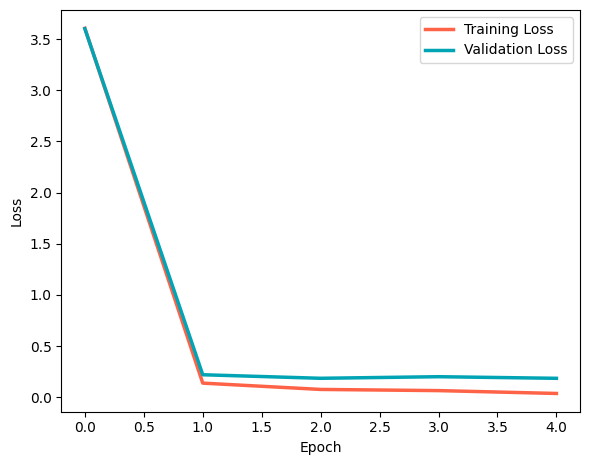

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.91      0.92        98
          American Bulldog       0.86      0.85      0.85       100
 American Pit Bull Terrier       0.80      0.68      0.74       100
              Basset Hound       1.00      0.96      0.98       100
                    Beagle       0.96      0.99      0.98       100
                    Bengal       0.87      0.72      0.79       100
                    Birman       0.82      0.72      0.77       100
                    Bombay       0.84      0.95      0.89        88
                     Boxer       0.92      0.94      0.93        99
         British Shorthair       0.96      0.85      0.90       100
                 Chihuahua       0.96      0.92      0.94       100
              Egyptian Mau       0.72      0.98      0.83        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.139967 	 Validation Loss: 0.250126


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.079327 	 Validation Loss: 0.183533


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.052026 	 Validation Loss: 0.186185


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.028976 	 Validation Loss: 0.175284
Accuracy of Val: 0.9389
Accuracy of Test: 0.9259
Training finished in 694.10 seconds
Accuracy of Val: 0.9389
Accuracy of Test: 0.9259


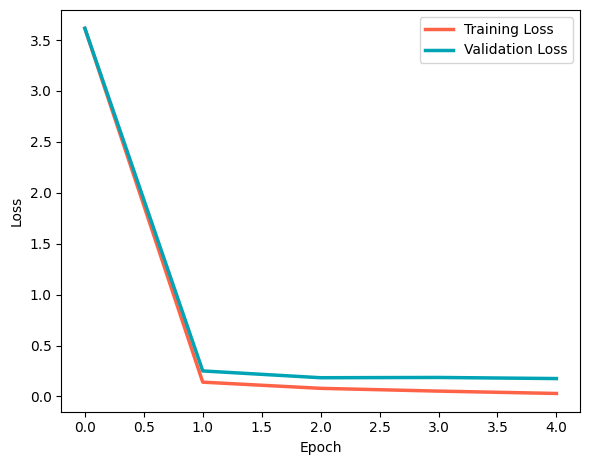

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.94      0.93        98
          American Bulldog       0.80      0.91      0.85       100
 American Pit Bull Terrier       0.90      0.54      0.68       100
              Basset Hound       0.97      0.94      0.95       100
                    Beagle       0.92      0.98      0.95       100
                    Bengal       0.72      0.96      0.82       100
                    Birman       0.72      0.94      0.82       100
                    Bombay       0.88      0.97      0.92        88
                     Boxer       0.93      0.93      0.93        99
         British Shorthair       0.99      0.78      0.87       100
                 Chihuahua       0.83      0.97      0.89       100
              Egyptian Mau       0.91      0.81      0.86        97
    English Cocker Spaniel       0.97      0.99      0.98       100
            English Setter       1.00      0.95

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.154334 	 Validation Loss: 0.152765


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.100261 	 Validation Loss: 0.152842


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.054177 	 Validation Loss: 0.098097


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.039293 	 Validation Loss: 0.112657
Accuracy of Val: 0.9688
Accuracy of Test: 0.9275
Training finished in 695.63 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9275


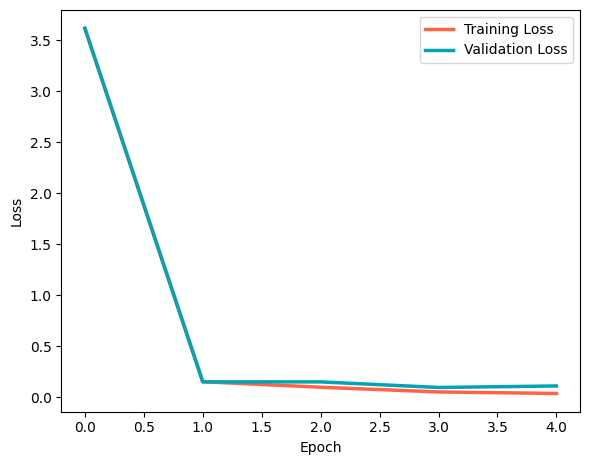

                            precision    recall  f1-score   support

                Abyssinian       0.90      0.97      0.93        98
          American Bulldog       0.85      0.85      0.85       100
 American Pit Bull Terrier       0.90      0.60      0.72       100
              Basset Hound       0.98      0.97      0.97       100
                    Beagle       0.97      0.97      0.97       100
                    Bengal       0.70      1.00      0.83       100
                    Birman       0.85      0.58      0.69       100
                    Bombay       0.92      0.99      0.95        88
                     Boxer       0.90      0.94      0.92        99
         British Shorthair       0.97      0.84      0.90       100
                 Chihuahua       0.92      0.96      0.94       100
              Egyptian Mau       0.96      0.75      0.84        97
    English Cocker Spaniel       0.98      1.00      0.99       100
            English Setter       1.00      0.97

In [ ]:
testing = [(5e-3, 4, 6, 1)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    for i in range(5):
        print(f"RUN {i}")
        print(f"Training with parameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Unfreeze Interval: {unfreeze_interval}")
        print(f"  Reduce Learning Rate: {reduce_learning_rate}")
        print(f"  Training Mode: {training_mode}")
        train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
        train.train()
        train.evaluate(train.val_loader)
        train.evaluate(train.test_loader)
        train.plot_loss_curves()
        train.classification_report()
        print("-" * 40)

RUN 0
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.183616 	 Validation Loss: 0.215333


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.089323 	 Validation Loss: 0.145583


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.061798 	 Validation Loss: 0.124193


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.065827 	 Validation Loss: 0.126164
Accuracy of Val: 0.9538
Accuracy of Test: 0.9362


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.020235 	 Validation Loss: 0.109729


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.027039 	 Validation Loss: 0.106086


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.017160 	 Validation Loss: 0.088664


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.014633 	 Validation Loss: 0.086013
Accuracy of Val: 0.9715
Accuracy of Test: 0.9368


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.009022 	 Validation Loss: 0.082957


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.013112 	 Validation Loss: 0.080898


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.009015 	 Validation Loss: 0.081880


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.009959 	 Validation Loss: 0.079618
Accuracy of Val: 0.9701
Accuracy of Test: 0.9419


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.006899 	 Validation Loss: 0.085679


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.008272 	 Validation Loss: 0.081844


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.011377 	 Validation Loss: 0.079332


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.006995 	 Validation Loss: 0.081251
Accuracy of Val: 0.9715
Accuracy of Test: 0.9406


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.007172 	 Validation Loss: 0.080495


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.007987 	 Validation Loss: 0.086199


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.006489 	 Validation Loss: 0.082925


Epoch 20/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 20, Training Loss: 0.008080 	 Validation Loss: 0.078118
Accuracy of Val: 0.9742
Accuracy of Test: 0.9441


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.009385 	 Validation Loss: 0.079099


Epoch 22/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 22, Training Loss: 0.008050 	 Validation Loss: 0.076629


Epoch 23/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 23, Training Loss: 0.007237 	 Validation Loss: 0.079869


Epoch 24/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 24, Training Loss: 0.007492 	 Validation Loss: 0.082783
Accuracy of Val: 0.9701
Accuracy of Test: 0.9439
Training finished in 4167.09 seconds
Accuracy of Val: 0.9701
Accuracy of Test: 0.9439


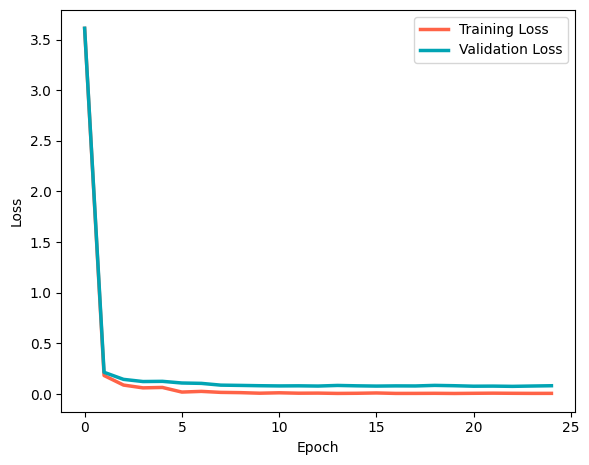

                            precision    recall  f1-score   support

                Abyssinian       0.97      0.94      0.95        98
          American Bulldog       0.81      0.96      0.88       100
 American Pit Bull Terrier       0.92      0.56      0.70       100
              Basset Hound       0.97      0.96      0.96       100
                    Beagle       0.95      0.97      0.96       100
                    Bengal       0.81      0.95      0.88       100
                    Birman       0.83      0.86      0.84       100
                    Bombay       0.86      0.99      0.92        88
                     Boxer       0.94      0.95      0.94        99
         British Shorthair       0.99      0.88      0.93       100
                 Chihuahua       0.95      0.94      0.94       100
              Egyptian Mau       0.89      0.90      0.89        97
    English Cocker Spaniel       0.99      0.99      0.99       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.135765 	 Validation Loss: 0.197503


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.076808 	 Validation Loss: 0.185464


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.071898 	 Validation Loss: 0.176335


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.030781 	 Validation Loss: 0.129772
Accuracy of Val: 0.9565
Accuracy of Test: 0.9332


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.040172 	 Validation Loss: 0.161726


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.033285 	 Validation Loss: 0.179033


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.015215 	 Validation Loss: 0.115782


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.011271 	 Validation Loss: 0.115830
Accuracy of Val: 0.9620
Accuracy of Test: 0.9376


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.011580 	 Validation Loss: 0.113611


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.011059 	 Validation Loss: 0.112572


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.007739 	 Validation Loss: 0.114348


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.005944 	 Validation Loss: 0.109505
Accuracy of Val: 0.9579
Accuracy of Test: 0.9389


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.006811 	 Validation Loss: 0.110142


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.008892 	 Validation Loss: 0.110535


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.010324 	 Validation Loss: 0.101748


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.009127 	 Validation Loss: 0.103949
Accuracy of Val: 0.9647
Accuracy of Test: 0.9362


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.005973 	 Validation Loss: 0.104156


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.007665 	 Validation Loss: 0.102441


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.006400 	 Validation Loss: 0.109632


Epoch 20/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 20, Training Loss: 0.007188 	 Validation Loss: 0.107290
Accuracy of Val: 0.9633
Accuracy of Test: 0.9376


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.006506 	 Validation Loss: 0.102392


Epoch 22/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 22, Training Loss: 0.006219 	 Validation Loss: 0.106830


Epoch 23/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 23, Training Loss: 0.0066 	 Validation Loss: 0.1060. Early stopping triggered
Training finished in 3933.84 seconds
Accuracy of Val: 0.9660
Accuracy of Test: 0.9387


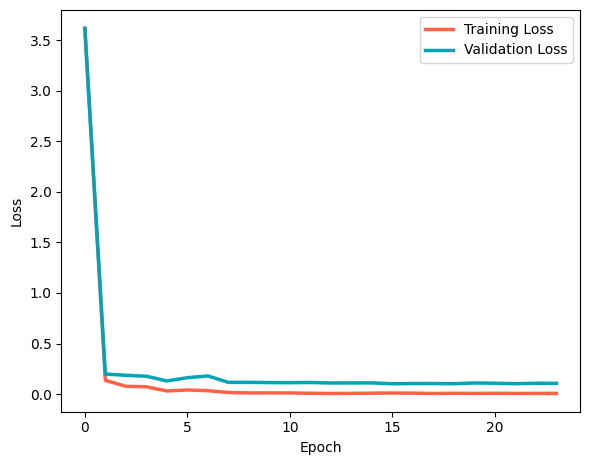

                            precision    recall  f1-score   support

                Abyssinian       0.96      0.93      0.94        98
          American Bulldog       0.85      0.94      0.90       100
 American Pit Bull Terrier       0.90      0.57      0.70       100
              Basset Hound       0.98      0.94      0.96       100
                    Beagle       0.92      0.96      0.94       100
                    Bengal       0.84      0.95      0.89       100
                    Birman       0.79      0.84      0.82       100
                    Bombay       0.88      0.98      0.92        88
                     Boxer       0.93      0.94      0.93        99
         British Shorthair       0.98      0.83      0.90       100
                 Chihuahua       0.91      0.97      0.94       100
              Egyptian Mau       0.92      0.93      0.92        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       0.99      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.162610 	 Validation Loss: 0.211334


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.081949 	 Validation Loss: 0.161987


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.063963 	 Validation Loss: 0.174309


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.037620 	 Validation Loss: 0.146926
Accuracy of Val: 0.9443
Accuracy of Test: 0.9264
Training finished in 693.77 seconds
Accuracy of Val: 0.9443
Accuracy of Test: 0.9264


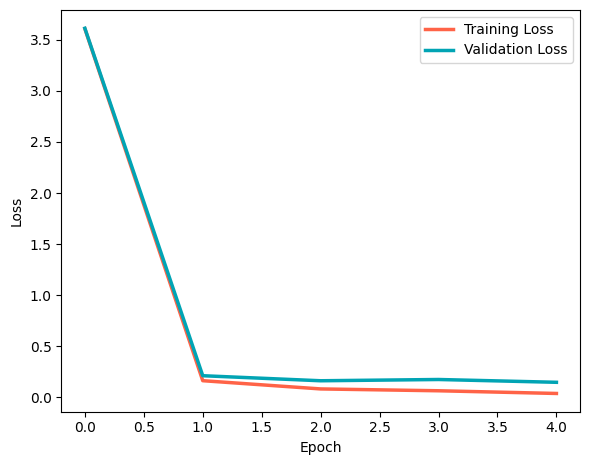

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.91      0.91        98
          American Bulldog       0.82      0.88      0.85       100
 American Pit Bull Terrier       0.90      0.55      0.68       100
              Basset Hound       0.90      0.98      0.94       100
                    Beagle       0.98      0.88      0.93       100
                    Bengal       0.68      0.98      0.80       100
                    Birman       0.78      0.94      0.85       100
                    Bombay       0.86      1.00      0.93        88
                     Boxer       0.90      0.93      0.92        99
         British Shorthair       0.98      0.82      0.89       100
                 Chihuahua       0.89      0.99      0.94       100
              Egyptian Mau       0.94      0.75      0.83        97
    English Cocker Spaniel       0.93      1.00      0.96       100
            English Setter       0.99      0.93

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.149382 	 Validation Loss: 0.178543


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.112974 	 Validation Loss: 0.163963


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.046393 	 Validation Loss: 0.117279


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.061630 	 Validation Loss: 0.139444
Accuracy of Val: 0.9484
Accuracy of Test: 0.9240
Training finished in 693.01 seconds
Accuracy of Val: 0.9484
Accuracy of Test: 0.9240


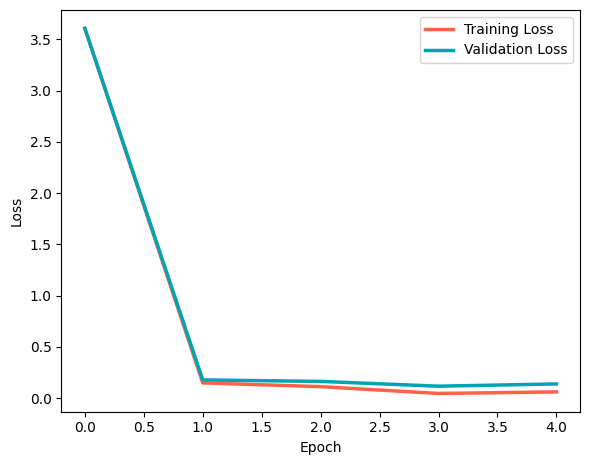

                            precision    recall  f1-score   support

                Abyssinian       0.86      0.95      0.90        98
          American Bulldog       0.77      0.89      0.82       100
 American Pit Bull Terrier       0.89      0.64      0.74       100
              Basset Hound       1.00      0.95      0.97       100
                    Beagle       0.95      0.99      0.97       100
                    Bengal       0.84      0.92      0.88       100
                    Birman       0.71      0.89      0.79       100
                    Bombay       0.81      1.00      0.90        88
                     Boxer       0.83      0.94      0.88        99
         British Shorthair       0.77      0.87      0.82       100
                 Chihuahua       0.93      0.96      0.95       100
              Egyptian Mau       0.94      0.87      0.90        97
    English Cocker Spaniel       0.98      0.98      0.98       100
            English Setter       0.99      0.96

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.178160 	 Validation Loss: 0.212479


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.079791 	 Validation Loss: 0.154401


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.053107 	 Validation Loss: 0.148348


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.046327 	 Validation Loss: 0.169317
Accuracy of Val: 0.9457
Accuracy of Test: 0.9250
Training finished in 692.45 seconds
Accuracy of Val: 0.9457
Accuracy of Test: 0.9250


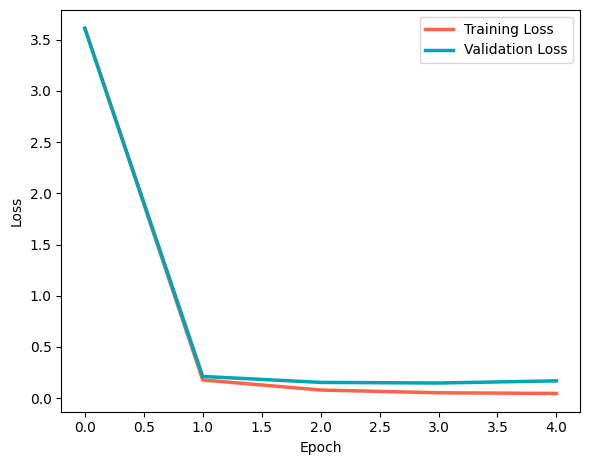

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.98      0.96        98
          American Bulldog       0.87      0.89      0.88       100
 American Pit Bull Terrier       0.81      0.59      0.68       100
              Basset Hound       0.96      0.96      0.96       100
                    Beagle       0.97      0.96      0.96       100
                    Bengal       0.86      0.74      0.80       100
                    Birman       0.85      0.63      0.72       100
                    Bombay       0.86      0.99      0.92        88
                     Boxer       0.95      0.92      0.93        99
         British Shorthair       0.97      0.90      0.93       100
                 Chihuahua       0.89      0.96      0.92       100
              Egyptian Mau       0.78      0.96      0.86        97
    English Cocker Spaniel       0.98      0.98      0.98       100
            English Setter       1.00      0.96

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.125388 	 Validation Loss: 0.190777


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.084291 	 Validation Loss: 0.184178


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.052624 	 Validation Loss: 0.139906


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.046279 	 Validation Loss: 0.154345
Accuracy of Val: 0.9443
Accuracy of Test: 0.9182
Training finished in 693.24 seconds
Accuracy of Val: 0.9443
Accuracy of Test: 0.9182


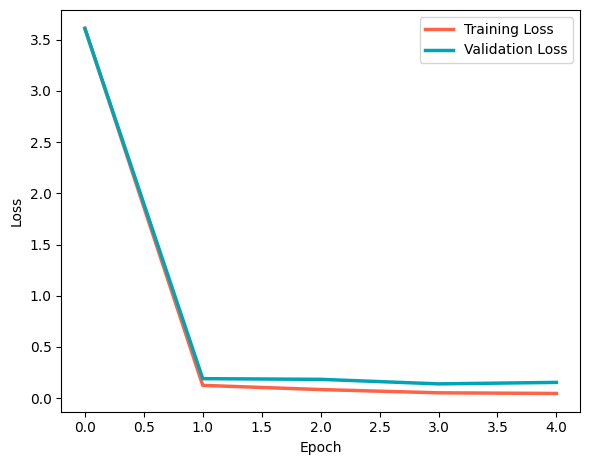

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.95      0.94        98
          American Bulldog       0.77      0.90      0.83       100
 American Pit Bull Terrier       1.00      0.25      0.40       100
              Basset Hound       0.94      0.98      0.96       100
                    Beagle       0.97      0.89      0.93       100
                    Bengal       0.80      0.82      0.81       100
                    Birman       0.88      0.65      0.75       100
                    Bombay       0.81      0.99      0.89        88
                     Boxer       0.87      0.93      0.90        99
         British Shorthair       0.98      0.81      0.89       100
                 Chihuahua       0.86      0.96      0.91       100
              Egyptian Mau       0.79      0.91      0.85        97
    English Cocker Spaniel       1.00      1.00      1.00       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.134364 	 Validation Loss: 0.195705


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.077784 	 Validation Loss: 0.145367


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.081186 	 Validation Loss: 0.187957


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.033558 	 Validation Loss: 0.144554
Accuracy of Val: 0.9470
Accuracy of Test: 0.9327


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 5, Training Loss: 0.020456 	 Validation Loss: 0.149487


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.024339 	 Validation Loss: 0.167022


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.010602 	 Validation Loss: 0.137722


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.010908 	 Validation Loss: 0.136058
Accuracy of Val: 0.9524
Accuracy of Test: 0.9389


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.011418 	 Validation Loss: 0.136794


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.010178 	 Validation Loss: 0.132487


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.007147 	 Validation Loss: 0.132677


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.007468 	 Validation Loss: 0.137370
Accuracy of Val: 0.9538
Accuracy of Test: 0.9406


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 13, Training Loss: 0.006366 	 Validation Loss: 0.131927


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.006486 	 Validation Loss: 0.133374


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 15, Training Loss: 0.007415 	 Validation Loss: 0.140873


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.006392 	 Validation Loss: 0.139134
Accuracy of Val: 0.9552
Accuracy of Test: 0.9411


Epoch 17/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 17, Training Loss: 0.006705 	 Validation Loss: 0.136139


Epoch 18/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 18, Training Loss: 0.006875 	 Validation Loss: 0.134727


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.006689 	 Validation Loss: 0.136187


Epoch 20/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 20, Training Loss: 0.005609 	 Validation Loss: 0.135847
Accuracy of Val: 0.9538
Accuracy of Test: 0.9398


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.0114 	 Validation Loss: 0.1322. Early stopping triggered
Training finished in 3617.22 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9409


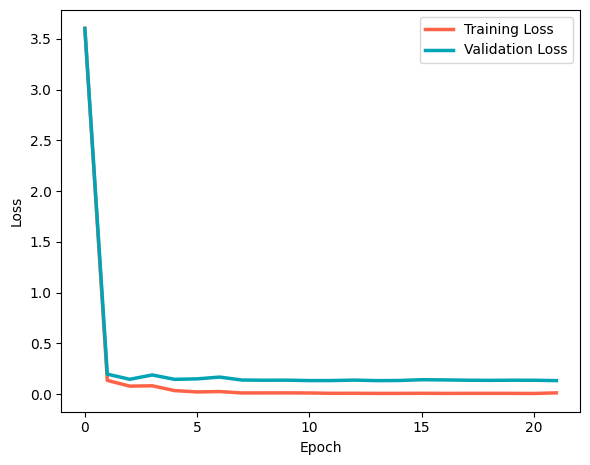

                            precision    recall  f1-score   support

                Abyssinian       0.97      0.91      0.94        98
          American Bulldog       0.79      0.92      0.85       100
 American Pit Bull Terrier       0.87      0.66      0.75       100
              Basset Hound       1.00      0.95      0.97       100
                    Beagle       0.95      0.99      0.97       100
                    Bengal       0.76      0.98      0.86       100
                    Birman       0.78      0.83      0.81       100
                    Bombay       0.84      1.00      0.91        88
                     Boxer       0.95      0.92      0.93        99
         British Shorthair       0.98      0.88      0.93       100
                 Chihuahua       0.94      0.98      0.96       100
              Egyptian Mau       0.91      0.87      0.89        97
    English Cocker Spaniel       0.99      0.99      0.99       100
            English Setter       0.98      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.153718 	 Validation Loss: 0.182280


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.095506 	 Validation Loss: 0.149485


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.048347 	 Validation Loss: 0.143742


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.025899 	 Validation Loss: 0.138385
Accuracy of Val: 0.9457
Accuracy of Test: 0.9409


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.031843 	 Validation Loss: 0.150394


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.016396 	 Validation Loss: 0.141347


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.011332 	 Validation Loss: 0.105132


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.008714 	 Validation Loss: 0.116701
Accuracy of Val: 0.9606
Accuracy of Test: 0.9425


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.007856 	 Validation Loss: 0.111957


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.007428 	 Validation Loss: 0.105126


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.006633 	 Validation Loss: 0.107963


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.011603 	 Validation Loss: 0.106214
Accuracy of Val: 0.9579
Accuracy of Test: 0.9414


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.009069 	 Validation Loss: 0.102601


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.006218 	 Validation Loss: 0.106264


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.005750 	 Validation Loss: 0.107196


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.006387 	 Validation Loss: 0.107449
Accuracy of Val: 0.9565
Accuracy of Test: 0.9455


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.006967 	 Validation Loss: 0.113559


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.007842 	 Validation Loss: 0.107333


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.007183 	 Validation Loss: 0.109646


Epoch 20/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 20, Training Loss: 0.005049 	 Validation Loss: 0.108440
Accuracy of Val: 0.9620
Accuracy of Test: 0.9411


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.0086 	 Validation Loss: 0.1040. Early stopping triggered
Training finished in 3621.01 seconds
Accuracy of Val: 0.9592
Accuracy of Test: 0.9439


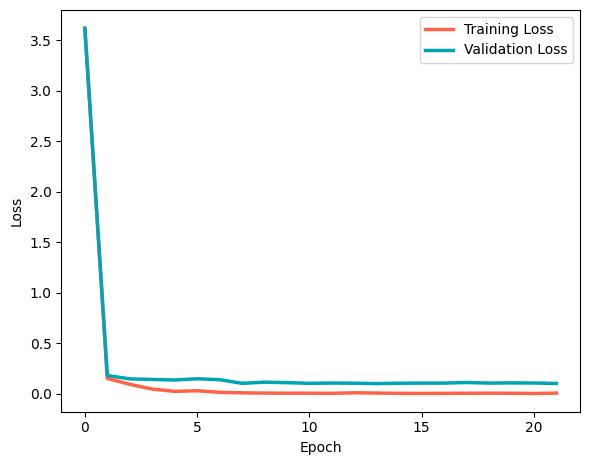

                            precision    recall  f1-score   support

                Abyssinian       0.96      0.93      0.94        98
          American Bulldog       0.83      0.91      0.87       100
 American Pit Bull Terrier       0.91      0.60      0.72       100
              Basset Hound       0.99      0.97      0.98       100
                    Beagle       0.97      0.98      0.98       100
                    Bengal       0.83      0.96      0.89       100
                    Birman       0.84      0.88      0.86       100
                    Bombay       0.88      0.99      0.93        88
                     Boxer       0.93      0.93      0.93        99
         British Shorthair       0.98      0.88      0.93       100
                 Chihuahua       0.91      0.96      0.93       100
              Egyptian Mau       0.93      0.92      0.92        97
    English Cocker Spaniel       0.98      0.99      0.99       100
            English Setter       0.99      0.96

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.141916 	 Validation Loss: 0.193654


Epoch 2/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 2, Training Loss: 0.079264 	 Validation Loss: 0.154767


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.063428 	 Validation Loss: 0.140454


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.035602 	 Validation Loss: 0.143083
Accuracy of Val: 0.9592
Accuracy of Test: 0.9283
Training finished in 688.05 seconds
Accuracy of Val: 0.9592
Accuracy of Test: 0.9283


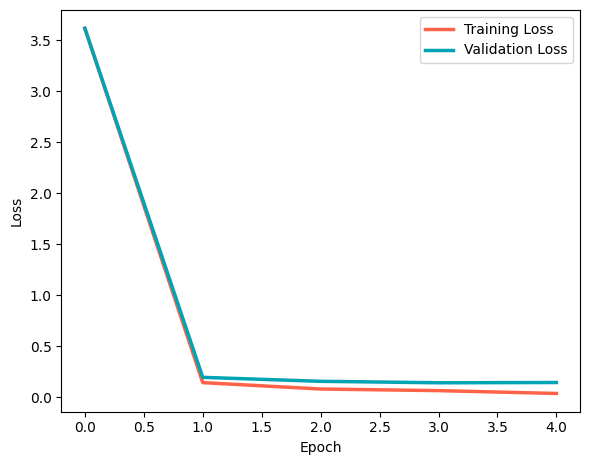

                            precision    recall  f1-score   support

                Abyssinian       0.89      0.87      0.88        98
          American Bulldog       0.75      0.95      0.84       100
 American Pit Bull Terrier       0.94      0.46      0.62       100
              Basset Hound       0.93      0.98      0.96       100
                    Beagle       0.98      0.93      0.95       100
                    Bengal       0.76      0.96      0.85       100
                    Birman       0.77      0.81      0.79       100
                    Bombay       0.84      1.00      0.91        88
                     Boxer       0.95      0.92      0.93        99
         British Shorthair       0.98      0.83      0.90       100
                 Chihuahua       0.93      0.95      0.94       100
              Egyptian Mau       0.87      0.86      0.86        97
    English Cocker Spaniel       0.99      0.98      0.98       100
            English Setter       0.99      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.147264 	 Validation Loss: 0.191942


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.073660 	 Validation Loss: 0.139836


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.058742 	 Validation Loss: 0.151036


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.043039 	 Validation Loss: 0.149244
Accuracy of Val: 0.9484
Accuracy of Test: 0.9220
Training finished in 690.21 seconds
Accuracy of Val: 0.9484
Accuracy of Test: 0.9220


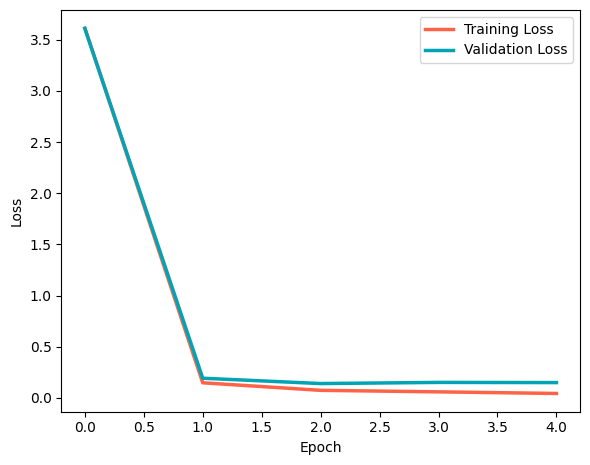

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.90      0.91        98
          American Bulldog       0.69      0.96      0.80       100
 American Pit Bull Terrier       0.86      0.61      0.71       100
              Basset Hound       0.87      0.97      0.92       100
                    Beagle       0.98      0.83      0.90       100
                    Bengal       0.79      0.83      0.81       100
                    Birman       0.81      0.89      0.85       100
                    Bombay       0.79      0.98      0.87        88
                     Boxer       0.97      0.79      0.87        99
         British Shorthair       0.99      0.80      0.88       100
                 Chihuahua       0.95      0.93      0.94       100
              Egyptian Mau       0.81      0.94      0.87        97
    English Cocker Spaniel       1.00      0.96      0.98       100
            English Setter       1.00      0.98

In [ ]:
testing = [(5e-3, 4, 6, 1)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    for i in range(10):
        print(f"RUN {i}")
        print(f"Training with parameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Unfreeze Interval: {unfreeze_interval}")
        print(f"  Reduce Learning Rate: {reduce_learning_rate}")
        print(f"  Training Mode: {training_mode}")
        train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
        train.train()
        train.evaluate(train.val_loader)
        train.evaluate(train.test_loader)
        train.plot_loss_curves()
        train.classification_report()
        print("-" * 40)

Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.138051 	 Validation Loss: 0.168014


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.077730 	 Validation Loss: 0.128551


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.055770 	 Validation Loss: 0.115847


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.038771 	 Validation Loss: 0.137572
Accuracy of Val: 0.9538
Accuracy of Test: 0.9291


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.042948 	 Validation Loss: 0.136508


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.024845 	 Validation Loss: 0.117712


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.014900 	 Validation Loss: 0.098754


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.014608 	 Validation Loss: 0.093831
Accuracy of Val: 0.9701
Accuracy of Test: 0.9414


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.012857 	 Validation Loss: 0.092451


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.011257 	 Validation Loss: 0.093674


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.010853 	 Validation Loss: 0.092888


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.008280 	 Validation Loss: 0.095691
Accuracy of Val: 0.9674
Accuracy of Test: 0.9422


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.008559 	 Validation Loss: 0.092160


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.009867 	 Validation Loss: 0.096207


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.006878 	 Validation Loss: 0.093111


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.005913 	 Validation Loss: 0.093755
Accuracy of Val: 0.9701
Accuracy of Test: 0.9425


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.009714 	 Validation Loss: 0.093670


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.0059 	 Validation Loss: 0.0957. Early stopping triggered
Training finished in 3084.00 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9414


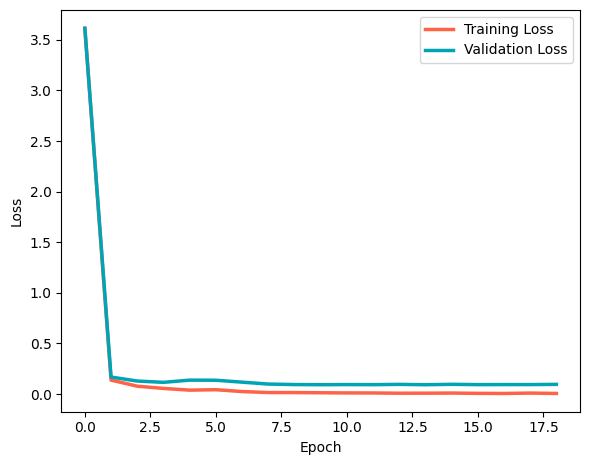

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.94      0.92        98
          American Bulldog       0.83      0.95      0.89       100
 American Pit Bull Terrier       0.88      0.68      0.77       100
              Basset Hound       0.99      0.92      0.95       100
                    Beagle       0.93      0.99      0.96       100
                    Bengal       0.84      0.92      0.88       100
                    Birman       0.79      0.88      0.83       100
                    Bombay       0.84      0.99      0.91        88
                     Boxer       0.91      0.94      0.93        99
         British Shorthair       0.98      0.85      0.91       100
                 Chihuahua       0.95      0.95      0.95       100
              Egyptian Mau       0.89      0.91      0.90        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.159560 	 Validation Loss: 0.225998


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.088323 	 Validation Loss: 0.169782


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.051020 	 Validation Loss: 0.128073


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.054510 	 Validation Loss: 0.144948
Accuracy of Val: 0.9579
Accuracy of Test: 0.9210


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.019821 	 Validation Loss: 0.125327


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.017615 	 Validation Loss: 0.119715


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.017895 	 Validation Loss: 0.121450


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.017624 	 Validation Loss: 0.124642
Accuracy of Val: 0.9552
Accuracy of Test: 0.9406


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.019495 	 Validation Loss: 0.125287


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.018858 	 Validation Loss: 0.123064


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.0193 	 Validation Loss: 0.1203. Early stopping triggered
Training finished in 1848.38 seconds
Accuracy of Val: 0.9552
Accuracy of Test: 0.9422


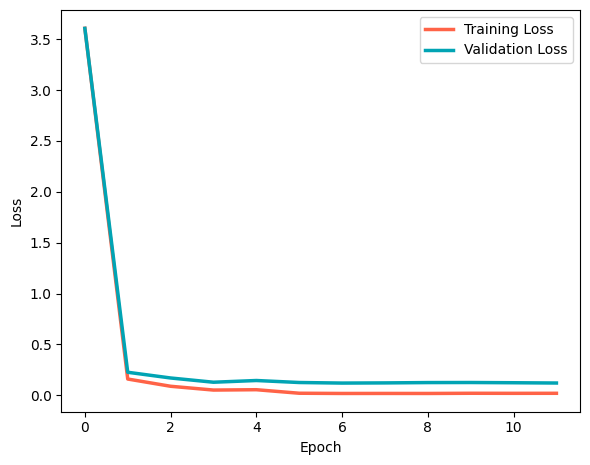

                            precision    recall  f1-score   support

                Abyssinian       0.98      0.91      0.94        98
          American Bulldog       0.80      0.90      0.85       100
 American Pit Bull Terrier       0.85      0.61      0.71       100
              Basset Hound       0.98      0.94      0.96       100
                    Beagle       0.95      0.97      0.96       100
                    Bengal       0.77      0.95      0.85       100
                    Birman       0.82      0.93      0.87       100
                    Bombay       0.87      0.98      0.92        88
                     Boxer       0.92      0.93      0.92        99
         British Shorthair       0.99      0.89      0.94       100
                 Chihuahua       0.92      0.95      0.94       100
              Egyptian Mau       0.90      0.93      0.91        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.168234 	 Validation Loss: 0.220615


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.084178 	 Validation Loss: 0.183478


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.056802 	 Validation Loss: 0.152050


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.029418 	 Validation Loss: 0.130296
Accuracy of Val: 0.9647
Accuracy of Test: 0.9302


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.023502 	 Validation Loss: 0.134050


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.030468 	 Validation Loss: 0.167185


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.008472 	 Validation Loss: 0.115794


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.010724 	 Validation Loss: 0.118671
Accuracy of Val: 0.9633
Accuracy of Test: 0.9354


Epoch 9/24: 100%|██████████| 184/184 [01:26<00:00,  2.14batch/s]


Epoch 9, Training Loss: 0.008090 	 Validation Loss: 0.112349


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.007448 	 Validation Loss: 0.111318


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 11, Training Loss: 0.007012 	 Validation Loss: 0.109749


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 12, Training Loss: 0.006204 	 Validation Loss: 0.107936
Accuracy of Val: 0.9688
Accuracy of Test: 0.9414


Epoch 13/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 13, Training Loss: 0.006127 	 Validation Loss: 0.109057


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.007520 	 Validation Loss: 0.107155


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.005701 	 Validation Loss: 0.110414


Epoch 16/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 16, Training Loss: 0.006604 	 Validation Loss: 0.106462
Accuracy of Val: 0.9688
Accuracy of Test: 0.9419


Epoch 17/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 17, Training Loss: 0.009741 	 Validation Loss: 0.108706


Epoch 18/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 18, Training Loss: 0.005026 	 Validation Loss: 0.101674


Epoch 19/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 19, Training Loss: 0.008040 	 Validation Loss: 0.110556


Epoch 20/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 20, Training Loss: 0.007512 	 Validation Loss: 0.109442
Accuracy of Val: 0.9674
Accuracy of Test: 0.9409


Epoch 21/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 21, Training Loss: 0.005189 	 Validation Loss: 0.106116


Epoch 22/24: 100%|██████████| 184/184 [01:27<00:00,  2.09batch/s]


Epoch 22, Training Loss: 0.005134 	 Validation Loss: 0.105469


Epoch 23/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 23, Training Loss: 0.0071 	 Validation Loss: 0.1058. Early stopping triggered
Training finished in 3957.69 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9409


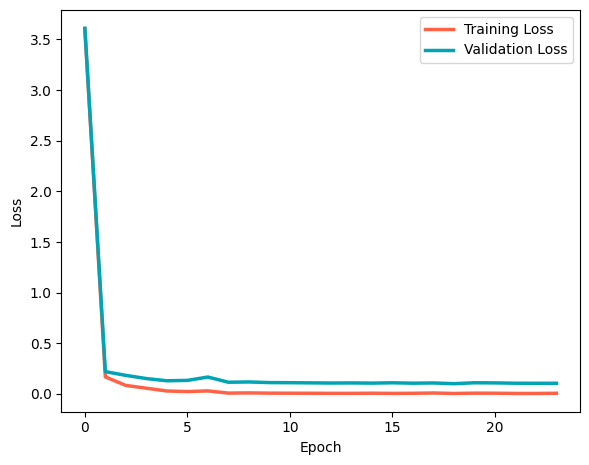

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.95      0.94        98
          American Bulldog       0.78      0.95      0.86       100
 American Pit Bull Terrier       0.84      0.65      0.73       100
              Basset Hound       0.99      0.95      0.97       100
                    Beagle       0.96      0.98      0.97       100
                    Bengal       0.83      0.91      0.87       100
                    Birman       0.81      0.89      0.85       100
                    Bombay       0.86      1.00      0.93        88
                     Boxer       0.94      0.93      0.93        99
         British Shorthair       0.99      0.86      0.92       100
                 Chihuahua       0.93      0.95      0.94       100
              Egyptian Mau       0.92      0.93      0.92        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.145347 	 Validation Loss: 0.185453


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.082889 	 Validation Loss: 0.165185


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.074570 	 Validation Loss: 0.165775


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.040030 	 Validation Loss: 0.136722
Accuracy of Val: 0.9592
Accuracy of Test: 0.9321


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.030452 	 Validation Loss: 0.141737


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.027807 	 Validation Loss: 0.144812


Epoch 7/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 7, Training Loss: 0.012248 	 Validation Loss: 0.106425


Epoch 8/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 8, Training Loss: 0.013081 	 Validation Loss: 0.106165
Accuracy of Val: 0.9633
Accuracy of Test: 0.9376


Epoch 9/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 9, Training Loss: 0.010262 	 Validation Loss: 0.097754


Epoch 10/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 10, Training Loss: 0.008710 	 Validation Loss: 0.097971


Epoch 11/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 11, Training Loss: 0.006517 	 Validation Loss: 0.094530


Epoch 12/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 12, Training Loss: 0.006335 	 Validation Loss: 0.095676
Accuracy of Val: 0.9660
Accuracy of Test: 0.9406


Epoch 13/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 13, Training Loss: 0.007011 	 Validation Loss: 0.100505


Epoch 14/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 14, Training Loss: 0.009371 	 Validation Loss: 0.096446


Epoch 15/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 15, Training Loss: 0.006674 	 Validation Loss: 0.099917


Epoch 16/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 16, Training Loss: 0.0048 	 Validation Loss: 0.0950. Early stopping triggered
Training finished in 2728.70 seconds
Accuracy of Val: 0.9660
Accuracy of Test: 0.9422


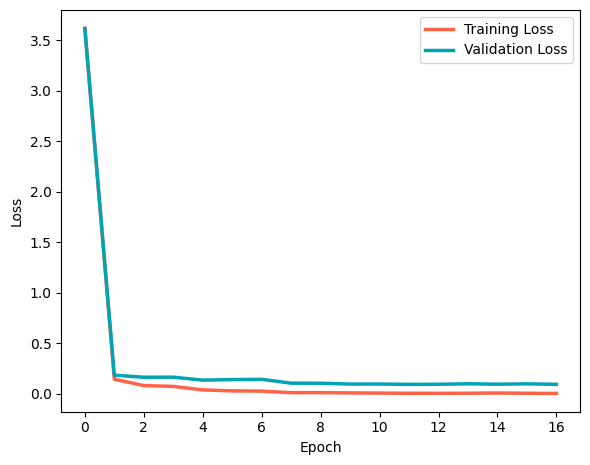

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.95      0.94        98
          American Bulldog       0.80      0.95      0.87       100
 American Pit Bull Terrier       0.93      0.65      0.76       100
              Basset Hound       0.99      0.94      0.96       100
                    Beagle       0.95      0.97      0.96       100
                    Bengal       0.84      0.92      0.88       100
                    Birman       0.80      0.86      0.83       100
                    Bombay       0.84      0.97      0.90        88
                     Boxer       0.94      0.92      0.93        99
         British Shorthair       0.98      0.82      0.89       100
                 Chihuahua       0.93      0.97      0.95       100
              Egyptian Mau       0.89      0.94      0.91        97
    English Cocker Spaniel       0.98      0.99      0.99       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 1, Training Loss: 0.447560 	 Validation Loss: 0.507545


Epoch 2/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 2, Training Loss: 0.252461 	 Validation Loss: 0.342011


Epoch 3/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 3, Training Loss: 0.182736 	 Validation Loss: 0.278894


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 4, Training Loss: 0.105519 	 Validation Loss: 0.210518
Accuracy of Val: 0.9293
Accuracy of Test: 0.9109


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 5, Training Loss: 0.101115 	 Validation Loss: 0.228158


Epoch 6/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 6, Training Loss: 0.058372 	 Validation Loss: 0.183229


Epoch 7/24: 100%|██████████| 184/184 [00:36<00:00,  5.04batch/s]


Epoch 7, Training Loss: 0.054013 	 Validation Loss: 0.182474


Epoch 8/24: 100%|██████████| 184/184 [00:36<00:00,  5.06batch/s]


Epoch 8, Training Loss: 0.055013 	 Validation Loss: 0.169311
Accuracy of Val: 0.9348
Accuracy of Test: 0.9171


Epoch 9/24: 100%|██████████| 184/184 [00:36<00:00,  5.06batch/s]


Epoch 9, Training Loss: 0.048579 	 Validation Loss: 0.172685


Epoch 10/24: 100%|██████████| 184/184 [00:37<00:00,  4.92batch/s]


Epoch 10, Training Loss: 0.047249 	 Validation Loss: 0.168882


Epoch 11/24: 100%|██████████| 184/184 [00:37<00:00,  4.91batch/s]


Epoch 11, Training Loss: 0.047580 	 Validation Loss: 0.154158


Epoch 12/24: 100%|██████████| 184/184 [00:37<00:00,  4.89batch/s]


Epoch 12, Training Loss: 0.045611 	 Validation Loss: 0.164263
Accuracy of Val: 0.9402
Accuracy of Test: 0.9226


Epoch 13/24: 100%|██████████| 184/184 [00:38<00:00,  4.72batch/s]


Epoch 13, Training Loss: 0.047655 	 Validation Loss: 0.179563


Epoch 14/24: 100%|██████████| 184/184 [00:39<00:00,  4.69batch/s]


Epoch 14, Training Loss: 0.043577 	 Validation Loss: 0.157204


Epoch 15/24: 100%|██████████| 184/184 [00:38<00:00,  4.77batch/s]


Epoch 15, Training Loss: 0.046911 	 Validation Loss: 0.180890


Epoch 16/24: 100%|██████████| 184/184 [00:39<00:00,  4.61batch/s]


Epoch 16, Training Loss: 0.0472 	 Validation Loss: 0.1595. Early stopping triggered
Training finished in 1947.62 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9229


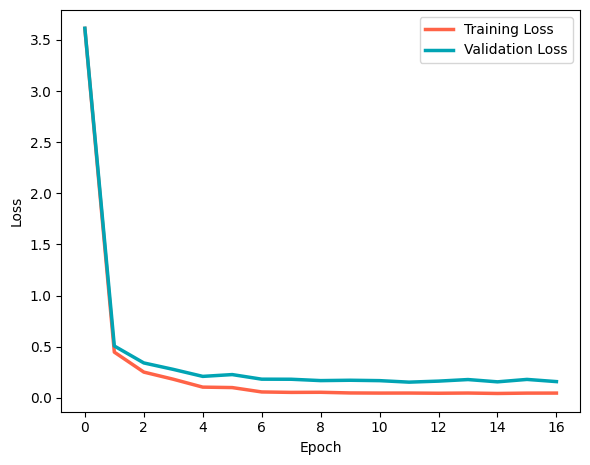

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.87      0.89        98
          American Bulldog       0.80      0.92      0.86       100
 American Pit Bull Terrier       0.88      0.53      0.66       100
              Basset Hound       0.97      0.95      0.96       100
                    Beagle       0.95      0.96      0.96       100
                    Bengal       0.79      0.90      0.84       100
                    Birman       0.79      0.81      0.80       100
                    Bombay       0.86      0.97      0.91        88
                     Boxer       0.86      0.93      0.89        99
         British Shorthair       0.93      0.84      0.88       100
                 Chihuahua       0.90      0.92      0.91       100
              Egyptian Mau       0.88      0.91      0.89        97
    English Cocker Spaniel       0.98      0.97      0.97       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 1, Training Loss: 0.448786 	 Validation Loss: 0.481338


Epoch 2/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 2, Training Loss: 0.251103 	 Validation Loss: 0.299364


Epoch 3/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 3, Training Loss: 0.184859 	 Validation Loss: 0.250994


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.22batch/s]


Epoch 4, Training Loss: 0.134601 	 Validation Loss: 0.215340
Accuracy of Val: 0.9334
Accuracy of Test: 0.9144


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 5, Training Loss: 0.134466 	 Validation Loss: 0.234115


Epoch 6/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 6, Training Loss: 0.100492 	 Validation Loss: 0.203783


Epoch 7/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 7, Training Loss: 0.099786 	 Validation Loss: 0.185814


Epoch 8/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 8, Training Loss: 0.087130 	 Validation Loss: 0.193276
Accuracy of Val: 0.9334
Accuracy of Test: 0.9103


Epoch 9/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 9, Training Loss: 0.088853 	 Validation Loss: 0.186702


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 10, Training Loss: 0.084090 	 Validation Loss: 0.187984


Epoch 11/24: 100%|██████████| 184/184 [00:35<00:00,  5.24batch/s]


Epoch 11, Training Loss: 0.081770 	 Validation Loss: 0.184747


Epoch 12/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 12, Training Loss: 0.079119 	 Validation Loss: 0.176160
Accuracy of Val: 0.9457
Accuracy of Test: 0.9171


Epoch 13/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 13, Training Loss: 0.080385 	 Validation Loss: 0.181397


Epoch 14/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 14, Training Loss: 0.088601 	 Validation Loss: 0.184505


Epoch 15/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 15, Training Loss: 0.082634 	 Validation Loss: 0.191046


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 16, Training Loss: 0.080244 	 Validation Loss: 0.179386
Accuracy of Val: 0.9416
Accuracy of Test: 0.9141


Epoch 17/24: 100%|██████████| 184/184 [00:35<00:00,  5.21batch/s]


Epoch 17, Training Loss: 0.0814 	 Validation Loss: 0.1778. Early stopping triggered
Training finished in 2085.94 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9128


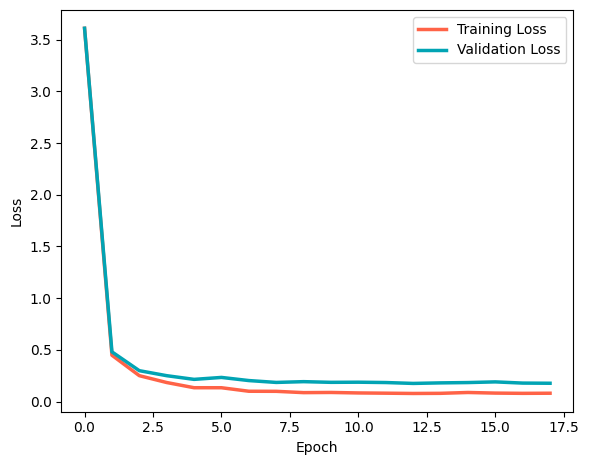

                            precision    recall  f1-score   support

                Abyssinian       0.90      0.89      0.89        98
          American Bulldog       0.81      0.88      0.84       100
 American Pit Bull Terrier       0.84      0.48      0.61       100
              Basset Hound       0.97      0.91      0.94       100
                    Beagle       0.93      0.97      0.95       100
                    Bengal       0.73      0.82      0.77       100
                    Birman       0.76      0.82      0.79       100
                    Bombay       0.84      0.97      0.90        88
                     Boxer       0.84      0.94      0.89        99
         British Shorthair       0.94      0.75      0.83       100
                 Chihuahua       0.89      0.96      0.92       100
              Egyptian Mau       0.83      0.88      0.85        97
    English Cocker Spaniel       0.98      0.93      0.95       100
            English Setter       0.96      0.98

Epoch 1/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 1, Training Loss: 0.446131 	 Validation Loss: 0.495524


Epoch 2/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 2, Training Loss: 0.259478 	 Validation Loss: 0.339359


Epoch 3/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 3, Training Loss: 0.177015 	 Validation Loss: 0.278470


Epoch 4/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 4, Training Loss: 0.144620 	 Validation Loss: 0.256352
Accuracy of Val: 0.9212
Accuracy of Test: 0.9049


Epoch 5/24: 100%|██████████| 184/184 [00:34<00:00,  5.32batch/s]


Epoch 5, Training Loss: 0.130053 	 Validation Loss: 0.236816


Epoch 6/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 6, Training Loss: 0.133647 	 Validation Loss: 0.249866


Epoch 7/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 7, Training Loss: 0.121293 	 Validation Loss: 0.237174


Epoch 8/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 8, Training Loss: 0.116522 	 Validation Loss: 0.232181
Accuracy of Val: 0.9361
Accuracy of Test: 0.9150


Epoch 9/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 9, Training Loss: 0.122859 	 Validation Loss: 0.235935


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.31batch/s]


Epoch 10, Training Loss: 0.123138 	 Validation Loss: 0.231579


Epoch 11/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 11, Training Loss: 0.119553 	 Validation Loss: 0.233259


Epoch 12/24: 100%|██████████| 184/184 [00:35<00:00,  5.23batch/s]


Epoch 12, Training Loss: 0.114897 	 Validation Loss: 0.225783
Accuracy of Val: 0.9402
Accuracy of Test: 0.9150


Epoch 13/24: 100%|██████████| 184/184 [00:35<00:00,  5.20batch/s]


Epoch 13, Training Loss: 0.114859 	 Validation Loss: 0.233302


Epoch 14/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 14, Training Loss: 0.110968 	 Validation Loss: 0.230729


Epoch 15/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 15, Training Loss: 0.116872 	 Validation Loss: 0.224044


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.29batch/s]


Epoch 16, Training Loss: 0.111346 	 Validation Loss: 0.227866
Accuracy of Val: 0.9402
Accuracy of Test: 0.9147


Epoch 17/24: 100%|██████████| 184/184 [00:35<00:00,  5.16batch/s]


Epoch 17, Training Loss: 0.111810 	 Validation Loss: 0.231644


Epoch 18/24: 100%|██████████| 184/184 [00:35<00:00,  5.12batch/s]


Epoch 18, Training Loss: 0.114421 	 Validation Loss: 0.228109


Epoch 19/24: 100%|██████████| 184/184 [00:35<00:00,  5.16batch/s]


Epoch 19, Training Loss: 0.114265 	 Validation Loss: 0.224725


Epoch 20/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 20, Training Loss: 0.1207 	 Validation Loss: 0.2289. Early stopping triggered
Training finished in 2407.86 seconds
Accuracy of Val: 0.9334
Accuracy of Test: 0.9180


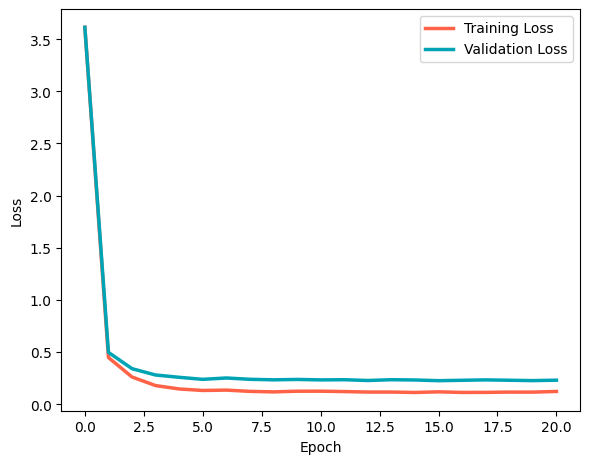

                            precision    recall  f1-score   support

                Abyssinian       0.90      0.88      0.89        98
          American Bulldog       0.81      0.97      0.88       100
 American Pit Bull Terrier       0.86      0.61      0.71       100
              Basset Hound       0.98      0.95      0.96       100
                    Beagle       0.96      0.97      0.97       100
                    Bengal       0.75      0.84      0.79       100
                    Birman       0.78      0.86      0.82       100
                    Bombay       0.83      0.98      0.90        88
                     Boxer       0.89      0.92      0.91        99
         British Shorthair       0.89      0.75      0.82       100
                 Chihuahua       0.89      0.95      0.92       100
              Egyptian Mau       0.83      0.88      0.85        97
    English Cocker Spaniel       0.96      0.97      0.97       100
            English Setter       0.98      0.99

Epoch 1/24: 100%|██████████| 184/184 [00:36<00:00,  5.10batch/s]


Epoch 1, Training Loss: 0.453299 	 Validation Loss: 0.472435


Epoch 2/24: 100%|██████████| 184/184 [00:36<00:00,  5.09batch/s]


Epoch 2, Training Loss: 0.248351 	 Validation Loss: 0.315278


Epoch 3/24: 100%|██████████| 184/184 [00:35<00:00,  5.13batch/s]


Epoch 3, Training Loss: 0.179948 	 Validation Loss: 0.253741


Epoch 4/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 4, Training Loss: 0.142008 	 Validation Loss: 0.216101
Accuracy of Val: 0.9429
Accuracy of Test: 0.9139


Epoch 5/24: 100%|██████████| 184/184 [00:35<00:00,  5.14batch/s]


Epoch 5, Training Loss: 0.133695 	 Validation Loss: 0.211467


Epoch 6/24: 100%|██████████| 184/184 [00:35<00:00,  5.14batch/s]


Epoch 6, Training Loss: 0.127970 	 Validation Loss: 0.214644


Epoch 7/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 7, Training Loss: 0.127867 	 Validation Loss: 0.210353


Epoch 8/24: 100%|██████████| 184/184 [00:35<00:00,  5.15batch/s]


Epoch 8, Training Loss: 0.126221 	 Validation Loss: 0.209776
Accuracy of Val: 0.9416
Accuracy of Test: 0.9161


Epoch 9/24: 100%|██████████| 184/184 [00:35<00:00,  5.22batch/s]


Epoch 9, Training Loss: 0.129310 	 Validation Loss: 0.217827


Epoch 10/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 10, Training Loss: 0.124465 	 Validation Loss: 0.217071


Epoch 11/24: 100%|██████████| 184/184 [00:35<00:00,  5.25batch/s]


Epoch 11, Training Loss: 0.121749 	 Validation Loss: 0.213018


Epoch 12/24: 100%|██████████| 184/184 [00:35<00:00,  5.20batch/s]


Epoch 12, Training Loss: 0.124576 	 Validation Loss: 0.210927
Accuracy of Val: 0.9457
Accuracy of Test: 0.9141


Epoch 13/24: 100%|██████████| 184/184 [00:34<00:00,  5.30batch/s]


Epoch 13, Training Loss: 0.121750 	 Validation Loss: 0.207003


Epoch 14/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 14, Training Loss: 0.131794 	 Validation Loss: 0.211628


Epoch 15/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 15, Training Loss: 0.121535 	 Validation Loss: 0.213467


Epoch 16/24: 100%|██████████| 184/184 [00:34<00:00,  5.28batch/s]


Epoch 16, Training Loss: 0.122908 	 Validation Loss: 0.208138
Accuracy of Val: 0.9429
Accuracy of Test: 0.9152


Epoch 17/24: 100%|██████████| 184/184 [00:34<00:00,  5.26batch/s]


Epoch 17, Training Loss: 0.130275 	 Validation Loss: 0.215402


Epoch 18/24: 100%|██████████| 184/184 [00:34<00:00,  5.27batch/s]


Epoch 18, Training Loss: 0.1220 	 Validation Loss: 0.2116. Early stopping triggered
Training finished in 2203.17 seconds
Accuracy of Val: 0.9416
Accuracy of Test: 0.9155


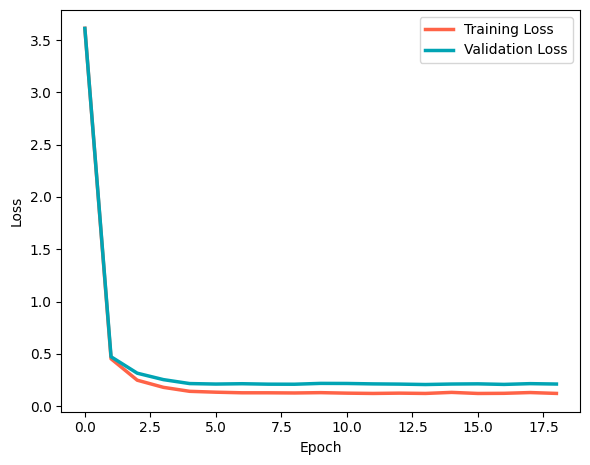

                            precision    recall  f1-score   support

                Abyssinian       0.89      0.89      0.89        98
          American Bulldog       0.78      0.95      0.86       100
 American Pit Bull Terrier       0.90      0.44      0.59       100
              Basset Hound       0.96      0.94      0.95       100
                    Beagle       0.95      0.96      0.96       100
                    Bengal       0.76      0.91      0.83       100
                    Birman       0.77      0.88      0.82       100
                    Bombay       0.85      0.94      0.89        88
                     Boxer       0.86      0.92      0.89        99
         British Shorthair       0.94      0.72      0.81       100
                 Chihuahua       0.89      0.94      0.91       100
              Egyptian Mau       0.91      0.91      0.91        97
    English Cocker Spaniel       0.98      0.97      0.97       100
            English Setter       0.99      0.99

In [ ]:
testing = [(5e-3, 4, 6, 1), (5e-3, 2, 2, 1), (5e-3, 4, 6, 2), (5e-3, 2, 6, 2), (5e-3, 3, 6, 3), (5e-3, 2, 6, 0), (5e-3, 2, 4, 0), (5e-3, 2, 2, 0)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    print(f"Training with parameters:")
    print(f"  Learning Rate: {lr}")
    print(f"  Unfreeze Interval: {unfreeze_interval}")
    print(f"  Reduce Learning Rate: {reduce_learning_rate}")
    print(f"  Training Mode: {training_mode}")
    train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
    train.train()
    train.evaluate(train.val_loader)
    train.evaluate(train.test_loader)
    train.plot_loss_curves()
    train.classification_report()
    print("-" * 40)

## kolla på senare


RUN 0
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.166303 	 Validation Loss: 0.232691


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.079713 	 Validation Loss: 0.178578


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.041294 	 Validation Loss: 0.160846


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.051617 	 Validation Loss: 0.186470
Accuracy of Val: 0.9429
Accuracy of Test: 0.9242


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.042570 	 Validation Loss: 0.202867


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.014285 	 Validation Loss: 0.178087


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.011308 	 Validation Loss: 0.156113


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.010852 	 Validation Loss: 0.155678
Accuracy of Val: 0.9592
Accuracy of Test: 0.9406


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.010915 	 Validation Loss: 0.157696


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.009240 	 Validation Loss: 0.163939


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.007818 	 Validation Loss: 0.148227


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.007192 	 Validation Loss: 0.143982
Accuracy of Val: 0.9552
Accuracy of Test: 0.9447


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.009250 	 Validation Loss: 0.147735


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.005840 	 Validation Loss: 0.157363


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.004783 	 Validation Loss: 0.154157


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.009857 	 Validation Loss: 0.153145
Accuracy of Val: 0.9552
Accuracy of Test: 0.9419


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.0074 	 Validation Loss: 0.1555. Early stopping triggered
Training finished in 2932.59 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9436


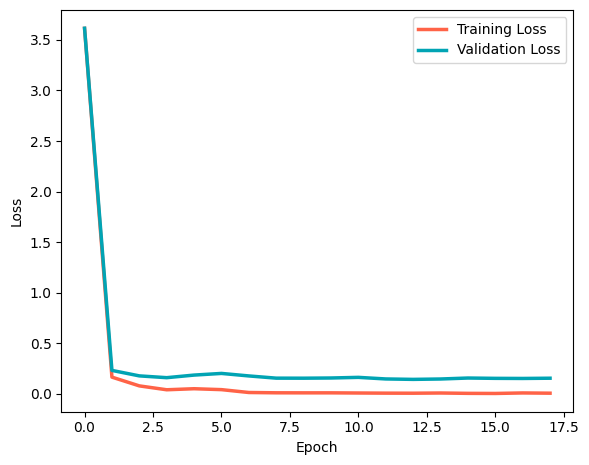

                            precision    recall  f1-score   support

                Abyssinian       0.97      0.95      0.96        98
          American Bulldog       0.80      0.90      0.85       100
 American Pit Bull Terrier       0.85      0.60      0.70       100
              Basset Hound       0.98      0.97      0.97       100
                    Beagle       0.97      0.97      0.97       100
                    Bengal       0.84      0.87      0.86       100
                    Birman       0.83      0.92      0.87       100
                    Bombay       0.90      0.99      0.94        88
                     Boxer       0.92      0.94      0.93        99
         British Shorthair       0.98      0.87      0.92       100
                 Chihuahua       0.93      0.97      0.95       100
              Egyptian Mau       0.85      0.96      0.90        97
    English Cocker Spaniel       0.99      0.98      0.98       100
            English Setter       0.99      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.130169 	 Validation Loss: 0.167155


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.097796 	 Validation Loss: 0.174216


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.052996 	 Validation Loss: 0.143134


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.051901 	 Validation Loss: 0.161418
Accuracy of Val: 0.9443
Accuracy of Test: 0.9242


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.024535 	 Validation Loss: 0.141133


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.032617 	 Validation Loss: 0.121599


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.011526 	 Validation Loss: 0.096202


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.009367 	 Validation Loss: 0.097530
Accuracy of Val: 0.9688
Accuracy of Test: 0.9357


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.010169 	 Validation Loss: 0.087980


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.009312 	 Validation Loss: 0.094642


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.006619 	 Validation Loss: 0.093631


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.007332 	 Validation Loss: 0.095142
Accuracy of Val: 0.9742
Accuracy of Test: 0.9359


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.006057 	 Validation Loss: 0.090628


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.0068 	 Validation Loss: 0.0930. Early stopping triggered
Training finished in 2383.17 seconds
Accuracy of Val: 0.9688
Accuracy of Test: 0.9384


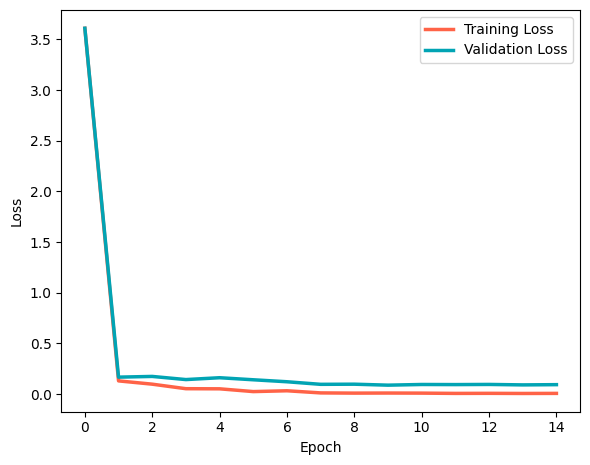

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.94      0.92        98
          American Bulldog       0.82      0.94      0.88       100
 American Pit Bull Terrier       0.89      0.59      0.71       100
              Basset Hound       1.00      0.95      0.97       100
                    Beagle       0.94      0.99      0.97       100
                    Bengal       0.83      0.96      0.89       100
                    Birman       0.79      0.83      0.81       100
                    Bombay       0.85      1.00      0.92        88
                     Boxer       0.93      0.94      0.93        99
         British Shorthair       0.98      0.84      0.90       100
                 Chihuahua       0.93      0.96      0.95       100
              Egyptian Mau       0.92      0.92      0.92        97
    English Cocker Spaniel       0.98      0.98      0.98       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.166321 	 Validation Loss: 0.197763


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.081200 	 Validation Loss: 0.156186


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.060241 	 Validation Loss: 0.161138


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.044567 	 Validation Loss: 0.148202
Accuracy of Val: 0.9511
Accuracy of Test: 0.9207


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.036616 	 Validation Loss: 0.150626


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.019749 	 Validation Loss: 0.133929


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.014691 	 Validation Loss: 0.115594


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.014564 	 Validation Loss: 0.113234
Accuracy of Val: 0.9579
Accuracy of Test: 0.9373


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.012254 	 Validation Loss: 0.111550


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.009924 	 Validation Loss: 0.112619


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.010236 	 Validation Loss: 0.118065


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.007294 	 Validation Loss: 0.111085
Accuracy of Val: 0.9606
Accuracy of Test: 0.9373


Epoch 13/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 13, Training Loss: 0.007259 	 Validation Loss: 0.109495


Epoch 14/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 14, Training Loss: 0.008222 	 Validation Loss: 0.109662


Epoch 15/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 15, Training Loss: 0.010073 	 Validation Loss: 0.109884


Epoch 16/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 16, Training Loss: 0.007867 	 Validation Loss: 0.113174
Accuracy of Val: 0.9579
Accuracy of Test: 0.9357


Epoch 17/24: 100%|██████████| 184/184 [01:23<00:00,  2.21batch/s]


Epoch 17, Training Loss: 0.007702 	 Validation Loss: 0.111587


Epoch 18/24: 100%|██████████| 184/184 [01:23<00:00,  2.20batch/s]


Epoch 18, Training Loss: 0.0109 	 Validation Loss: 0.1108. Early stopping triggered
Training finished in 3071.24 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9400


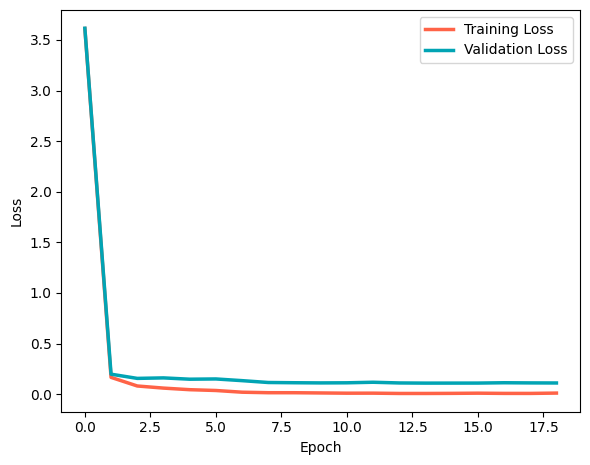

                            precision    recall  f1-score   support

                Abyssinian       0.91      0.95      0.93        98
          American Bulldog       0.83      0.96      0.89       100
 American Pit Bull Terrier       0.92      0.57      0.70       100
              Basset Hound       0.98      0.95      0.96       100
                    Beagle       0.96      0.97      0.97       100
                    Bengal       0.82      0.93      0.87       100
                    Birman       0.80      0.79      0.79       100
                    Bombay       0.89      0.99      0.94        88
                     Boxer       0.95      0.94      0.94        99
         British Shorthair       0.99      0.84      0.91       100
                 Chihuahua       0.93      0.95      0.94       100
              Egyptian Mau       0.92      0.92      0.92        97
    English Cocker Spaniel       1.00      1.00      1.00       100
            English Setter       1.00      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:23<00:00,  2.21batch/s]


Epoch 1, Training Loss: 0.166361 	 Validation Loss: 0.238227


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 2, Training Loss: 0.101598 	 Validation Loss: 0.179023


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.064776 	 Validation Loss: 0.173954


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.040748 	 Validation Loss: 0.137263
Accuracy of Val: 0.9524
Accuracy of Test: 0.9297


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.036268 	 Validation Loss: 0.168652


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.025960 	 Validation Loss: 0.162838


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.016481 	 Validation Loss: 0.130582


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.012944 	 Validation Loss: 0.127984
Accuracy of Val: 0.9579
Accuracy of Test: 0.9359


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.013207 	 Validation Loss: 0.125062


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.009192 	 Validation Loss: 0.121980


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.010004 	 Validation Loss: 0.120426


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.011771 	 Validation Loss: 0.125256
Accuracy of Val: 0.9552
Accuracy of Test: 0.9417


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.006499 	 Validation Loss: 0.123714


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.006662 	 Validation Loss: 0.120974


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.010216 	 Validation Loss: 0.118084


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.007198 	 Validation Loss: 0.121300
Accuracy of Val: 0.9579
Accuracy of Test: 0.9400


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.008660 	 Validation Loss: 0.124978


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.007524 	 Validation Loss: 0.122020


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.008329 	 Validation Loss: 0.116637


Epoch 20/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 20, Training Loss: 0.007559 	 Validation Loss: 0.119828
Accuracy of Val: 0.9579
Accuracy of Test: 0.9419


Epoch 21/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 21, Training Loss: 0.006266 	 Validation Loss: 0.121947


Epoch 22/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 22, Training Loss: 0.006545 	 Validation Loss: 0.121417


Epoch 23/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 23, Training Loss: 0.005849 	 Validation Loss: 0.119574


Epoch 24/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 24, Training Loss: 0.0091 	 Validation Loss: 0.1180. Early stopping triggered
Training finished in 4076.01 seconds
Accuracy of Val: 0.9592
Accuracy of Test: 0.9392


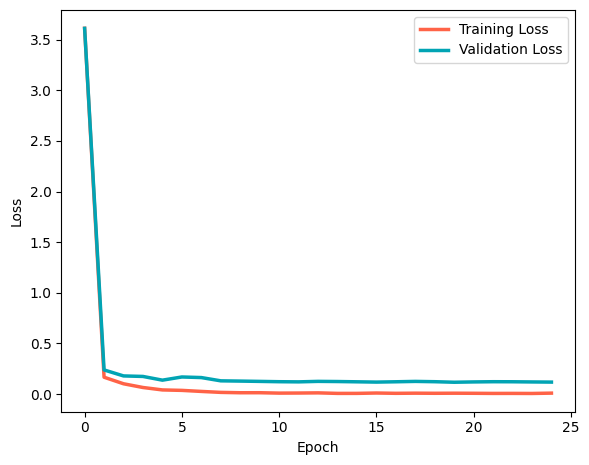

                            precision    recall  f1-score   support

                Abyssinian       0.96      0.91      0.93        98
          American Bulldog       0.84      0.91      0.87       100
 American Pit Bull Terrier       0.93      0.63      0.75       100
              Basset Hound       0.97      0.96      0.96       100
                    Beagle       0.97      0.97      0.97       100
                    Bengal       0.79      0.89      0.84       100
                    Birman       0.82      0.89      0.85       100
                    Bombay       0.87      0.98      0.92        88
                     Boxer       0.92      0.93      0.92        99
         British Shorthair       0.97      0.84      0.90       100
                 Chihuahua       0.90      0.99      0.94       100
              Egyptian Mau       0.84      0.92      0.88        97
    English Cocker Spaniel       0.99      0.99      0.99       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.151623 	 Validation Loss: 0.186762


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.086222 	 Validation Loss: 0.175011


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.066820 	 Validation Loss: 0.147603


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.037871 	 Validation Loss: 0.132851
Accuracy of Val: 0.9565
Accuracy of Test: 0.9316


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 5, Training Loss: 0.032383 	 Validation Loss: 0.130636


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.019736 	 Validation Loss: 0.117746


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 7, Training Loss: 0.016879 	 Validation Loss: 0.103238


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.013803 	 Validation Loss: 0.105999
Accuracy of Val: 0.9579
Accuracy of Test: 0.9409


Epoch 9/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 9, Training Loss: 0.010554 	 Validation Loss: 0.101549


Epoch 10/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 10, Training Loss: 0.010823 	 Validation Loss: 0.103263


Epoch 11/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 11, Training Loss: 0.006705 	 Validation Loss: 0.099308


Epoch 12/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 12, Training Loss: 0.007407 	 Validation Loss: 0.097046
Accuracy of Val: 0.9647
Accuracy of Test: 0.9409


Epoch 13/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 13, Training Loss: 0.011724 	 Validation Loss: 0.104920


Epoch 14/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 14, Training Loss: 0.009534 	 Validation Loss: 0.093458


Epoch 15/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 15, Training Loss: 0.006911 	 Validation Loss: 0.100355


Epoch 16/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 16, Training Loss: 0.008469 	 Validation Loss: 0.099674
Accuracy of Val: 0.9647
Accuracy of Test: 0.9419


Epoch 17/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 17, Training Loss: 0.008131 	 Validation Loss: 0.102020


Epoch 18/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 18, Training Loss: 0.009305 	 Validation Loss: 0.103858


Epoch 19/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 19, Training Loss: 0.0063 	 Validation Loss: 0.1001. Early stopping triggered
Training finished in 3227.78 seconds
Accuracy of Val: 0.9660
Accuracy of Test: 0.9414


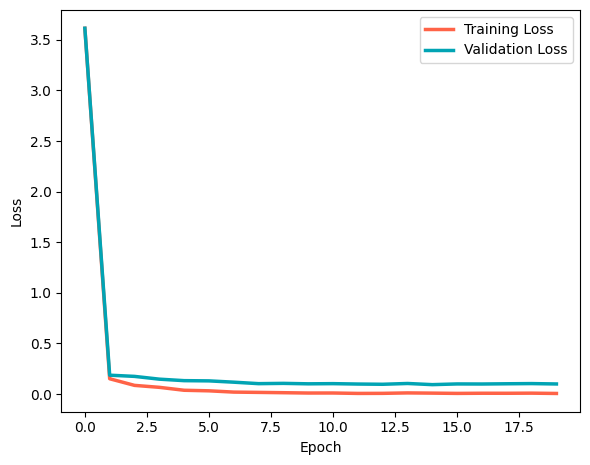

                            precision    recall  f1-score   support

                Abyssinian       0.95      0.92      0.93        98
          American Bulldog       0.82      0.95      0.88       100
 American Pit Bull Terrier       0.89      0.54      0.67       100
              Basset Hound       1.00      0.97      0.98       100
                    Beagle       0.97      0.98      0.98       100
                    Bengal       0.85      0.94      0.89       100
                    Birman       0.81      0.89      0.85       100
                    Bombay       0.85      0.98      0.91        88
                     Boxer       0.92      0.92      0.92        99
         British Shorthair       0.98      0.86      0.91       100
                 Chihuahua       0.91      0.96      0.94       100
              Egyptian Mau       0.89      0.94      0.91        97
    English Cocker Spaniel       1.00      1.00      1.00       100
            English Setter       1.00      0.99

In [ ]:
testing = [(5e-3, 4, 6, 1)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    for i in range(5):
        print(f"RUN {i}")
        print(f"Training with parameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Unfreeze Interval: {unfreeze_interval}")
        print(f"  Reduce Learning Rate: {reduce_learning_rate}")
        print(f"  Training Mode: {training_mode}")
        train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
        train.train()
        train.evaluate(train.val_loader)
        train.evaluate(train.test_loader)
        train.plot_loss_curves()
        train.classification_report()
        print("-" * 40)


RUN 0
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.162624 	 Validation Loss: 0.203435


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.109402 	 Validation Loss: 0.174496


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.039881 	 Validation Loss: 0.137174


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.046387 	 Validation Loss: 0.146791
Accuracy of Val: 0.9511
Accuracy of Test: 0.9289


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.031115 	 Validation Loss: 0.161222


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.016094 	 Validation Loss: 0.136759


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.014344 	 Validation Loss: 0.122049


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.009170 	 Validation Loss: 0.121118
Accuracy of Val: 0.9592
Accuracy of Test: 0.9428


Epoch 9/24: 100%|██████████| 184/184 [01:25<00:00,  2.16batch/s]


Epoch 9, Training Loss: 0.005732 	 Validation Loss: 0.116473


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.007080 	 Validation Loss: 0.108120


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.16batch/s]


Epoch 11, Training Loss: 0.011037 	 Validation Loss: 0.116138


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 12, Training Loss: 0.010341 	 Validation Loss: 0.114952
Accuracy of Val: 0.9579
Accuracy of Test: 0.9425


Epoch 13/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 13, Training Loss: 0.006319 	 Validation Loss: 0.114039


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.005676 	 Validation Loss: 0.115110


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.0062 	 Validation Loss: 0.1113. Early stopping triggered
Training finished in 2565.62 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9428


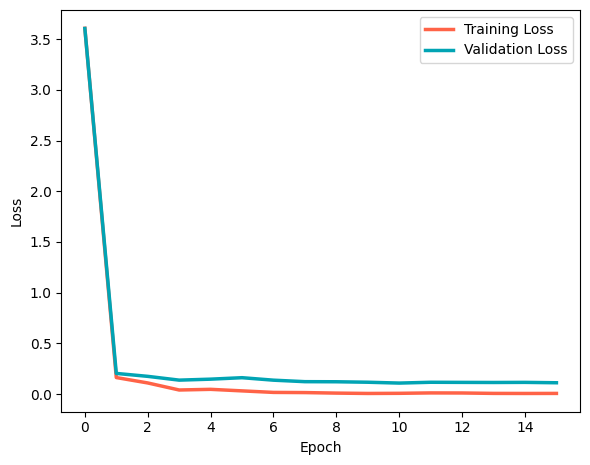

                            precision    recall  f1-score   support

                Abyssinian       0.98      0.96      0.97        98
          American Bulldog       0.82      0.88      0.85       100
 American Pit Bull Terrier       0.91      0.60      0.72       100
              Basset Hound       0.99      0.95      0.97       100
                    Beagle       0.93      0.96      0.95       100
                    Bengal       0.82      0.93      0.87       100
                    Birman       0.83      0.92      0.87       100
                    Bombay       0.87      1.00      0.93        88
                     Boxer       0.91      0.94      0.93        99
         British Shorthair       0.99      0.90      0.94       100
                 Chihuahua       0.92      0.95      0.94       100
              Egyptian Mau       0.90      0.90      0.90        97
    English Cocker Spaniel       1.00      0.98      0.99       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 1, Training Loss: 0.139097 	 Validation Loss: 0.198087


Epoch 2/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 2, Training Loss: 0.115664 	 Validation Loss: 0.222223


Epoch 3/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 3, Training Loss: 0.055310 	 Validation Loss: 0.142072


Epoch 4/24: 100%|██████████| 184/184 [01:23<00:00,  2.19batch/s]


Epoch 4, Training Loss: 0.043205 	 Validation Loss: 0.167852
Accuracy of Val: 0.9416
Accuracy of Test: 0.9300


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.19batch/s]


Epoch 5, Training Loss: 0.027789 	 Validation Loss: 0.172853


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 6, Training Loss: 0.023483 	 Validation Loss: 0.151566


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.015617 	 Validation Loss: 0.129532


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 8, Training Loss: 0.013660 	 Validation Loss: 0.126326
Accuracy of Val: 0.9579
Accuracy of Test: 0.9409


Epoch 9/24: 100%|██████████| 184/184 [01:25<00:00,  2.16batch/s]


Epoch 9, Training Loss: 0.007318 	 Validation Loss: 0.120963


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.012788 	 Validation Loss: 0.120257


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.16batch/s]


Epoch 11, Training Loss: 0.008133 	 Validation Loss: 0.127564


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 12, Training Loss: 0.006942 	 Validation Loss: 0.126306
Accuracy of Val: 0.9620
Accuracy of Test: 0.9403


Epoch 13/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 13, Training Loss: 0.007978 	 Validation Loss: 0.123069


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.005702 	 Validation Loss: 0.119182


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.006360 	 Validation Loss: 0.121378


Epoch 16/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 16, Training Loss: 0.005401 	 Validation Loss: 0.122119
Accuracy of Val: 0.9606
Accuracy of Test: 0.9392


Epoch 17/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 17, Training Loss: 0.010424 	 Validation Loss: 0.124752


Epoch 18/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 18, Training Loss: 0.005465 	 Validation Loss: 0.124984


Epoch 19/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 19, Training Loss: 0.0089 	 Validation Loss: 0.1322. Early stopping triggered
Training finished in 3268.02 seconds
Accuracy of Val: 0.9552
Accuracy of Test: 0.9381


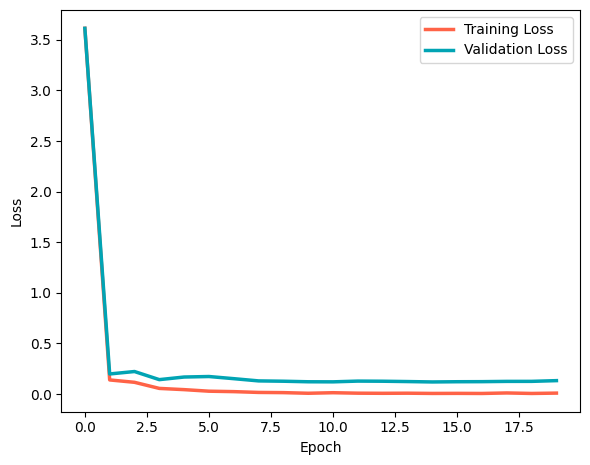

                            precision    recall  f1-score   support

                Abyssinian       0.98      0.93      0.95        98
          American Bulldog       0.86      0.93      0.89       100
 American Pit Bull Terrier       0.86      0.55      0.67       100
              Basset Hound       0.97      0.96      0.96       100
                    Beagle       0.96      0.96      0.96       100
                    Bengal       0.82      0.95      0.88       100
                    Birman       0.80      0.82      0.81       100
                    Bombay       0.86      0.97      0.91        88
                     Boxer       0.90      0.94      0.92        99
         British Shorthair       0.97      0.85      0.90       100
                 Chihuahua       0.92      0.95      0.94       100
              Egyptian Mau       0.90      0.92      0.91        97
    English Cocker Spaniel       0.98      0.99      0.99       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.152414 	 Validation Loss: 0.221591


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.078547 	 Validation Loss: 0.165280


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.049871 	 Validation Loss: 0.146455


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.034942 	 Validation Loss: 0.139068
Accuracy of Val: 0.9538
Accuracy of Test: 0.9272


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.050896 	 Validation Loss: 0.194454


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.030881 	 Validation Loss: 0.187534


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.015389 	 Validation Loss: 0.156009


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.011599 	 Validation Loss: 0.146272
Accuracy of Val: 0.9538
Accuracy of Test: 0.9381


Epoch 9/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 9, Training Loss: 0.0086 	 Validation Loss: 0.1435. Early stopping triggered
Training finished in 1553.42 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9395


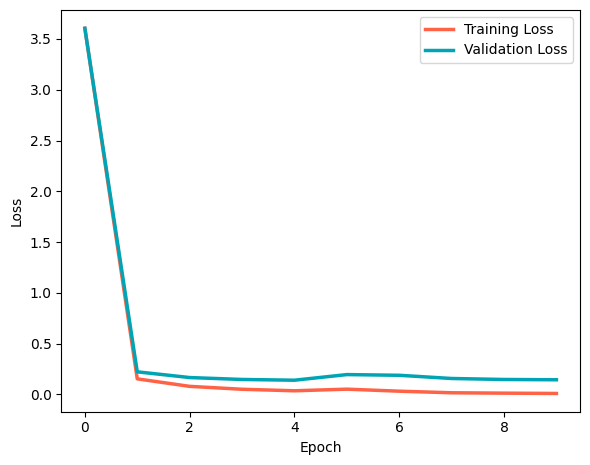

                            precision    recall  f1-score   support

                Abyssinian       0.94      0.93      0.93        98
          American Bulldog       0.80      0.91      0.85       100
 American Pit Bull Terrier       0.86      0.62      0.72       100
              Basset Hound       1.00      0.95      0.97       100
                    Beagle       0.95      0.98      0.97       100
                    Bengal       0.81      0.91      0.86       100
                    Birman       0.82      0.86      0.84       100
                    Bombay       0.87      1.00      0.93        88
                     Boxer       0.90      0.93      0.92        99
         British Shorthair       1.00      0.82      0.90       100
                 Chihuahua       0.94      0.95      0.95       100
              Egyptian Mau       0.88      0.96      0.92        97
    English Cocker Spaniel       0.99      0.97      0.98       100
            English Setter       0.99      0.99

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.150159 	 Validation Loss: 0.189071


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.078436 	 Validation Loss: 0.158445


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.045825 	 Validation Loss: 0.135882


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.041215 	 Validation Loss: 0.141267
Accuracy of Val: 0.9484
Accuracy of Test: 0.9267


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.036890 	 Validation Loss: 0.178202


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.022641 	 Validation Loss: 0.163341


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.010040 	 Validation Loss: 0.145827


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.008586 	 Validation Loss: 0.133184
Accuracy of Val: 0.9484
Accuracy of Test: 0.9381


Epoch 9/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 9, Training Loss: 0.008879 	 Validation Loss: 0.132910


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.007698 	 Validation Loss: 0.133113


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 11, Training Loss: 0.007597 	 Validation Loss: 0.135313


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 12, Training Loss: 0.005449 	 Validation Loss: 0.128538
Accuracy of Val: 0.9524
Accuracy of Test: 0.9392


Epoch 13/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 13, Training Loss: 0.005449 	 Validation Loss: 0.134447


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.006974 	 Validation Loss: 0.134021


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.005916 	 Validation Loss: 0.127686


Epoch 16/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 16, Training Loss: 0.006895 	 Validation Loss: 0.124931
Accuracy of Val: 0.9552
Accuracy of Test: 0.9379


Epoch 17/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 17, Training Loss: 0.005470 	 Validation Loss: 0.128922


Epoch 18/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 18, Training Loss: 0.004759 	 Validation Loss: 0.130876


Epoch 19/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 19, Training Loss: 0.004761 	 Validation Loss: 0.128912


Epoch 20/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 20, Training Loss: 0.004291 	 Validation Loss: 0.129708
Accuracy of Val: 0.9538
Accuracy of Test: 0.9389


Epoch 21/24: 100%|██████████| 184/184 [01:27<00:00,  2.10batch/s]


Epoch 21, Training Loss: 0.0059 	 Validation Loss: 0.1329. Early stopping triggered
Training finished in 3650.81 seconds
Accuracy of Val: 0.9565
Accuracy of Test: 0.9387


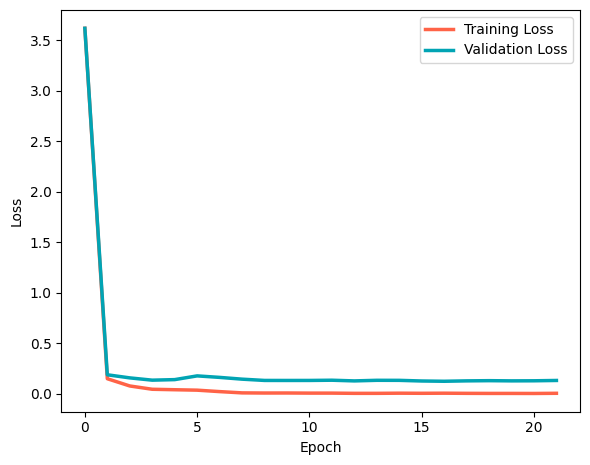

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.96      0.94        98
          American Bulldog       0.79      0.94      0.86       100
 American Pit Bull Terrier       0.89      0.55      0.68       100
              Basset Hound       0.98      0.98      0.98       100
                    Beagle       0.98      0.97      0.97       100
                    Bengal       0.82      0.90      0.86       100
                    Birman       0.81      0.86      0.83       100
                    Bombay       0.93      1.00      0.96        88
                     Boxer       0.90      0.92      0.91        99
         British Shorthair       0.99      0.82      0.90       100
                 Chihuahua       0.90      0.95      0.93       100
              Egyptian Mau       0.88      0.91      0.89        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.98

Epoch 1/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 1, Training Loss: 0.144197 	 Validation Loss: 0.247271


Epoch 2/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 2, Training Loss: 0.080066 	 Validation Loss: 0.184485


Epoch 3/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 3, Training Loss: 0.049006 	 Validation Loss: 0.171496


Epoch 4/24: 100%|██████████| 184/184 [01:24<00:00,  2.18batch/s]


Epoch 4, Training Loss: 0.026169 	 Validation Loss: 0.160995
Accuracy of Val: 0.9402
Accuracy of Test: 0.9289


Epoch 5/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 5, Training Loss: 0.046347 	 Validation Loss: 0.221917


Epoch 6/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 6, Training Loss: 0.025740 	 Validation Loss: 0.224276


Epoch 7/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 7, Training Loss: 0.009235 	 Validation Loss: 0.167090


Epoch 8/24: 100%|██████████| 184/184 [01:24<00:00,  2.17batch/s]


Epoch 8, Training Loss: 0.007791 	 Validation Loss: 0.158572
Accuracy of Val: 0.9524
Accuracy of Test: 0.9403


Epoch 9/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 9, Training Loss: 0.012478 	 Validation Loss: 0.171030


Epoch 10/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 10, Training Loss: 0.008279 	 Validation Loss: 0.161591


Epoch 11/24: 100%|██████████| 184/184 [01:25<00:00,  2.15batch/s]


Epoch 11, Training Loss: 0.003901 	 Validation Loss: 0.155208


Epoch 12/24: 100%|██████████| 184/184 [01:25<00:00,  2.14batch/s]


Epoch 12, Training Loss: 0.006244 	 Validation Loss: 0.148931
Accuracy of Val: 0.9552
Accuracy of Test: 0.9406


Epoch 13/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 13, Training Loss: 0.008017 	 Validation Loss: 0.145882


Epoch 14/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 14, Training Loss: 0.004749 	 Validation Loss: 0.147567


Epoch 15/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 15, Training Loss: 0.005273 	 Validation Loss: 0.149817


Epoch 16/24: 100%|██████████| 184/184 [01:26<00:00,  2.13batch/s]


Epoch 16, Training Loss: 0.003951 	 Validation Loss: 0.149942
Accuracy of Val: 0.9497
Accuracy of Test: 0.9428


Epoch 17/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 17, Training Loss: 0.005193 	 Validation Loss: 0.155494


Epoch 18/24: 100%|██████████| 184/184 [01:27<00:00,  2.11batch/s]


Epoch 18, Training Loss: 0.0043 	 Validation Loss: 0.1507. Early stopping triggered
Training finished in 3104.07 seconds
Accuracy of Val: 0.9524
Accuracy of Test: 0.9433


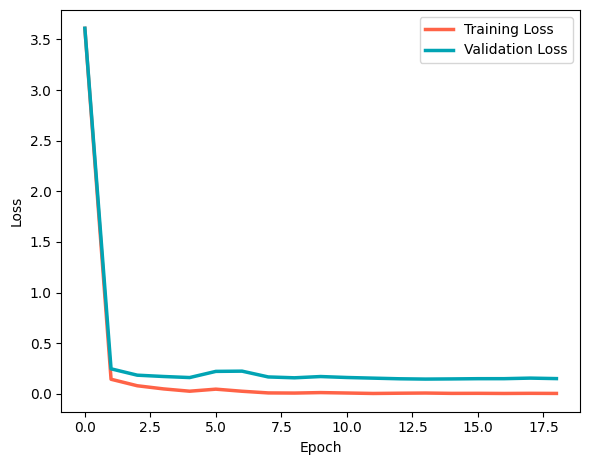

                            precision    recall  f1-score   support

                Abyssinian       0.95      0.93      0.94        98
          American Bulldog       0.81      0.96      0.88       100
 American Pit Bull Terrier       0.92      0.58      0.71       100
              Basset Hound       0.98      0.95      0.96       100
                    Beagle       0.95      0.96      0.96       100
                    Bengal       0.85      0.94      0.90       100
                    Birman       0.81      0.89      0.85       100
                    Bombay       0.89      0.99      0.94        88
                     Boxer       0.96      0.94      0.95        99
         British Shorthair       0.99      0.87      0.93       100
                 Chihuahua       0.92      0.97      0.95       100
              Egyptian Mau       0.90      0.95      0.92        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Setter       1.00      0.96

In [ ]:
testing = [(5e-3, 4, 6, 2)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    for i in range(5):
        print(f"RUN {i}")
        print(f"Training with parameters:")
        print(f"  Learning Rate: {lr}")
        print(f"  Unfreeze Interval: {unfreeze_interval}")
        print(f"  Reduce Learning Rate: {reduce_learning_rate}")
        print(f"  Training Mode: {training_mode}")
        train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
        train.train()
        train.evaluate(train.val_loader)
        train.evaluate(train.test_loader)
        train.plot_loss_curves()
        train.classification_report()
        print("-" * 40)


## Gammal körning


Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:56<00:00,  1.58batch/s]


Epoch 1, Training Loss: 0.864932 	 Validation Loss: 0.222815


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 2, Training Loss: 0.234405 	 Validation Loss: 0.213832


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.155177 	 Validation Loss: 0.142461


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 4, Training Loss: 0.125815 	 Validation Loss: 0.111815
Test Accuracy: 0.9365


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.117719 	 Validation Loss: 0.152616


Epoch 6/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.090745 	 Validation Loss: 0.173663


Epoch 7/32: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 7, Training Loss: 0.065862 	 Validation Loss: 0.104847


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.050571 	 Validation Loss: 0.100953
Test Accuracy: 0.9398


Epoch 9/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.048815 	 Validation Loss: 0.094016


Epoch 10/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.039617 	 Validation Loss: 0.096496


Epoch 11/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.041947 	 Validation Loss: 0.096650


Epoch 12/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.032343 	 Validation Loss: 0.092576
Test Accuracy: 0.9392


Epoch 13/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.034206 	 Validation Loss: 0.094306


Epoch 14/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.035854 	 Validation Loss: 0.089086


Epoch 15/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.032801 	 Validation Loss: 0.090759


Epoch 16/32: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.035473 	 Validation Loss: 0.089500
Test Accuracy: 0.9411


Epoch 17/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 17, Training Loss: 0.037429 	 Validation Loss: 0.090811


Epoch 18/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 18, Training Loss: 0.039024 	 Validation Loss: 0.090071


Epoch 19/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 19, Training Loss: 0.038269 	 Validation Loss: 0.093315


Epoch 20/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 20, Training Loss: 0.031538 	 Validation Loss: 0.093138
Test Accuracy: 0.9373


Epoch 21/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 21, Training Loss: 0.034495 	 Validation Loss: 0.090505


Epoch 22/32: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 22, Training Loss: 0.030909 	 Validation Loss: 0.092990


Epoch 23/32: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 23, Training Loss: 0.035640 	 Validation Loss: 0.094090


Epoch 24/32: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 24, Training Loss: 0.0378 	 Validation Loss: 0.0934. Early stopping triggered
Training finished in 3367.28 seconds
Test Accuracy: 0.9387


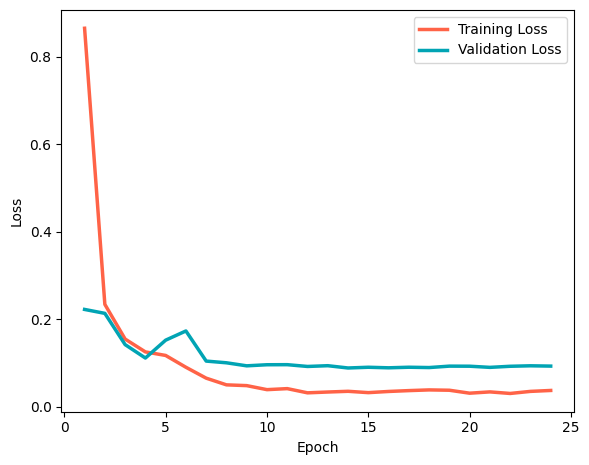

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 0.879453 	 Validation Loss: 0.184605


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.226364 	 Validation Loss: 0.137971


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.169589 	 Validation Loss: 0.135123


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.131054 	 Validation Loss: 0.140294
Test Accuracy: 0.9289


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.109882 	 Validation Loss: 0.149824


Epoch 6/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 6, Training Loss: 0.096794 	 Validation Loss: 0.144668


Epoch 7/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.074673 	 Validation Loss: 0.113138


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.055266 	 Validation Loss: 0.105037
Test Accuracy: 0.9373


Epoch 9/32: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.045015 	 Validation Loss: 0.103398


Epoch 10/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 10, Training Loss: 0.041128 	 Validation Loss: 0.104032


Epoch 11/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.038076 	 Validation Loss: 0.114497


Epoch 12/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.032726 	 Validation Loss: 0.105764
Test Accuracy: 0.9400


Epoch 13/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.024421 	 Validation Loss: 0.103634


Epoch 14/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.032933 	 Validation Loss: 0.099887


Epoch 15/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.035417 	 Validation Loss: 0.108846


Epoch 16/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.028266 	 Validation Loss: 0.102131
Test Accuracy: 0.9403


Epoch 17/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 17, Training Loss: 0.032339 	 Validation Loss: 0.103224


Epoch 18/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 18, Training Loss: 0.032680 	 Validation Loss: 0.101508


Epoch 19/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 19, Training Loss: 0.027314 	 Validation Loss: 0.107179


Epoch 20/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 20, Training Loss: 0.031724 	 Validation Loss: 0.107250
Test Accuracy: 0.9381


Epoch 21/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 21, Training Loss: 0.033667 	 Validation Loss: 0.103327


Epoch 22/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 22, Training Loss: 0.033144 	 Validation Loss: 0.102715


Epoch 23/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 23, Training Loss: 0.029977 	 Validation Loss: 0.101811


Epoch 24/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 24, Training Loss: 0.0390 	 Validation Loss: 0.1041. Early stopping triggered
Training finished in 3373.74 seconds
Test Accuracy: 0.9406


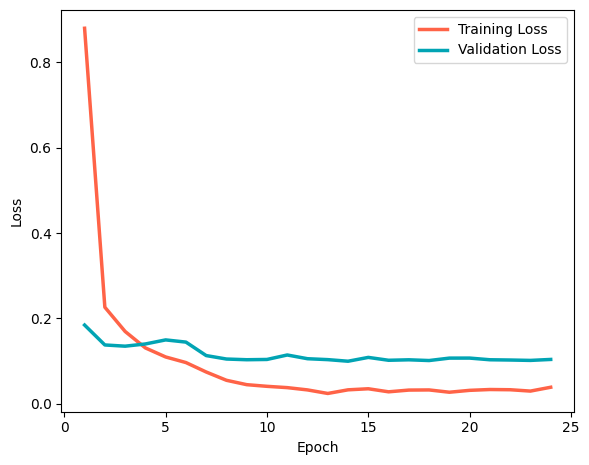

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 0.882650 	 Validation Loss: 0.210465


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 2, Training Loss: 0.241054 	 Validation Loss: 0.167333


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.178746 	 Validation Loss: 0.189207


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 4, Training Loss: 0.116203 	 Validation Loss: 0.205117
Test Accuracy: 0.9253


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.087246 	 Validation Loss: 0.139698


Epoch 6/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 6, Training Loss: 0.067215 	 Validation Loss: 0.117893


Epoch 7/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.062594 	 Validation Loss: 0.117804


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.056525 	 Validation Loss: 0.115294
Test Accuracy: 0.9389


Epoch 9/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 9, Training Loss: 0.052295 	 Validation Loss: 0.117078


Epoch 10/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 10, Training Loss: 0.055487 	 Validation Loss: 0.116710


Epoch 11/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.052799 	 Validation Loss: 0.116698


Epoch 12/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.052499 	 Validation Loss: 0.113593
Test Accuracy: 0.9379


Epoch 13/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.047342 	 Validation Loss: 0.119880


Epoch 14/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.060193 	 Validation Loss: 0.116349


Epoch 15/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.061482 	 Validation Loss: 0.119852


Epoch 16/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.052400 	 Validation Loss: 0.114635
Test Accuracy: 0.9381


Epoch 17/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 17, Training Loss: 0.056900 	 Validation Loss: 0.122537


Epoch 18/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 18, Training Loss: 0.060655 	 Validation Loss: 0.120408


Epoch 19/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 19, Training Loss: 0.059676 	 Validation Loss: 0.113945


Epoch 20/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 20, Training Loss: 0.057826 	 Validation Loss: 0.115121
Test Accuracy: 0.9368


Epoch 21/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 21, Training Loss: 0.063303 	 Validation Loss: 0.119319


Epoch 22/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 22, Training Loss: 0.0604 	 Validation Loss: 0.1172. Early stopping triggered
Training finished in 3124.83 seconds
Test Accuracy: 0.9392


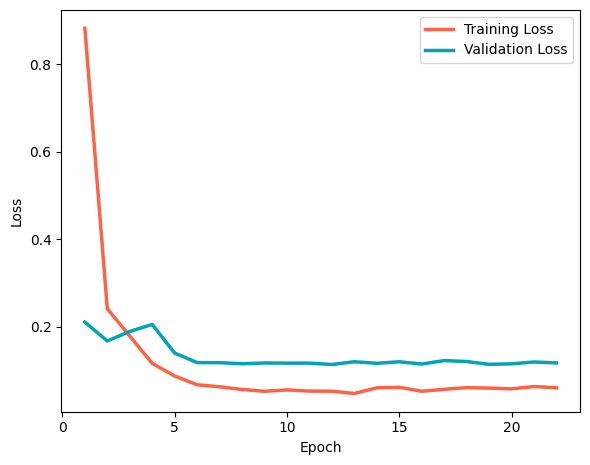

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 1, Training Loss: 0.852281 	 Validation Loss: 0.211470


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.227628 	 Validation Loss: 0.173625


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.164115 	 Validation Loss: 0.132107


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.112236 	 Validation Loss: 0.150155
Test Accuracy: 0.9242


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.123126 	 Validation Loss: 0.130787


Epoch 6/32: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 6, Training Loss: 0.106468 	 Validation Loss: 0.202206


Epoch 7/32: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 7, Training Loss: 0.069800 	 Validation Loss: 0.147270


Epoch 8/32: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 8, Training Loss: 0.042054 	 Validation Loss: 0.133294
Test Accuracy: 0.9387


Epoch 9/32: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 9, Training Loss: 0.046185 	 Validation Loss: 0.136044


Epoch 10/32: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 10, Training Loss: 0.043180 	 Validation Loss: 0.134662


Epoch 11/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 11, Training Loss: 0.034103 	 Validation Loss: 0.125958


Epoch 12/32: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 12, Training Loss: 0.033717 	 Validation Loss: 0.127843
Test Accuracy: 0.9425


Epoch 13/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 13, Training Loss: 0.035304 	 Validation Loss: 0.128278


Epoch 14/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 14, Training Loss: 0.032287 	 Validation Loss: 0.129115


Epoch 15/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 15, Training Loss: 0.031402 	 Validation Loss: 0.129917


Epoch 16/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 16, Training Loss: 0.042459 	 Validation Loss: 0.129152
Test Accuracy: 0.9439


Epoch 17/32: 100%|██████████| 184/184 [01:56<00:00,  1.58batch/s]


Epoch 17, Training Loss: 0.033772 	 Validation Loss: 0.123680


Epoch 18/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 18, Training Loss: 0.032078 	 Validation Loss: 0.123963


Epoch 19/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 19, Training Loss: 0.028456 	 Validation Loss: 0.123704


Epoch 20/32: 100%|██████████| 184/184 [01:56<00:00,  1.58batch/s]


Epoch 20, Training Loss: 0.029132 	 Validation Loss: 0.124655
Test Accuracy: 0.9444


Epoch 21/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 21, Training Loss: 0.032457 	 Validation Loss: 0.127751


Epoch 22/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 22, Training Loss: 0.031180 	 Validation Loss: 0.125521


Epoch 23/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 23, Training Loss: 0.030403 	 Validation Loss: 0.123059


Epoch 24/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 24, Training Loss: 0.027836 	 Validation Loss: 0.127342
Test Accuracy: 0.9419


Epoch 25/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 25, Training Loss: 0.029746 	 Validation Loss: 0.125291


Epoch 26/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 26, Training Loss: 0.027564 	 Validation Loss: 0.126061


Epoch 27/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 27, Training Loss: 0.027268 	 Validation Loss: 0.128264


Epoch 28/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 28, Training Loss: 0.034216 	 Validation Loss: 0.127184
Test Accuracy: 0.9430


Epoch 29/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 29, Training Loss: 0.030406 	 Validation Loss: 0.128328


Epoch 30/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 30, Training Loss: 0.028906 	 Validation Loss: 0.131134


Epoch 31/32: 100%|██████████| 184/184 [01:56<00:00,  1.59batch/s]


Epoch 31, Training Loss: 0.029163 	 Validation Loss: 0.119493


Epoch 32/32: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 32, Training Loss: 0.029418 	 Validation Loss: 0.124413
Test Accuracy: 0.9430
Training finished in 4608.86 seconds
Test Accuracy: 0.9430


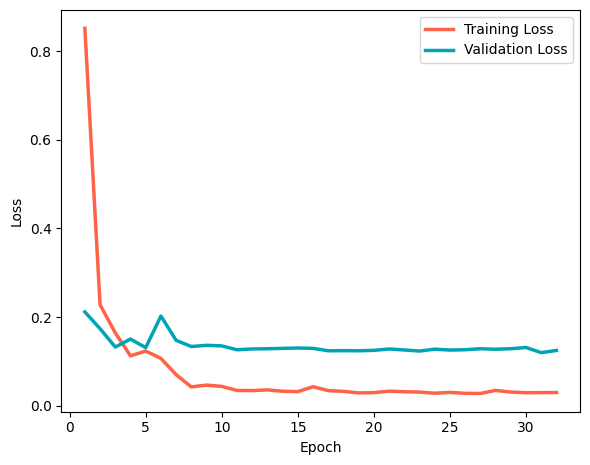

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 1, Training Loss: 0.891652 	 Validation Loss: 0.180201


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 2, Training Loss: 0.217584 	 Validation Loss: 0.167068


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.168579 	 Validation Loss: 0.115956


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.119254 	 Validation Loss: 0.096602
Test Accuracy: 0.9332


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.102902 	 Validation Loss: 0.094615


Epoch 6/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.078337 	 Validation Loss: 0.088351


Epoch 7/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.061967 	 Validation Loss: 0.084699


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.048241 	 Validation Loss: 0.076765
Test Accuracy: 0.9392


Epoch 9/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.048307 	 Validation Loss: 0.078623


Epoch 10/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.045127 	 Validation Loss: 0.073275


Epoch 11/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.037003 	 Validation Loss: 0.082579


Epoch 12/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.043632 	 Validation Loss: 0.088278
Test Accuracy: 0.9441


Epoch 13/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 13, Training Loss: 0.034072 	 Validation Loss: 0.081813


Epoch 14/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 14, Training Loss: 0.040989 	 Validation Loss: 0.081899


Epoch 15/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 15, Training Loss: 0.044092 	 Validation Loss: 0.079584


Epoch 16/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.034560 	 Validation Loss: 0.077183
Test Accuracy: 0.9430


Epoch 17/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 17, Training Loss: 0.037752 	 Validation Loss: 0.078478


Epoch 18/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 18, Training Loss: 0.032515 	 Validation Loss: 0.075410


Epoch 19/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 19, Training Loss: 0.041237 	 Validation Loss: 0.080374


Epoch 20/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 20, Training Loss: 0.0351 	 Validation Loss: 0.0852. Early stopping triggered
Training finished in 2765.00 seconds
Test Accuracy: 0.9422


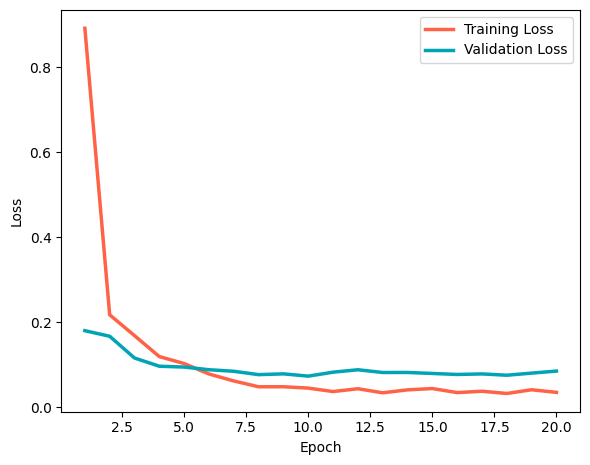

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 2
  Training Mode: 1
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 0.922569 	 Validation Loss: 0.197278


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.237808 	 Validation Loss: 0.129832


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.157346 	 Validation Loss: 0.134946


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 4, Training Loss: 0.108817 	 Validation Loss: 0.131494
Test Accuracy: 0.9169


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.084849 	 Validation Loss: 0.104551


Epoch 6/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.074254 	 Validation Loss: 0.103888


Epoch 7/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.065995 	 Validation Loss: 0.099495


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.068992 	 Validation Loss: 0.101936
Test Accuracy: 0.9430


Epoch 9/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.068420 	 Validation Loss: 0.099911


Epoch 10/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.062113 	 Validation Loss: 0.100974


Epoch 11/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.062694 	 Validation Loss: 0.104279


Epoch 12/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.065230 	 Validation Loss: 0.102307
Test Accuracy: 0.9362


Epoch 13/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.067002 	 Validation Loss: 0.101718


Epoch 14/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 14, Training Loss: 0.074960 	 Validation Loss: 0.104385


Epoch 15/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 15, Training Loss: 0.061202 	 Validation Loss: 0.104808


Epoch 16/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 16, Training Loss: 0.058468 	 Validation Loss: 0.104317
Test Accuracy: 0.9370


Epoch 17/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 17, Training Loss: 0.071670 	 Validation Loss: 0.097118


Epoch 18/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 18, Training Loss: 0.065085 	 Validation Loss: 0.105466


Epoch 19/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 19, Training Loss: 0.071464 	 Validation Loss: 0.103473


Epoch 20/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 20, Training Loss: 0.075120 	 Validation Loss: 0.101694
Test Accuracy: 0.9387


Epoch 21/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 21, Training Loss: 0.066373 	 Validation Loss: 0.101285


Epoch 22/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 22, Training Loss: 0.066179 	 Validation Loss: 0.100453


Epoch 23/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 23, Training Loss: 0.066585 	 Validation Loss: 0.101778


Epoch 24/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 24, Training Loss: 0.072997 	 Validation Loss: 0.103227
Test Accuracy: 0.9384


Epoch 25/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 25, Training Loss: 0.060854 	 Validation Loss: 0.101948


Epoch 26/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 26, Training Loss: 0.067806 	 Validation Loss: 0.102222


Epoch 27/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 27, Training Loss: 0.0608 	 Validation Loss: 0.0976. Early stopping triggered
Training finished in 3772.94 seconds
Test Accuracy: 0.9384


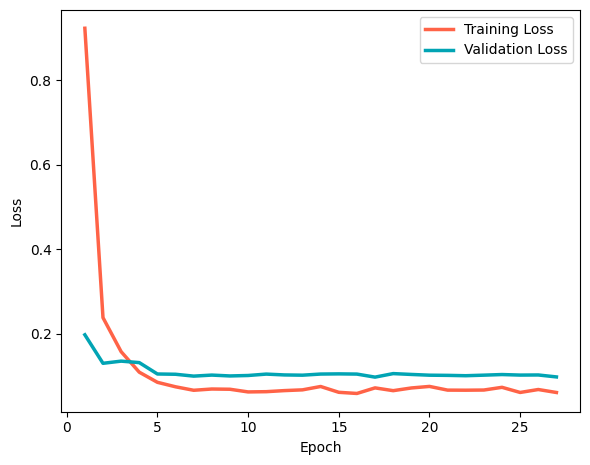

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 1, Training Loss: 0.872137 	 Validation Loss: 0.197523


Epoch 2/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 2, Training Loss: 0.228276 	 Validation Loss: 0.150650


Epoch 3/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.160207 	 Validation Loss: 0.153601


Epoch 4/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 4, Training Loss: 0.125435 	 Validation Loss: 0.162342
Test Accuracy: 0.9289


Epoch 5/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.102221 	 Validation Loss: 0.123336


Epoch 6/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 6, Training Loss: 0.080782 	 Validation Loss: 0.153137


Epoch 7/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.050474 	 Validation Loss: 0.132473


Epoch 8/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.058199 	 Validation Loss: 0.131676
Test Accuracy: 0.9414


Epoch 9/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.057312 	 Validation Loss: 0.126848


Epoch 10/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.043381 	 Validation Loss: 0.123522


Epoch 11/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.045029 	 Validation Loss: 0.123585


Epoch 12/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.037994 	 Validation Loss: 0.128143
Test Accuracy: 0.9403


Epoch 13/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 13, Training Loss: 0.034664 	 Validation Loss: 0.120318


Epoch 14/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 14, Training Loss: 0.036435 	 Validation Loss: 0.118114


Epoch 15/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 15, Training Loss: 0.036769 	 Validation Loss: 0.118605


Epoch 16/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.034409 	 Validation Loss: 0.118665
Test Accuracy: 0.9411


Epoch 17/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 17, Training Loss: 0.033375 	 Validation Loss: 0.120458


Epoch 18/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 18, Training Loss: 0.033324 	 Validation Loss: 0.118853


Epoch 19/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 19, Training Loss: 0.038321 	 Validation Loss: 0.119332


Epoch 20/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 20, Training Loss: 0.032871 	 Validation Loss: 0.120160
Test Accuracy: 0.9411


Epoch 21/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 21, Training Loss: 0.034442 	 Validation Loss: 0.117238


Epoch 22/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 22, Training Loss: 0.031811 	 Validation Loss: 0.115634


Epoch 23/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 23, Training Loss: 0.039659 	 Validation Loss: 0.116580


Epoch 24/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 24, Training Loss: 0.031849 	 Validation Loss: 0.115401
Test Accuracy: 0.9409


Epoch 25/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 25, Training Loss: 0.033290 	 Validation Loss: 0.117805


Epoch 26/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 26, Training Loss: 0.035277 	 Validation Loss: 0.115883


Epoch 27/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 27, Training Loss: 0.036848 	 Validation Loss: 0.117997


Epoch 28/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 28, Training Loss: 0.039596 	 Validation Loss: 0.118266
Test Accuracy: 0.9417


Epoch 29/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 29, Training Loss: 0.031756 	 Validation Loss: 0.113801


Epoch 30/32: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 30, Training Loss: 0.041163 	 Validation Loss: 0.120701


Epoch 31/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 31, Training Loss: 0.036586 	 Validation Loss: 0.124633


Epoch 32/32: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 32, Training Loss: 0.038270 	 Validation Loss: 0.118964
Test Accuracy: 0.9406
Training finished in 4537.74 seconds
Test Accuracy: 0.9406


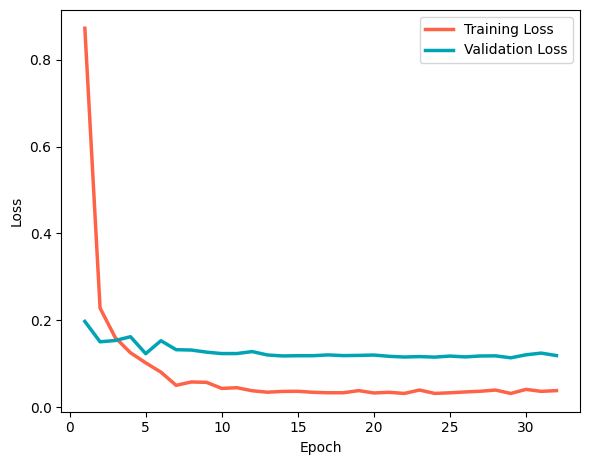

----------------------------------------


In [ ]:
testing = [(5e-3, 6, 6, 2), (5e-3, 4, 6, 2), (5e-3, 4, 2, 2), (5e-3, 2, 6, 2), (5e-3, 4, 6, 1), (5e-3, 2, 2, 1), (5e-3, 2, 6, 1)]

for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    print(f"Training with parameters:")
    print(f"  Learning Rate: {lr}")
    print(f"  Unfreeze Interval: {unfreeze_interval}")
    print(f"  Reduce Learning Rate: {reduce_learning_rate}")
    print(f"  Training Mode: {training_mode}")
    train = Train(lr=lr, bs=16, epochs=32, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
    train.train()
    train.evaluate()
    train.plot_loss_curves()
    print("-" * 40)

Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.894645 	 Validation Loss: 0.183889


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.231917 	 Validation Loss: 0.150645


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.170599 	 Validation Loss: 0.143972


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.122059 	 Validation Loss: 0.107903
Test Accuracy: 0.9321


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.078201 	 Validation Loss: 0.085445


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.073673 	 Validation Loss: 0.090494


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.057936 	 Validation Loss: 0.091637


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.059914 	 Validation Loss: 0.086174
Test Accuracy: 0.9379


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.052579 	 Validation Loss: 0.085512


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.060962 	 Validation Loss: 0.089792


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.060507 	 Validation Loss: 0.086133


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.065652 	 Validation Loss: 0.085161
Test Accuracy: 0.9373


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.049438 	 Validation Loss: 0.090164


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.064067 	 Validation Loss: 0.078320


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.061597 	 Validation Loss: 0.091491


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.057188 	 Validation Loss: 0.092307
Test Accuracy: 0.9365
Training finished in 2265.36 seconds
Test Accuracy: 0.9365


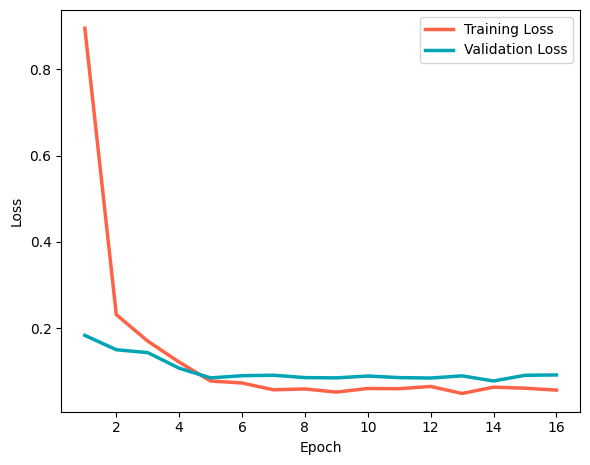

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.872004 	 Validation Loss: 0.158227


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.218420 	 Validation Loss: 0.152351


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.168825 	 Validation Loss: 0.114207


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.122650 	 Validation Loss: 0.112028
Test Accuracy: 0.9300


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.082100 	 Validation Loss: 0.094596


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.062802 	 Validation Loss: 0.089882


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.057214 	 Validation Loss: 0.090297


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.055274 	 Validation Loss: 0.083287
Test Accuracy: 0.9379


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.050627 	 Validation Loss: 0.082013


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.050951 	 Validation Loss: 0.083477


Epoch 11/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.052677 	 Validation Loss: 0.084538


Epoch 12/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.055547 	 Validation Loss: 0.082821
Test Accuracy: 0.9362


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.051470 	 Validation Loss: 0.087547


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.054951 	 Validation Loss: 0.082374


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.049677 	 Validation Loss: 0.084694


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.051369 	 Validation Loss: 0.082475
Test Accuracy: 0.9373
Training finished in 2266.91 seconds
Test Accuracy: 0.9373


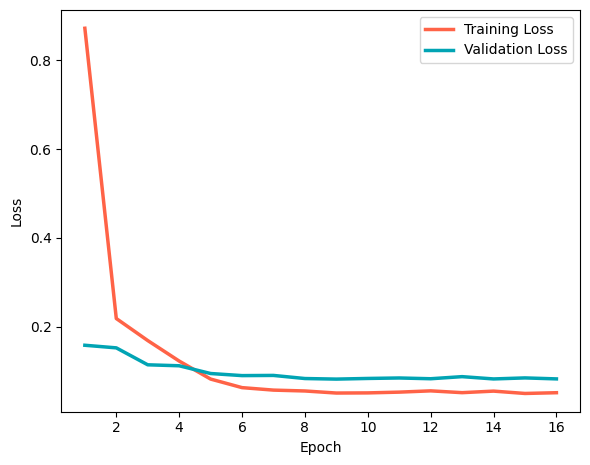

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.872777 	 Validation Loss: 0.188436


Epoch 2/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.214315 	 Validation Loss: 0.135875


Epoch 3/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.155857 	 Validation Loss: 0.120372


Epoch 4/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.131044 	 Validation Loss: 0.122568
Test Accuracy: 0.9319


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.122504 	 Validation Loss: 0.137039


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.094776 	 Validation Loss: 0.167514


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.070451 	 Validation Loss: 0.099134


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.060814 	 Validation Loss: 0.096237
Test Accuracy: 0.9384


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.050792 	 Validation Loss: 0.094968


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.044439 	 Validation Loss: 0.096819


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.047535 	 Validation Loss: 0.094836


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.044368 	 Validation Loss: 0.092632
Test Accuracy: 0.9414


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.036249 	 Validation Loss: 0.094375


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.037905 	 Validation Loss: 0.085905


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.037017 	 Validation Loss: 0.088763


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.037654 	 Validation Loss: 0.093179
Test Accuracy: 0.9439
Training finished in 2261.83 seconds
Test Accuracy: 0.9439


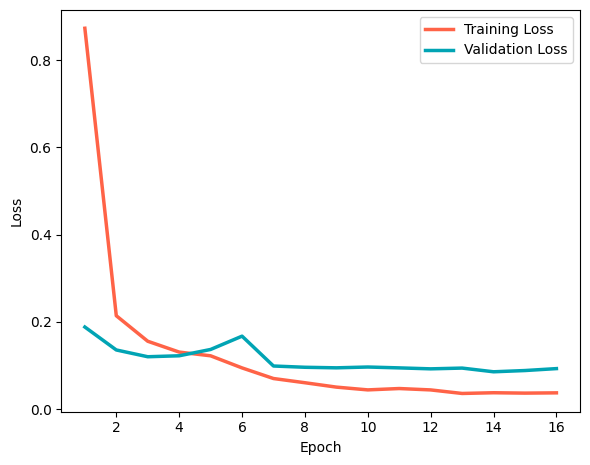

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.853379 	 Validation Loss: 0.195588


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.224866 	 Validation Loss: 0.156757


Epoch 3/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.158897 	 Validation Loss: 0.132585


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.134205 	 Validation Loss: 0.183220
Test Accuracy: 0.9316


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.090172 	 Validation Loss: 0.133993


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.072440 	 Validation Loss: 0.129256


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.062196 	 Validation Loss: 0.129454


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.051701 	 Validation Loss: 0.131494
Test Accuracy: 0.9419


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.058461 	 Validation Loss: 0.123078


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.048832 	 Validation Loss: 0.125371


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.052740 	 Validation Loss: 0.132187


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.055417 	 Validation Loss: 0.126385
Test Accuracy: 0.9411


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.056990 	 Validation Loss: 0.123509


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.065999 	 Validation Loss: 0.120402


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.061008 	 Validation Loss: 0.126521


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.059055 	 Validation Loss: 0.121749
Test Accuracy: 0.9428
Training finished in 2259.94 seconds
Test Accuracy: 0.9428


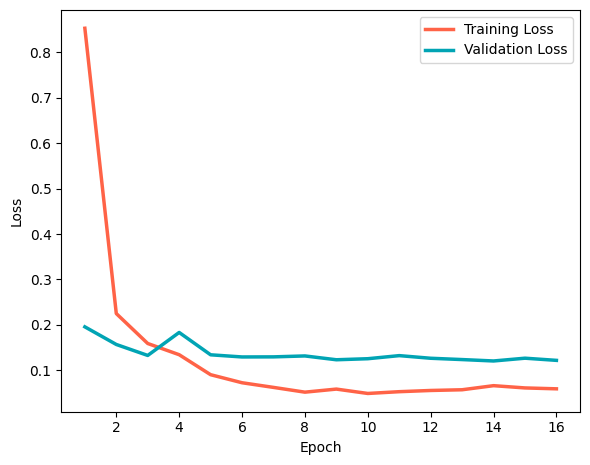

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.892753 	 Validation Loss: 0.191424


Epoch 2/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.216654 	 Validation Loss: 0.188792


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.168676 	 Validation Loss: 0.129714


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.133132 	 Validation Loss: 0.175026
Test Accuracy: 0.9201


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.092291 	 Validation Loss: 0.116732


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 6, Training Loss: 0.067586 	 Validation Loss: 0.104044


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.070216 	 Validation Loss: 0.104251


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.061853 	 Validation Loss: 0.101783
Test Accuracy: 0.9362


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.050258 	 Validation Loss: 0.098202


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.046485 	 Validation Loss: 0.101874


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.055533 	 Validation Loss: 0.095433


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.053687 	 Validation Loss: 0.096680
Test Accuracy: 0.9373


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.050176 	 Validation Loss: 0.096136


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.052637 	 Validation Loss: 0.096328


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.048810 	 Validation Loss: 0.100116


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 16, Training Loss: 0.046887 	 Validation Loss: 0.098373
Test Accuracy: 0.9362
Training finished in 2258.47 seconds
Test Accuracy: 0.9362


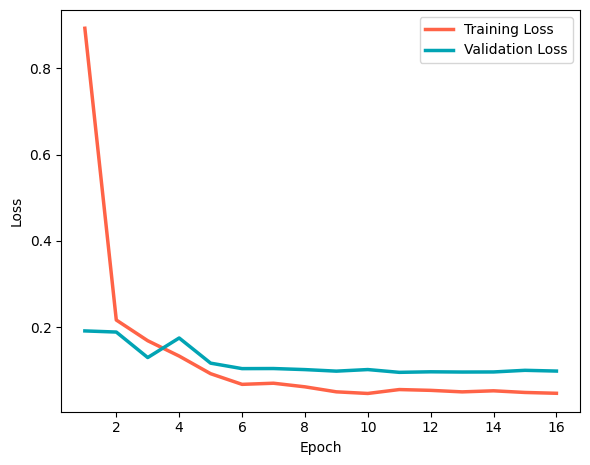

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.850977 	 Validation Loss: 0.185081


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.231688 	 Validation Loss: 0.151243


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.176145 	 Validation Loss: 0.169013


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.125079 	 Validation Loss: 0.109532
Test Accuracy: 0.9351


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.105066 	 Validation Loss: 0.142087


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.090340 	 Validation Loss: 0.119002


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.057949 	 Validation Loss: 0.102734


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.047249 	 Validation Loss: 0.100857
Test Accuracy: 0.9422


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.051375 	 Validation Loss: 0.102744


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.043590 	 Validation Loss: 0.099782


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.032832 	 Validation Loss: 0.102238


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.039933 	 Validation Loss: 0.090951
Test Accuracy: 0.9414


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.028425 	 Validation Loss: 0.090339


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.028539 	 Validation Loss: 0.096387


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.028724 	 Validation Loss: 0.091576


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.031757 	 Validation Loss: 0.093208
Test Accuracy: 0.9436
Training finished in 2268.27 seconds
Test Accuracy: 0.9436


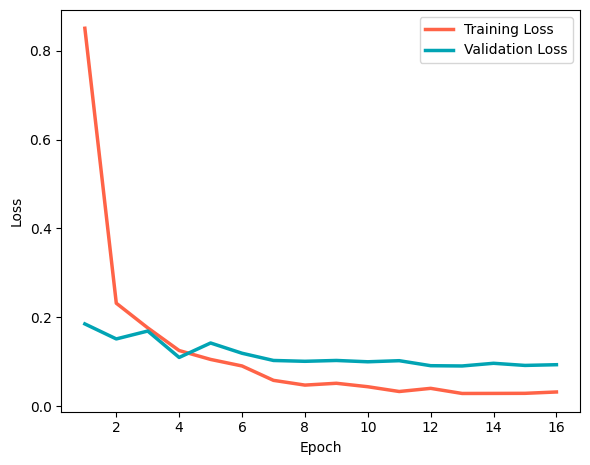

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.872390 	 Validation Loss: 0.190051


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.212621 	 Validation Loss: 0.172861


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.139727 	 Validation Loss: 0.139763


Epoch 4/16: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.130594 	 Validation Loss: 0.188404
Test Accuracy: 0.9338


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.083424 	 Validation Loss: 0.135930


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.066888 	 Validation Loss: 0.134591


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.062735 	 Validation Loss: 0.134234


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.055242 	 Validation Loss: 0.135063
Test Accuracy: 0.9422


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.052651 	 Validation Loss: 0.132744


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.061145 	 Validation Loss: 0.138030


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.063629 	 Validation Loss: 0.132963


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.062407 	 Validation Loss: 0.136336
Test Accuracy: 0.9430


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.052526 	 Validation Loss: 0.134760


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.058409 	 Validation Loss: 0.133034


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.057345 	 Validation Loss: 0.126548


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.067514 	 Validation Loss: 0.130598
Test Accuracy: 0.9441
Training finished in 2253.55 seconds
Test Accuracy: 0.9441


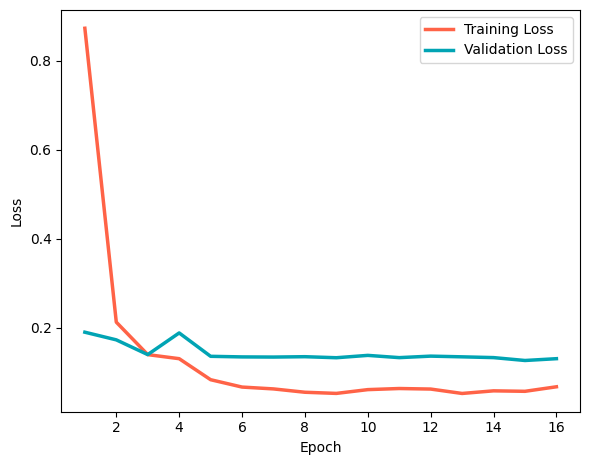

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.854693 	 Validation Loss: 0.246656


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.218348 	 Validation Loss: 0.202359


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.140428 	 Validation Loss: 0.174270


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.125033 	 Validation Loss: 0.174385
Test Accuracy: 0.9327


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.079751 	 Validation Loss: 0.163735


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.066593 	 Validation Loss: 0.148296


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.068416 	 Validation Loss: 0.140794


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.059195 	 Validation Loss: 0.137662
Test Accuracy: 0.9392


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.059262 	 Validation Loss: 0.138308


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.049294 	 Validation Loss: 0.137492


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.056526 	 Validation Loss: 0.138628


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.049682 	 Validation Loss: 0.140084
Test Accuracy: 0.9398


Epoch 13/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.048151 	 Validation Loss: 0.137536


Epoch 14/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 14, Training Loss: 0.046599 	 Validation Loss: 0.142303


Epoch 15/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.057672 	 Validation Loss: 0.141989


Epoch 16/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.051251 	 Validation Loss: 0.145232
Test Accuracy: 0.9419
Training finished in 2252.61 seconds
Test Accuracy: 0.9419


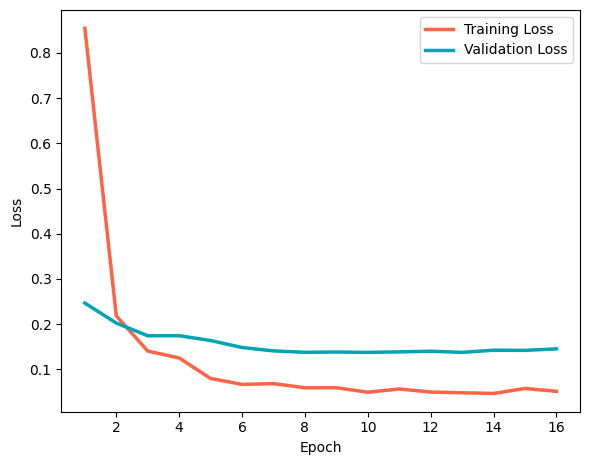

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.876828 	 Validation Loss: 0.191169


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.229620 	 Validation Loss: 0.161085


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.148749 	 Validation Loss: 0.149360


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.144839 	 Validation Loss: 0.122864
Test Accuracy: 0.9319


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.110399 	 Validation Loss: 0.142446


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.116118 	 Validation Loss: 0.139761


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.056445 	 Validation Loss: 0.114455


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.048860 	 Validation Loss: 0.108628
Test Accuracy: 0.9455


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.046679 	 Validation Loss: 0.101519


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.047735 	 Validation Loss: 0.105943


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.039945 	 Validation Loss: 0.103511


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.040818 	 Validation Loss: 0.101328
Test Accuracy: 0.9406


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.032838 	 Validation Loss: 0.102236


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.037466 	 Validation Loss: 0.095330


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.039721 	 Validation Loss: 0.098189


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.030511 	 Validation Loss: 0.101460
Test Accuracy: 0.9436
Training finished in 2258.20 seconds
Test Accuracy: 0.9436


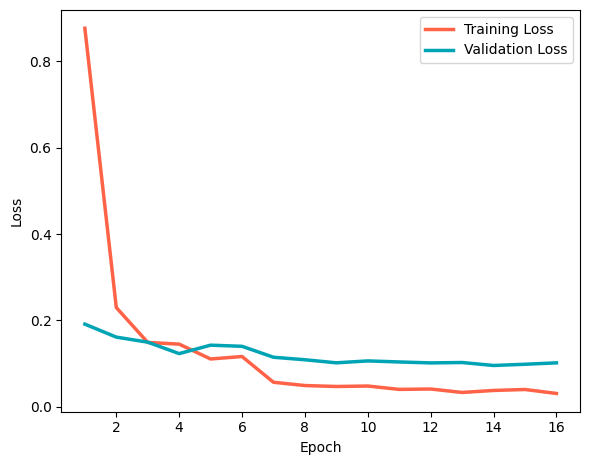

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.875146 	 Validation Loss: 0.191524


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.229389 	 Validation Loss: 0.182291


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.142004 	 Validation Loss: 0.162327


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.118904 	 Validation Loss: 0.160115
Test Accuracy: 0.9346


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.085254 	 Validation Loss: 0.130752


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 6, Training Loss: 0.073751 	 Validation Loss: 0.133465


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.065953 	 Validation Loss: 0.122298


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.061269 	 Validation Loss: 0.126471
Test Accuracy: 0.9411


Epoch 9/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.057688 	 Validation Loss: 0.121469


Epoch 10/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.059381 	 Validation Loss: 0.126866


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.065098 	 Validation Loss: 0.125413


Epoch 12/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 12, Training Loss: 0.062725 	 Validation Loss: 0.121529
Test Accuracy: 0.9400


Epoch 13/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.054195 	 Validation Loss: 0.122301


Epoch 14/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 14, Training Loss: 0.059738 	 Validation Loss: 0.132583


Epoch 15/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.058287 	 Validation Loss: 0.128669


Epoch 16/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.064768 	 Validation Loss: 0.123179
Test Accuracy: 0.9395
Training finished in 2250.83 seconds
Test Accuracy: 0.9395


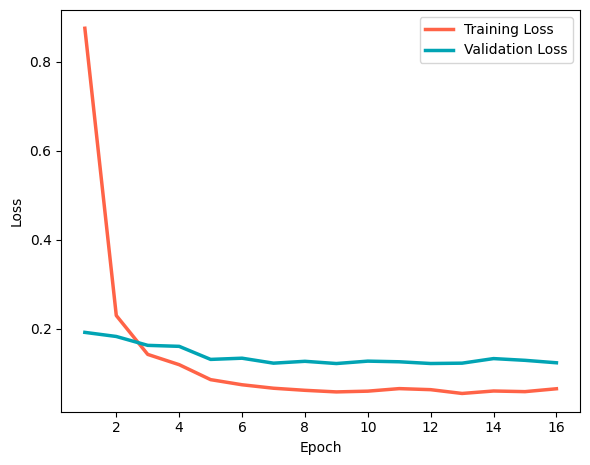

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.886335 	 Validation Loss: 0.212815


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.234732 	 Validation Loss: 0.158741


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.155423 	 Validation Loss: 0.150376


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.127918 	 Validation Loss: 0.176422
Test Accuracy: 0.9169


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.084241 	 Validation Loss: 0.138496


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.065106 	 Validation Loss: 0.128113


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.060473 	 Validation Loss: 0.134536


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.061291 	 Validation Loss: 0.131136
Test Accuracy: 0.9351


Epoch 9/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.051142 	 Validation Loss: 0.135806


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.054455 	 Validation Loss: 0.133068


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.053392 	 Validation Loss: 0.131376


Epoch 12/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.047486 	 Validation Loss: 0.131482
Test Accuracy: 0.9357


Epoch 13/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.053300 	 Validation Loss: 0.127932


Epoch 14/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 14, Training Loss: 0.057786 	 Validation Loss: 0.129562


Epoch 15/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.052845 	 Validation Loss: 0.130529


Epoch 16/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.043247 	 Validation Loss: 0.128971
Test Accuracy: 0.9379
Training finished in 2255.33 seconds
Test Accuracy: 0.9379


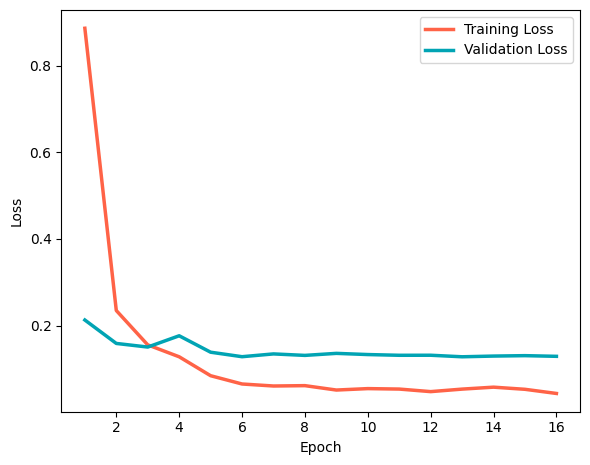

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.903938 	 Validation Loss: 0.170401


Epoch 2/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 2, Training Loss: 0.213056 	 Validation Loss: 0.144009


Epoch 3/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.149888 	 Validation Loss: 0.130307


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.123672 	 Validation Loss: 0.116583
Test Accuracy: 0.9373


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.093659 	 Validation Loss: 0.115770


Epoch 6/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.092187 	 Validation Loss: 0.107377


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.072593 	 Validation Loss: 0.100105


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.053835 	 Validation Loss: 0.103587
Test Accuracy: 0.9433


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.056178 	 Validation Loss: 0.097294


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.044217 	 Validation Loss: 0.105516


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.038287 	 Validation Loss: 0.102823


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.037381 	 Validation Loss: 0.101113
Test Accuracy: 0.9414


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.034929 	 Validation Loss: 0.101743


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.035803 	 Validation Loss: 0.100824


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.037996 	 Validation Loss: 0.102462


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.033216 	 Validation Loss: 0.100708
Test Accuracy: 0.9439
Training finished in 2264.96 seconds
Test Accuracy: 0.9439


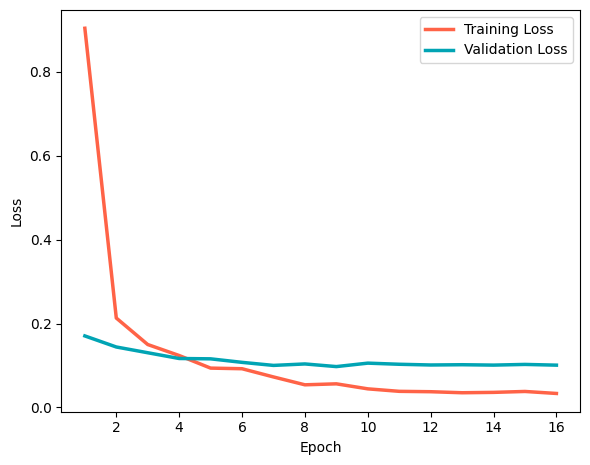

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 2.048540 	 Validation Loss: 0.403663


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.425564 	 Validation Loss: 0.230953


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.283752 	 Validation Loss: 0.183155


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.236548 	 Validation Loss: 0.166685
Test Accuracy: 0.9302


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.179500 	 Validation Loss: 0.159612


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.157470 	 Validation Loss: 0.150673


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.151907 	 Validation Loss: 0.156894


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.165717 	 Validation Loss: 0.156742
Test Accuracy: 0.9305


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.165044 	 Validation Loss: 0.155185


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.158949 	 Validation Loss: 0.155156


Epoch 11/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.163016 	 Validation Loss: 0.154091


Epoch 12/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.161255 	 Validation Loss: 0.150504
Test Accuracy: 0.9313


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.168392 	 Validation Loss: 0.161232


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.165502 	 Validation Loss: 0.149496


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.159161 	 Validation Loss: 0.156041


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.158332 	 Validation Loss: 0.152086
Test Accuracy: 0.9349
Training finished in 2274.17 seconds
Test Accuracy: 0.9349


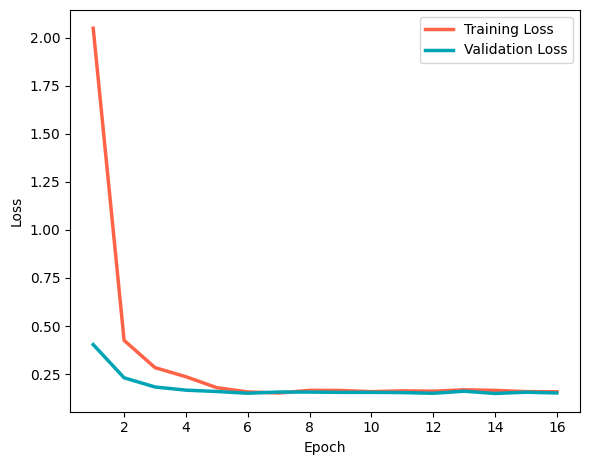

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 2.022374 	 Validation Loss: 0.426916


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.408209 	 Validation Loss: 0.208829


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.284386 	 Validation Loss: 0.187957


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.230557 	 Validation Loss: 0.148038
Test Accuracy: 0.9305


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.187207 	 Validation Loss: 0.140530


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.156894 	 Validation Loss: 0.141568


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.170541 	 Validation Loss: 0.125202


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.158284 	 Validation Loss: 0.129514
Test Accuracy: 0.9351


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.147875 	 Validation Loss: 0.130662


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.151277 	 Validation Loss: 0.129678


Epoch 11/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.145948 	 Validation Loss: 0.127456


Epoch 12/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.146369 	 Validation Loss: 0.124907
Test Accuracy: 0.9370


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.151074 	 Validation Loss: 0.128975


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.154769 	 Validation Loss: 0.125236


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.161595 	 Validation Loss: 0.129145


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.153499 	 Validation Loss: 0.123028
Test Accuracy: 0.9376
Training finished in 2272.32 seconds
Test Accuracy: 0.9376


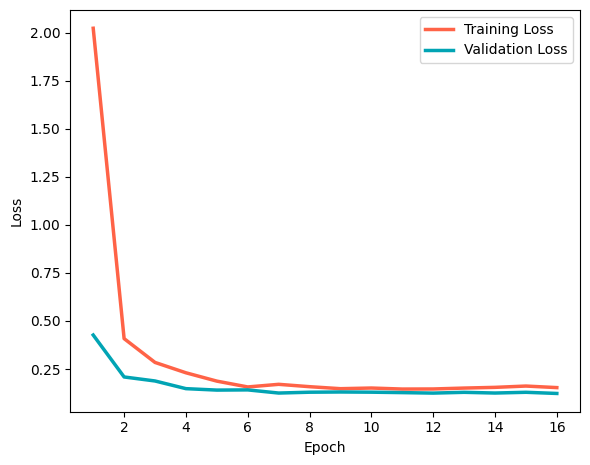

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 2.042456 	 Validation Loss: 0.435614


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.421227 	 Validation Loss: 0.239149


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.283563 	 Validation Loss: 0.195616


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.232354 	 Validation Loss: 0.176249
Test Accuracy: 0.9261


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.200294 	 Validation Loss: 0.154590


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.171438 	 Validation Loss: 0.149529


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.134715 	 Validation Loss: 0.137678


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.120803 	 Validation Loss: 0.137484
Test Accuracy: 0.9327


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.129357 	 Validation Loss: 0.137650


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.120694 	 Validation Loss: 0.134517


Epoch 11/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.115819 	 Validation Loss: 0.134116


Epoch 12/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.110014 	 Validation Loss: 0.130282
Test Accuracy: 0.9368


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.112003 	 Validation Loss: 0.130246


Epoch 14/16: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.103317 	 Validation Loss: 0.124802


Epoch 15/16: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.108826 	 Validation Loss: 0.131891


Epoch 16/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.103723 	 Validation Loss: 0.126428
Test Accuracy: 0.9362
Training finished in 2271.71 seconds
Test Accuracy: 0.9362


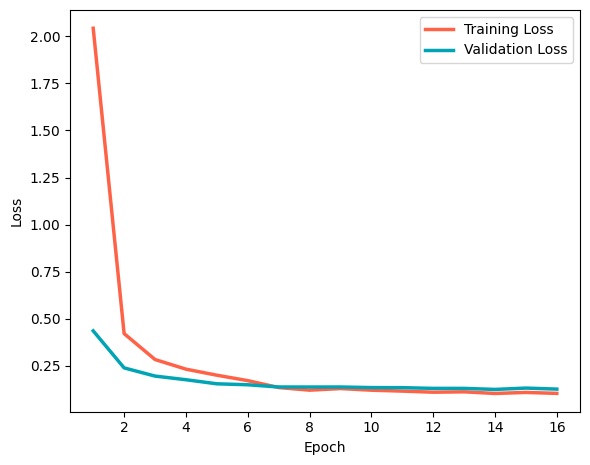

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 1.998302 	 Validation Loss: 0.377856


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.417738 	 Validation Loss: 0.232653


Epoch 3/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.296094 	 Validation Loss: 0.175356


Epoch 4/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.230723 	 Validation Loss: 0.155175
Test Accuracy: 0.9256


Epoch 5/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.176013 	 Validation Loss: 0.143701


Epoch 6/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.171186 	 Validation Loss: 0.135750


Epoch 7/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.154033 	 Validation Loss: 0.139109


Epoch 8/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 8, Training Loss: 0.161996 	 Validation Loss: 0.140317
Test Accuracy: 0.9305


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.157563 	 Validation Loss: 0.136827


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.166004 	 Validation Loss: 0.139454


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.166053 	 Validation Loss: 0.133679


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.159950 	 Validation Loss: 0.132826
Test Accuracy: 0.9308


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.160647 	 Validation Loss: 0.136915


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.162056 	 Validation Loss: 0.141020


Epoch 15/16: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.159040 	 Validation Loss: 0.137266


Epoch 16/16: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 16, Training Loss: 0.177135 	 Validation Loss: 0.137190
Test Accuracy: 0.9319
Training finished in 2278.00 seconds
Test Accuracy: 0.9319


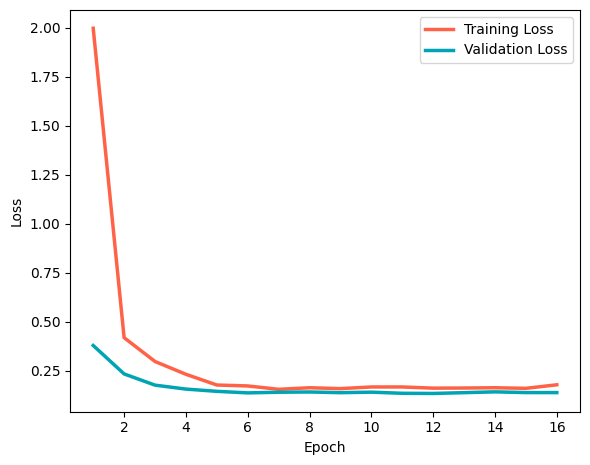

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 2.042554 	 Validation Loss: 0.411573


Epoch 2/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.432656 	 Validation Loss: 0.234258


Epoch 3/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.287371 	 Validation Loss: 0.169965


Epoch 4/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.244140 	 Validation Loss: 0.145220
Test Accuracy: 0.9253


Epoch 5/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.179948 	 Validation Loss: 0.137831


Epoch 6/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.179138 	 Validation Loss: 0.126107


Epoch 7/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 7, Training Loss: 0.165403 	 Validation Loss: 0.117288


Epoch 8/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 8, Training Loss: 0.161186 	 Validation Loss: 0.113780
Test Accuracy: 0.9346


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.159264 	 Validation Loss: 0.113959


Epoch 10/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 10, Training Loss: 0.149037 	 Validation Loss: 0.112861


Epoch 11/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.153470 	 Validation Loss: 0.112924


Epoch 12/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 12, Training Loss: 0.139942 	 Validation Loss: 0.112708
Test Accuracy: 0.9359


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 13, Training Loss: 0.151348 	 Validation Loss: 0.116644


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 14, Training Loss: 0.148523 	 Validation Loss: 0.116701


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 15, Training Loss: 0.144674 	 Validation Loss: 0.114973


Epoch 16/16: 100%|██████████| 184/184 [01:55<00:00,  1.59batch/s]


Epoch 16, Training Loss: 0.147617 	 Validation Loss: 0.115940
Test Accuracy: 0.9335
Training finished in 2286.30 seconds
Test Accuracy: 0.9335


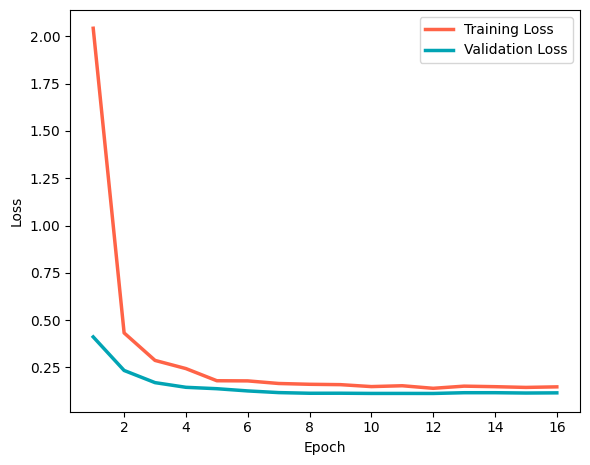

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 2.006416 	 Validation Loss: 0.449508


Epoch 2/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.423823 	 Validation Loss: 0.254716


Epoch 3/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.299793 	 Validation Loss: 0.205167


Epoch 4/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 4, Training Loss: 0.231725 	 Validation Loss: 0.177374
Test Accuracy: 0.9332


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.198346 	 Validation Loss: 0.179768


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.162554 	 Validation Loss: 0.148844


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.126514 	 Validation Loss: 0.142079


Epoch 8/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.135566 	 Validation Loss: 0.146934
Test Accuracy: 0.9376


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.115327 	 Validation Loss: 0.147288


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.121436 	 Validation Loss: 0.150281


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.118215 	 Validation Loss: 0.142567


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.119795 	 Validation Loss: 0.141655
Test Accuracy: 0.9381


Epoch 13/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 13, Training Loss: 0.109175 	 Validation Loss: 0.142903


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.104657 	 Validation Loss: 0.144211


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.110223 	 Validation Loss: 0.139814


Epoch 16/16: 100%|██████████| 184/184 [01:55<00:00,  1.60batch/s]


Epoch 16, Training Loss: 0.103567 	 Validation Loss: 0.142661
Test Accuracy: 0.9384
Training finished in 2277.04 seconds
Test Accuracy: 0.9384


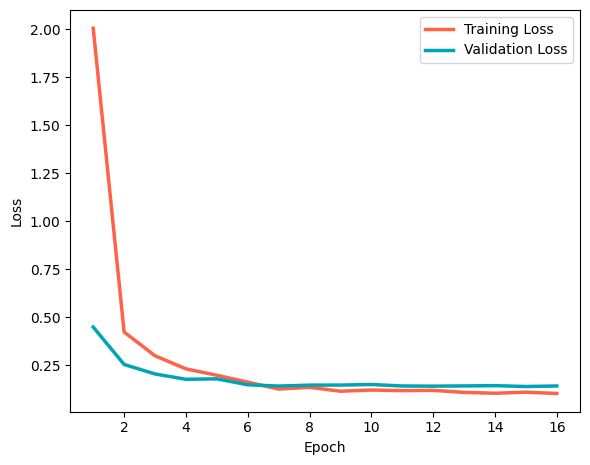

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 1, Training Loss: 2.022362 	 Validation Loss: 0.390263


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.438734 	 Validation Loss: 0.203507


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.277498 	 Validation Loss: 0.167913


Epoch 4/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 4, Training Loss: 0.244797 	 Validation Loss: 0.158520
Test Accuracy: 0.9240


Epoch 5/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.190601 	 Validation Loss: 0.136809


Epoch 6/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 6, Training Loss: 0.182784 	 Validation Loss: 0.125636


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.170422 	 Validation Loss: 0.121968


Epoch 8/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.170923 	 Validation Loss: 0.124551
Test Accuracy: 0.9321


Epoch 9/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.162200 	 Validation Loss: 0.124923


Epoch 10/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.164968 	 Validation Loss: 0.119126


Epoch 11/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.160020 	 Validation Loss: 0.126569


Epoch 12/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 12, Training Loss: 0.164427 	 Validation Loss: 0.126184
Test Accuracy: 0.9327


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.165785 	 Validation Loss: 0.124874


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.175149 	 Validation Loss: 0.128472


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.179434 	 Validation Loss: 0.124014


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.159582 	 Validation Loss: 0.121130
Test Accuracy: 0.9319
Training finished in 2269.87 seconds
Test Accuracy: 0.9319


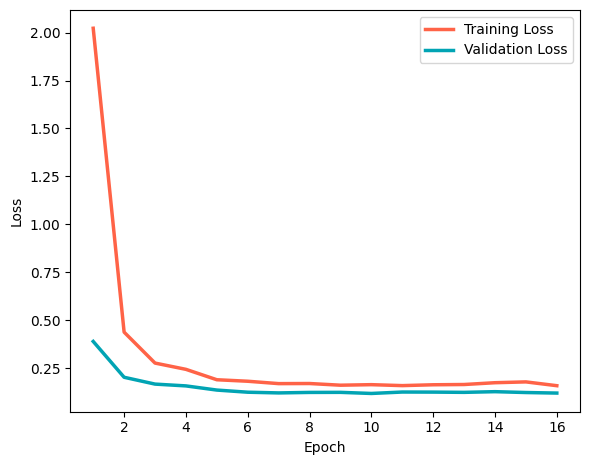

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 1.997372 	 Validation Loss: 0.408209


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.416141 	 Validation Loss: 0.239909


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.252609 	 Validation Loss: 0.177770


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.236982 	 Validation Loss: 0.154869
Test Accuracy: 0.9289


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.181433 	 Validation Loss: 0.144187


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.165749 	 Validation Loss: 0.144572


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.164759 	 Validation Loss: 0.135728


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.160767 	 Validation Loss: 0.141327
Test Accuracy: 0.9338


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.141960 	 Validation Loss: 0.132137


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.156725 	 Validation Loss: 0.138893


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.146573 	 Validation Loss: 0.137947


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.147580 	 Validation Loss: 0.133874
Test Accuracy: 0.9324


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.145565 	 Validation Loss: 0.133054


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 14, Training Loss: 0.154079 	 Validation Loss: 0.132041


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 15, Training Loss: 0.147774 	 Validation Loss: 0.135669


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.152241 	 Validation Loss: 0.134131
Test Accuracy: 0.9335
Training finished in 2257.56 seconds
Test Accuracy: 0.9335


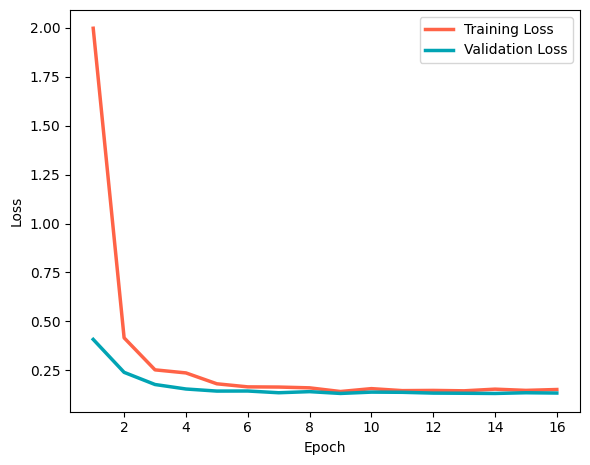

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 2.036864 	 Validation Loss: 0.419728


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.426886 	 Validation Loss: 0.231893


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.286510 	 Validation Loss: 0.176879


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.223487 	 Validation Loss: 0.188270
Test Accuracy: 0.9193


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.198387 	 Validation Loss: 0.170132


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.165009 	 Validation Loss: 0.153287


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.140969 	 Validation Loss: 0.144031


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.122417 	 Validation Loss: 0.142922
Test Accuracy: 0.9379


Epoch 9/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.132674 	 Validation Loss: 0.144361


Epoch 10/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.130372 	 Validation Loss: 0.143796


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.128490 	 Validation Loss: 0.139342


Epoch 12/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 12, Training Loss: 0.112219 	 Validation Loss: 0.143094
Test Accuracy: 0.9387


Epoch 13/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 13, Training Loss: 0.113963 	 Validation Loss: 0.139492


Epoch 14/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 14, Training Loss: 0.111451 	 Validation Loss: 0.136965


Epoch 15/16: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 15, Training Loss: 0.106529 	 Validation Loss: 0.137953


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 16, Training Loss: 0.108659 	 Validation Loss: 0.139396
Test Accuracy: 0.9373
Training finished in 2264.10 seconds
Test Accuracy: 0.9373


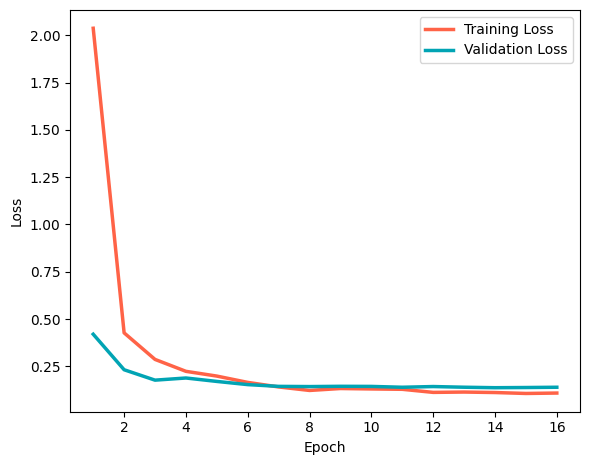

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 2
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 2.013564 	 Validation Loss: 0.412190


Epoch 2/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.400544 	 Validation Loss: 0.250355


Epoch 3/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.276369 	 Validation Loss: 0.210942


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.218349 	 Validation Loss: 0.215962
Test Accuracy: 0.9169


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.171544 	 Validation Loss: 0.190486


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.157417 	 Validation Loss: 0.184289


Epoch 7/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.155354 	 Validation Loss: 0.187022


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.162562 	 Validation Loss: 0.186314
Test Accuracy: 0.9289


Epoch 9/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.161586 	 Validation Loss: 0.188485


Epoch 10/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.161521 	 Validation Loss: 0.186397


Epoch 11/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.159669 	 Validation Loss: 0.189387


Epoch 12/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.154305 	 Validation Loss: 0.189841
Test Accuracy: 0.9280


Epoch 13/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.150501 	 Validation Loss: 0.188867


Epoch 14/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 14, Training Loss: 0.159718 	 Validation Loss: 0.186145


Epoch 15/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.152504 	 Validation Loss: 0.187401


Epoch 16/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.1549 	 Validation Loss: 0.1901. Early stopping triggered
Training finished in 2190.73 seconds
Test Accuracy: 0.9278


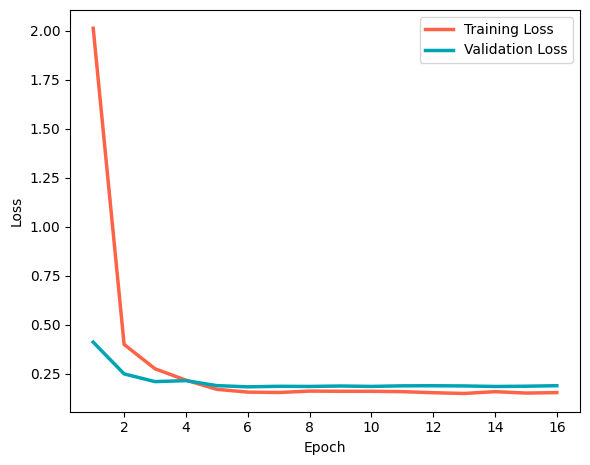

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 1, Training Loss: 1.995000 	 Validation Loss: 0.401166


Epoch 2/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 2, Training Loss: 0.412937 	 Validation Loss: 0.226893


Epoch 3/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.274643 	 Validation Loss: 0.187653


Epoch 4/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.230931 	 Validation Loss: 0.164010
Test Accuracy: 0.9193


Epoch 5/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.186513 	 Validation Loss: 0.143483


Epoch 6/16: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.172487 	 Validation Loss: 0.142131


Epoch 7/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.161153 	 Validation Loss: 0.137244


Epoch 8/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.152577 	 Validation Loss: 0.134411
Test Accuracy: 0.9300


Epoch 9/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.147532 	 Validation Loss: 0.131324


Epoch 10/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.144325 	 Validation Loss: 0.127795


Epoch 11/16: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.167052 	 Validation Loss: 0.129211


Epoch 12/16: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 12, Training Loss: 0.150433 	 Validation Loss: 0.127575
Test Accuracy: 0.9286


Epoch 13/16: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 13, Training Loss: 0.151871 	 Validation Loss: 0.126389


Epoch 14/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 14, Training Loss: 0.150327 	 Validation Loss: 0.130283


Epoch 15/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 15, Training Loss: 0.153638 	 Validation Loss: 0.132567


Epoch 16/16: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 16, Training Loss: 0.154231 	 Validation Loss: 0.131118
Test Accuracy: 0.9294
Training finished in 2258.93 seconds
Test Accuracy: 0.9294


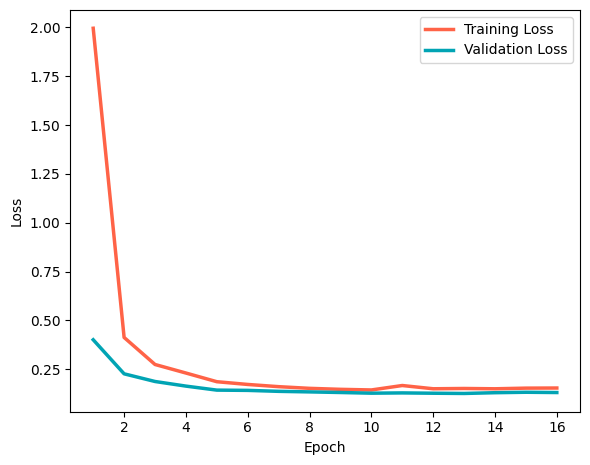

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/16:   1%|          | 1/184 [00:00<01:49,  1.67batch/s]

Buffered data was truncated after reaching the output size limit.

In [ ]:
lr_list = [5e-3, 1e-3]
unfreeze_interval_list = [2, 3, 4, 6]
reduce_learning_rate_list = [2, 4, 6]
training_mode_list = [2]

for lr in lr_list:
    for unfreeze_interval in unfreeze_interval_list:
        for reduce_learning_rate in reduce_learning_rate_list:
            for training_mode in training_mode_list:
                print(f"Training with parameters:")
                print(f"  Learning Rate: {lr}")
                print(f"  Unfreeze Interval: {unfreeze_interval}")
                print(f"  Reduce Learning Rate: {reduce_learning_rate}")
                print(f"  Training Mode: {training_mode}")
                train = Train(lr=lr, bs=16, epochs=16, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
                train.train()
                train.evaluate()
                train.plot_loss_curves()
                print("-" * 40)


## Övrigt

In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14787 MiB |  14787 MiB |  15085 MiB | 305336 KiB |\n|       from large pool |  14749 MiB |  14749 MiB |  15042 MiB | 299977 KiB |\n|       from small pool |     37 MiB |     37 MiB |     42 MiB |   5359 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14787 MiB |  14787 MiB |  15085 MiB | 305336 KiB |\n|       from large pool |  14749 MiB |  14749 MiB |

In [ ]:
torch.cuda.empty_cache()

Using gpu: True 
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.005


Epoch 1/24: 100%|██████████| 148/148 [01:59<00:00,  1.24batch/s]


Epoch 1, Training Loss: 0.9366 	 Validation Loss: 0.1905


Epoch 2/24: 100%|██████████| 148/148 [01:58<00:00,  1.25batch/s]


Epoch 2, Training Loss: 0.2349 	 Validation Loss: 0.1671


Epoch 3/24: 100%|██████████| 148/148 [01:58<00:00,  1.24batch/s]


Epoch 3, Training Loss: 0.1556 	 Validation Loss: 0.1673


Epoch 4/24: 100%|██████████| 148/148 [01:59<00:00,  1.24batch/s]


0.weight False
1.weight True
1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.005
Parameter Group 3: Learning Rate = 5e-05
Parameter: 0.weight, Requires Grad: True
Parameter: 1.weight, Requires Grad: True
Parameter: 1.bias, Requires Grad: True
0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.005
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-05
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Pa

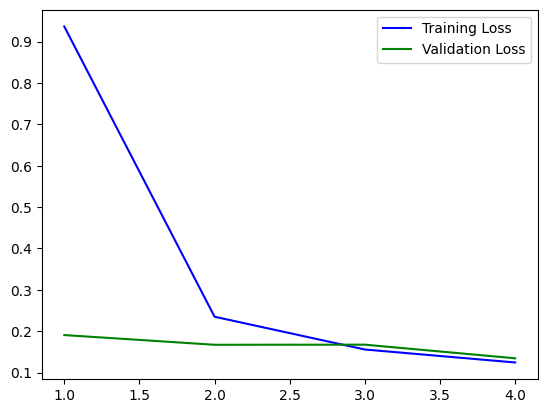

Test Accuracy: 0.9253
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0005
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5e-06


Epoch 5/24: 100%|██████████| 148/148 [02:01<00:00,  1.22batch/s]


Epoch 5, Training Loss: 0.0856 	 Validation Loss: 0.1290


Epoch 6/24: 100%|██████████| 148/148 [02:00<00:00,  1.23batch/s]


Epoch 6, Training Loss: 0.0757 	 Validation Loss: 0.1238


Epoch 7/24: 100%|██████████| 148/148 [02:00<00:00,  1.23batch/s]


Epoch 7, Training Loss: 0.0720 	 Validation Loss: 0.1178


Epoch 8/24: 100%|██████████| 148/148 [02:00<00:00,  1.23batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0005
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5e-06
Parameter Group 5: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, R

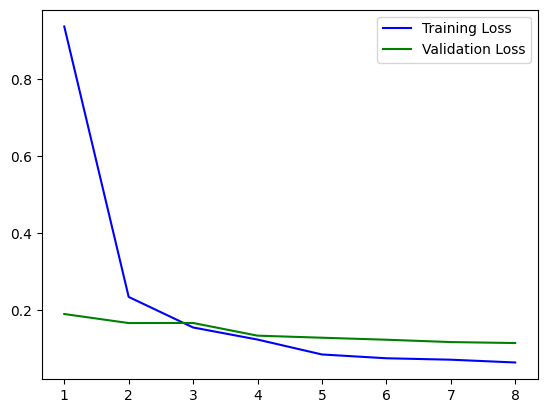

Test Accuracy: 0.9368
Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 5e-05
Parameter Group 3: Learning Rate = 5.000000000000001e-07
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter Group 6: Learning Rate = 5.000000000000001e-07


Epoch 9/24: 100%|██████████| 148/148 [02:03<00:00,  1.20batch/s]


Epoch 9, Training Loss: 0.0615 	 Validation Loss: 0.1198


Epoch 10/24: 100%|██████████| 148/148 [02:03<00:00,  1.20batch/s]


Epoch 10, Training Loss: 0.0531 	 Validation Loss: 0.1221


Epoch 11/24: 100%|██████████| 148/148 [02:03<00:00,  1.20batch/s]


Epoch 11, Training Loss: 0.0602 	 Validation Loss: 0.1219


Epoch 12/24: 100%|██████████| 148/148 [02:02<00:00,  1.21batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 5e-05
Parameter Group 3: Learning Rate = 5.000000000000001e-07
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter Group 6: Learning Rate = 5.000000000000001e-07
Parameter Group 7: Learning Rate = 5.000000000000001e-07
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Gra

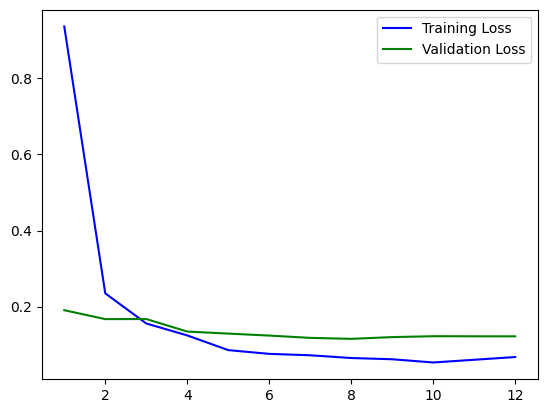

Test Accuracy: 0.9406
Parameter Group 0: Learning Rate = 5e-06
Parameter Group 1: Learning Rate = 5e-06
Parameter Group 2: Learning Rate = 5e-06
Parameter Group 3: Learning Rate = 5.000000000000001e-08
Parameter Group 4: Learning Rate = 5.000000000000001e-08
Parameter Group 5: Learning Rate = 5.000000000000001e-08
Parameter Group 6: Learning Rate = 5.000000000000001e-08
Parameter Group 7: Learning Rate = 5.000000000000001e-08
Parameter Group 8: Learning Rate = 5.000000000000001e-09


Epoch 13/24: 100%|██████████| 148/148 [02:04<00:00,  1.19batch/s]


Epoch 13, Training Loss: 0.0626 	 Validation Loss: 0.1173


Epoch 14/24: 100%|██████████| 148/148 [02:03<00:00,  1.19batch/s]


Epoch 14, Training Loss: 0.0562 	 Validation Loss: 0.1178


Epoch 15/24: 100%|██████████| 148/148 [02:03<00:00,  1.20batch/s]


Epoch 15, Training Loss: 0.0565 	 Validation Loss: 0.1159


Epoch 16/24: 100%|██████████| 148/148 [02:03<00:00,  1.20batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 5e-06
Parameter Group 1: Learning Rate = 5e-06
Parameter Group 2: Learning Rate = 5e-06
Parameter Group 3: Learning Rate = 5.000000000000001e-08
Parameter Group 4: Learning Rate = 5.000000000000001e-08
Parameter Group 5: Learning Rate = 5.000000000000001e-08
Parameter Group 6: Learning Rate = 5.000000000000001e-08
Parameter Group 7: Learning Rate = 5.000000000000001e-08
Parameter Group 8: Learning Rate = 5.000000000000001e-09
Parameter Group 9: Learning Rate = 5.000000000000001e-09
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 

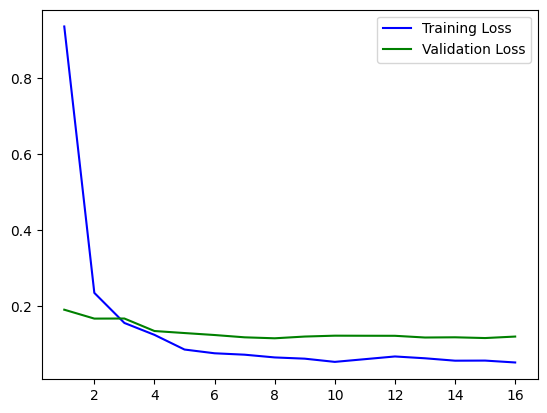

Test Accuracy: 0.9389
Parameter Group 0: Learning Rate = 5.000000000000001e-07
Parameter Group 1: Learning Rate = 5.000000000000001e-07
Parameter Group 2: Learning Rate = 5.000000000000001e-07
Parameter Group 3: Learning Rate = 5.000000000000001e-09
Parameter Group 4: Learning Rate = 5.000000000000001e-09
Parameter Group 5: Learning Rate = 5.000000000000001e-09
Parameter Group 6: Learning Rate = 5.000000000000001e-09
Parameter Group 7: Learning Rate = 5.000000000000001e-09
Parameter Group 8: Learning Rate = 5.000000000000001e-10
Parameter Group 9: Learning Rate = 5.000000000000001e-10


Epoch 17/24: 100%|██████████| 148/148 [02:04<00:00,  1.19batch/s]


Epoch 17, Training Loss: 0.0569 	 Validation Loss: 0.1188


Epoch 18/24: 100%|██████████| 148/148 [02:04<00:00,  1.19batch/s]


Epoch 18, Training Loss: 0.0552 	 Validation Loss: 0.1194. Early stopping triggered
Training finished in 2741.83 seconds


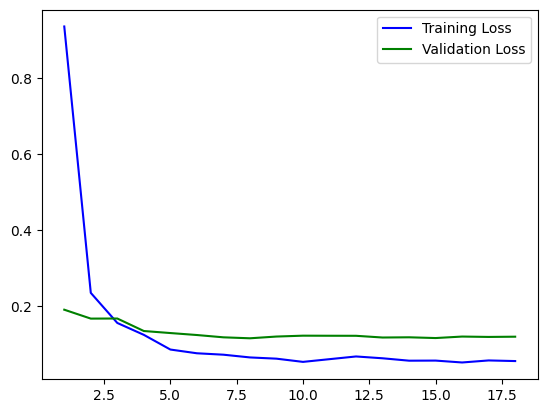

Test Accuracy: 0.9379


AttributeError: 'Train' object has no attribute 'classification_eport'

In [ ]:
train = Train(lr=5e-3, bs=20, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=4, _LoadData=_LoadData, training_mode=2)
train.train()
train.plot_loss_curves()
train.evaluate()
a = train.classification_report()

Using gpu: True 
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001


Epoch 1/24: 100%|██████████| 184/184 [01:57<00:00,  1.56batch/s]


Epoch 1, Training Loss: 1.1222 	 Validation Loss: 0.2318


Epoch 2/24: 100%|██████████| 184/184 [01:58<00:00,  1.56batch/s]


Epoch 2, Training Loss: 0.2956 	 Validation Loss: 0.1814


Epoch 3/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 3, Training Loss: 0.1833 	 Validation Loss: 0.1523


Epoch 4/24: 100%|██████████| 184/184 [01:58<00:00,  1.56batch/s]


0.weight False
1.weight True
1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter: 0.weight, Requires Grad: True
Parameter: 1.weight, Requires Grad: True
Parameter: 1.bias, Requires Grad: True
Epoch 4, Training Loss: 0.1499 	 Validation Loss: 0.1206


Epoch 5/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


Epoch 5, Training Loss: 0.1466 	 Validation Loss: 0.1281


Epoch 6/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter Group 4: Learning Rate = 5e-05
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, Requires Grad: True
Epoch 6, Training Loss: 

Epoch 7/24: 100%|██████████| 184/184 [02:02<00:00,  1.50batch/s]


Epoch 7, Training Loss: 0.0853 	 Validation Loss: 0.1148


Epoch 8/24: 100%|██████████| 184/184 [02:03<00:00,  1.49batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter Group 4: Learning Rate = 5e-05
Parameter Group 5: Learning Rate = 5e-05
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, Req

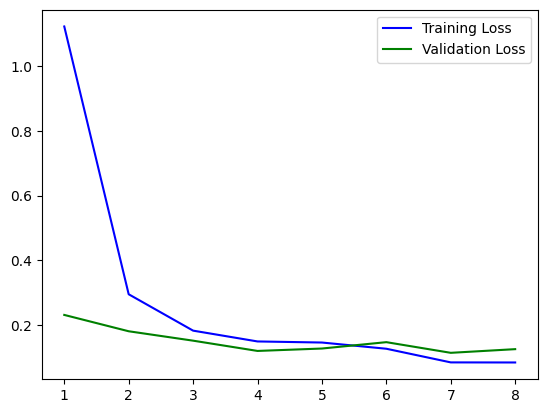

Test Accuracy: 0.9308
Epoch 8, Training Loss: 0.0850 	 Validation Loss: 0.1261


Epoch 9/24: 100%|██████████| 184/184 [02:00<00:00,  1.52batch/s]


Epoch 9, Training Loss: 0.0658 	 Validation Loss: 0.1102


Epoch 10/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-06
Parameter Group 5: Learning Rate = 5e-06
Parameter Group 6: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, R

Epoch 11/24: 100%|██████████| 184/184 [02:00<00:00,  1.52batch/s]


Epoch 11, Training Loss: 0.0576 	 Validation Loss: 0.1072


Epoch 12/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-06
Parameter Group 5: Learning Rate = 5e-06
Parameter Group 6: Learning Rate = 5e-06
Parameter Group 7: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Req

Epoch 13/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Epoch 13, Training Loss: 0.0484 	 Validation Loss: 0.1025


Epoch 14/24: 100%|██████████| 184/184 [02:02<00:00,  1.50batch/s]


Epoch 14, Training Loss: 0.0471 	 Validation Loss: 0.0994


Epoch 15/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Epoch 15, Training Loss: 0.0479 	 Validation Loss: 0.1027


Epoch 16/24: 100%|██████████| 184/184 [02:02<00:00,  1.51batch/s]


Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 1e-05
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter Group 6: Learning Rate = 5.000000000000001e-07
Parameter Group 7: Learning Rate = 5.000000000000001e-07


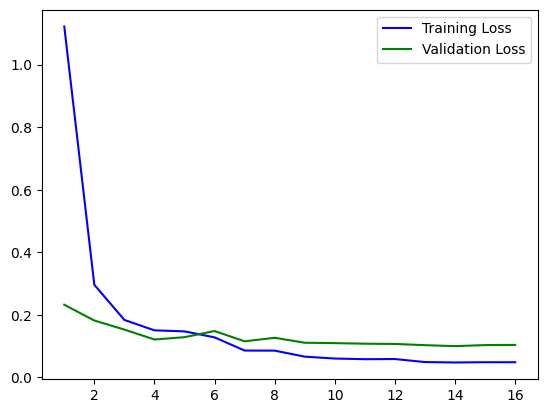

Test Accuracy: 0.9370
Epoch 16, Training Loss: 0.0478 	 Validation Loss: 0.1033


Epoch 17/24: 100%|██████████| 184/184 [02:02<00:00,  1.50batch/s]


Epoch 17, Training Loss: 0.0500 	 Validation Loss: 0.1108


Epoch 18/24: 100%|██████████| 184/184 [02:02<00:00,  1.50batch/s]


Epoch 18, Training Loss: 0.0458 	 Validation Loss: 0.0960


Epoch 19/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Epoch 19, Training Loss: 0.0372 	 Validation Loss: 0.1011


Epoch 20/24: 100%|██████████| 184/184 [02:02<00:00,  1.50batch/s]


Epoch 20, Training Loss: 0.0360 	 Validation Loss: 0.1021


Epoch 21/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


Epoch 21, Training Loss: 0.0359 	 Validation Loss: 0.1050


Epoch 22/24: 100%|██████████| 184/184 [02:02<00:00,  1.51batch/s]


Epoch 22, Training Loss: 0.0377 	 Validation Loss: 0.1001


Epoch 23/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Epoch 23, Training Loss: 0.0472 	 Validation Loss: 0.1007


Epoch 24/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Parameter Group 0: Learning Rate = 5e-06
Parameter Group 1: Learning Rate = 5e-06
Parameter Group 2: Learning Rate = 1.0000000000000002e-06
Parameter Group 3: Learning Rate = 5.000000000000001e-07
Parameter Group 4: Learning Rate = 5.000000000000001e-08
Parameter Group 5: Learning Rate = 5.000000000000001e-08
Parameter Group 6: Learning Rate = 5.000000000000001e-08
Parameter Group 7: Learning Rate = 5.000000000000001e-08


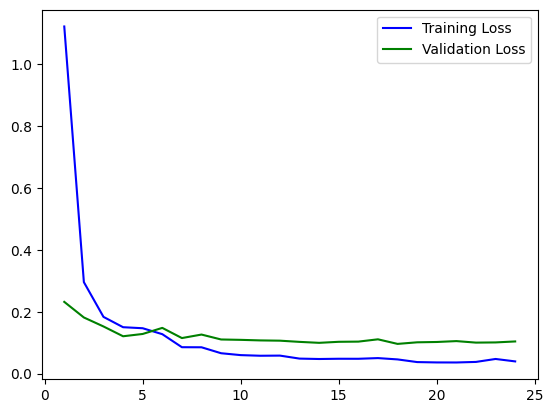

Test Accuracy: 0.9376
Epoch 24, Training Loss: 0.0394 	 Validation Loss: 0.1039
Training finished in 3464.22 seconds


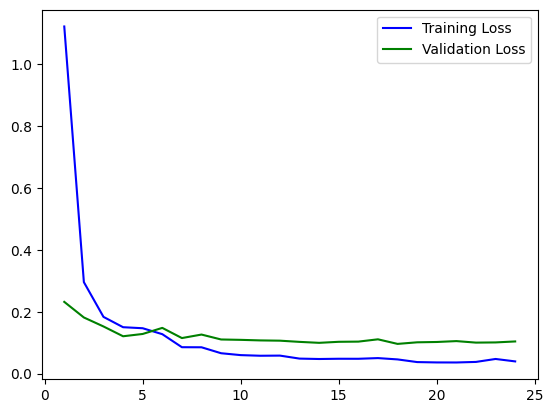

Test Accuracy: 0.9376
                            precision    recall  f1-score   support

                Abyssinian       0.95      0.93      0.94        98
          American Bulldog       0.81      0.94      0.87       100
 American Pit Bull Terrier       0.93      0.62      0.74       100
              Basset Hound       0.95      0.97      0.96       100
                    Beagle       0.98      0.92      0.95       100
                    Bengal       0.78      0.87      0.82       100
                    Birman       0.81      0.84      0.82       100
                    Bombay       0.90      0.97      0.93        88
                     Boxer       0.91      0.92      0.91        99
         British Shorthair       0.95      0.82      0.88       100
                 Chihuahua       0.93      0.94      0.94       100
              Egyptian Mau       0.86      0.93      0.89        97
    English Cocker Spaniel       0.98      1.00      0.99       100
            English Sette

In [ ]:
train = Train(lr=5e-3, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=6, _LoadData=_LoadData, training_mode=2)
train.train()
train.plot_loss_curves()
train.evaluate()
a = train.classification_report()

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 150MB/s]


Using gpu: True 
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001


Epoch 1/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


Epoch 1, Training Loss: 1.1099 	 Validation Loss: 0.2839


Epoch 2/24: 100%|██████████| 184/184 [01:57<00:00,  1.57batch/s]


Epoch 2, Training Loss: 0.2797 	 Validation Loss: 0.1809


Epoch 3/24: 100%|██████████| 184/184 [01:57<00:00,  1.56batch/s]


Epoch 3, Training Loss: 0.2071 	 Validation Loss: 0.1968


Epoch 4/24: 100%|██████████| 184/184 [01:57<00:00,  1.57batch/s]


Epoch 4, Training Loss: 0.1512 	 Validation Loss: 0.1482


Epoch 5/24: 100%|██████████| 184/184 [01:57<00:00,  1.56batch/s]


Epoch 5, Training Loss: 0.1445 	 Validation Loss: 0.1511


Epoch 6/24: 100%|██████████| 184/184 [01:57<00:00,  1.57batch/s]


0.weight False
1.weight True
1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter: 0.weight, Requires Grad: True
Parameter: 1.weight, Requires Grad: True
Parameter: 1.bias, Requires Grad: True
Epoch 6, Training Loss: 0.1230 	 Validation Loss: 0.1444


Epoch 7/24: 100%|██████████| 184/184 [01:57<00:00,  1.56batch/s]


Epoch 7, Training Loss: 0.0979 	 Validation Loss: 0.1511


Epoch 8/24: 100%|██████████| 184/184 [01:58<00:00,  1.56batch/s]


Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05


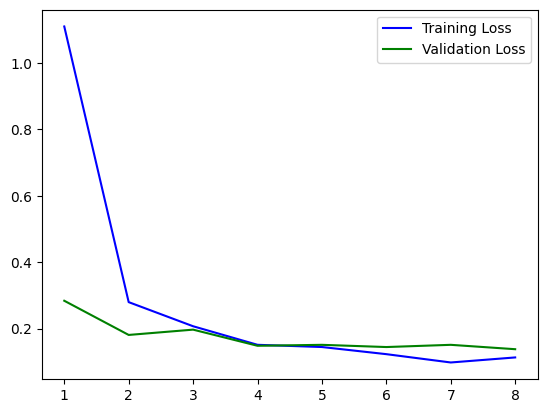

Test Accuracy: 0.9376
Epoch 8, Training Loss: 0.1131 	 Validation Loss: 0.1379


Epoch 9/24: 100%|██████████| 184/184 [01:57<00:00,  1.56batch/s]


Epoch 9, Training Loss: 0.0619 	 Validation Loss: 0.1409


Epoch 10/24: 100%|██████████| 184/184 [01:59<00:00,  1.55batch/s]


Epoch 10, Training Loss: 0.0637 	 Validation Loss: 0.1461


Epoch 11/24: 100%|██████████| 184/184 [01:58<00:00,  1.56batch/s]


Epoch 11, Training Loss: 0.0649 	 Validation Loss: 0.1453


Epoch 12/24: 100%|██████████| 184/184 [01:58<00:00,  1.56batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, Requires Grad: True
Epoch 12, Training Los

Epoch 13/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 13, Training Loss: 0.0540 	 Validation Loss: 0.1372


Epoch 14/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 14, Training Loss: 0.0572 	 Validation Loss: 0.1369


Epoch 15/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 15, Training Loss: 0.0495 	 Validation Loss: 0.1347


Epoch 16/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 1e-05
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5.000000000000001e-07


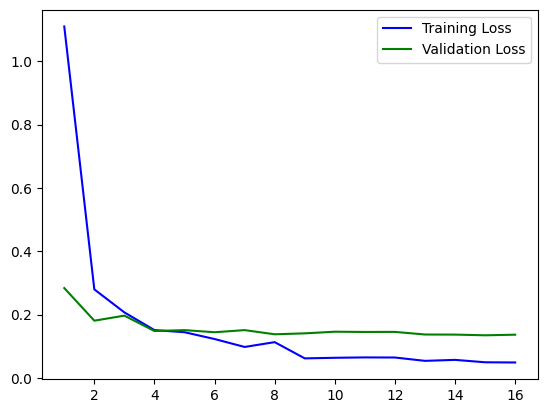

Test Accuracy: 0.9444
Epoch 16, Training Loss: 0.0489 	 Validation Loss: 0.1366


Epoch 17/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 17, Training Loss: 0.0468 	 Validation Loss: 0.1344


Epoch 18/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 1e-05
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad

Epoch 19/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 19, Training Loss: 0.0459 	 Validation Loss: 0.1364


Epoch 20/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 20, Training Loss: 0.0388 	 Validation Loss: 0.1361


Epoch 21/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 21, Training Loss: 0.0498 	 Validation Loss: 0.1347


Epoch 22/24: 100%|██████████| 184/184 [01:59<00:00,  1.53batch/s]


Epoch 22, Training Loss: 0.0409 	 Validation Loss: 0.1298


Epoch 23/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


Epoch 23, Training Loss: 0.0403 	 Validation Loss: 0.1314


Epoch 24/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 1e-05
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter Group 6: Learning Rate = 5.000000000000001e-07
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight,

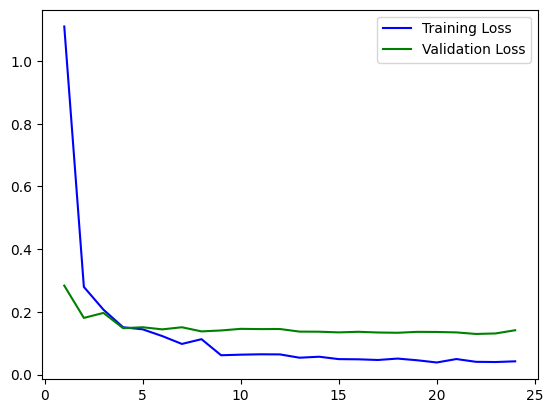

Test Accuracy: 0.9433
Epoch 24, Training Loss: 0.0425 	 Validation Loss: 0.1416
Training finished in 3404.01 seconds


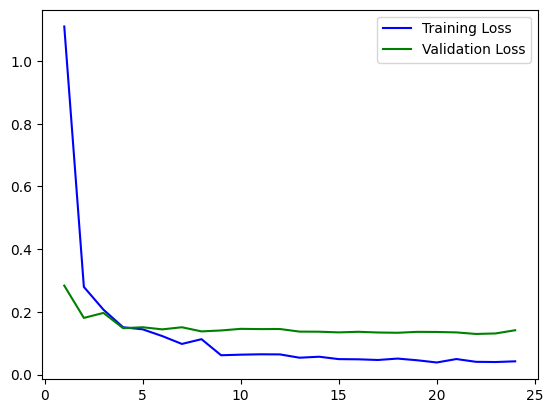

Test Accuracy: 0.9433
                            precision    recall  f1-score   support

                Abyssinian       0.94      0.95      0.94        98
          American Bulldog       0.84      0.87      0.85       100
 American Pit Bull Terrier       0.84      0.72      0.77       100
              Basset Hound       0.95      0.96      0.96       100
                    Beagle       0.97      0.93      0.95       100
                    Bengal       0.82      0.95      0.88       100
                    Birman       0.81      0.91      0.85       100
                    Bombay       0.89      1.00      0.94        88
                     Boxer       0.86      0.95      0.90        99
         British Shorthair       0.98      0.81      0.89       100
                 Chihuahua       0.94      0.93      0.93       100
              Egyptian Mau       0.94      0.90      0.92        97
    English Cocker Spaniel       0.99      1.00      1.00       100
            English Sette

In [ ]:
train = Train(lr=5e-3, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=6, _LoadData=_LoadData, training_mode=2)
train.train()
train.plot_loss_curves()
train.evaluate()
a = train.classification_report()

Using gpu: True 
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001


Epoch 1/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


Epoch 1, Training Loss: 1.1186 	 Validation Loss: 0.2525


Epoch 2/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


Epoch 2, Training Loss: 0.2637 	 Validation Loss: 0.1819


Epoch 3/24: 100%|██████████| 184/184 [01:58<00:00,  1.55batch/s]


Epoch 3, Training Loss: 0.2082 	 Validation Loss: 0.1576


Epoch 4/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


0.weight False
1.weight True
1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter: 0.weight, Requires Grad: True
Parameter: 1.weight, Requires Grad: True
Parameter: 1.bias, Requires Grad: True
Epoch 4, Training Loss: 0.1603 	 Validation Loss: 0.1292


Epoch 5/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 5, Training Loss: 0.1480 	 Validation Loss: 0.1288


Epoch 6/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 6, Training Loss: 0.1205 	 Validation Loss: 0.1372


Epoch 7/24: 100%|██████████| 184/184 [01:59<00:00,  1.55batch/s]


Epoch 7, Training Loss: 0.1072 	 Validation Loss: 0.1064


Epoch 8/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.005
Parameter Group 1: Learning Rate = 0.005
Parameter Group 2: Learning Rate = 0.001
Parameter Group 3: Learning Rate = 0.0005
Parameter Group 4: Learning Rate = 5e-05
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, Requires Grad: True
Parameter Group 0: Learn

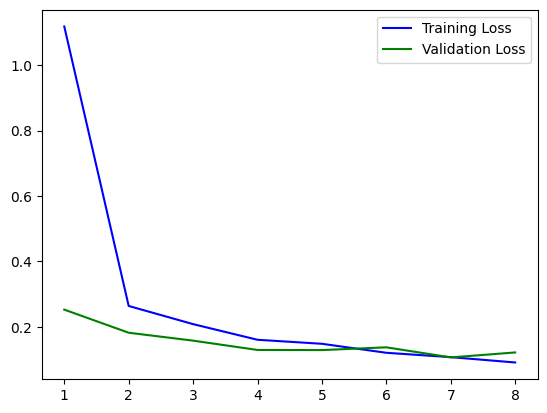

Test Accuracy: 0.9313
Epoch 8, Training Loss: 0.0909 	 Validation Loss: 0.1215


Epoch 9/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 9, Training Loss: 0.0616 	 Validation Loss: 0.1115


Epoch 10/24: 100%|██████████| 184/184 [01:59<00:00,  1.53batch/s]


Epoch 10, Training Loss: 0.0526 	 Validation Loss: 0.1096


Epoch 11/24: 100%|██████████| 184/184 [01:59<00:00,  1.54batch/s]


Epoch 11, Training Loss: 0.0496 	 Validation Loss: 0.1063


Epoch 12/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-06
Parameter Group 5: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, Requires Grad: True
Parameter: 3.1.bias, R

Epoch 13/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 13, Training Loss: 0.0388 	 Validation Loss: 0.0992


Epoch 14/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


Epoch 14, Training Loss: 0.0451 	 Validation Loss: 0.1058


Epoch 15/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 15, Training Loss: 0.0459 	 Validation Loss: 0.1058


Epoch 16/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 0.0005
Parameter Group 1: Learning Rate = 0.0005
Parameter Group 2: Learning Rate = 0.0001
Parameter Group 3: Learning Rate = 5e-05
Parameter Group 4: Learning Rate = 5e-06
Parameter Group 5: Learning Rate = 5e-06
Parameter Group 6: Learning Rate = 5e-06
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Parameter: 2.fc2.bias, Requires Grad: True
Parameter: 3.0.weight, Requires Grad: True
Parameter: 3.1.weight, R

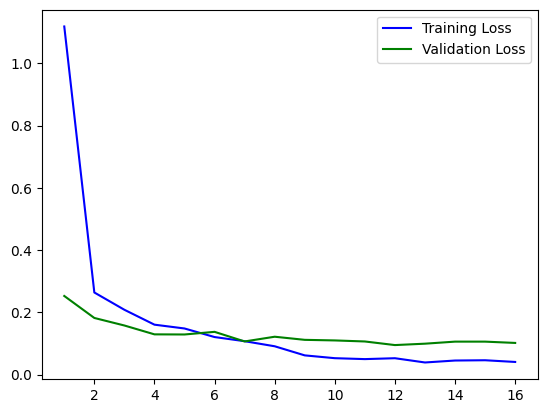

Test Accuracy: 0.9409
Epoch 16, Training Loss: 0.0405 	 Validation Loss: 0.1016


Epoch 17/24: 100%|██████████| 184/184 [02:00<00:00,  1.53batch/s]


Epoch 17, Training Loss: 0.0469 	 Validation Loss: 0.0968


Epoch 18/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


Epoch 18, Training Loss: 0.0391 	 Validation Loss: 0.0975


Epoch 19/24: 100%|██████████| 184/184 [02:00<00:00,  1.52batch/s]


Epoch 19, Training Loss: 0.0366 	 Validation Loss: 0.0988


Epoch 20/24: 100%|██████████| 184/184 [02:01<00:00,  1.52batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Parameter Group 0: Learning Rate = 5e-05
Parameter Group 1: Learning Rate = 5e-05
Parameter Group 2: Learning Rate = 1e-05
Parameter Group 3: Learning Rate = 5e-06
Parameter Group 4: Learning Rate = 5.000000000000001e-07
Parameter Group 5: Learning Rate = 5.000000000000001e-07
Parameter Group 6: Learning Rate = 5.000000000000001e-07
Parameter Group 7: Learning Rate = 5.000000000000001e-07
Parameter: 0.0.weight, Requires Grad: True
Parameter: 0.1.weight, Requires Grad: True
Parameter: 0.1.bias, Requires Grad: True
Parameter: 1.0.weight, Requires Grad: True
Parameter: 1.1.weight, Requires Grad: True
Parameter: 1.1.bias, Requires Grad: True
Parameter: 2.fc1.weight, Requires Grad: True
Parameter: 2.fc1.bias, Requires Grad: True
Parameter: 2.fc2.weight, Requires Grad: True
Paramete

Epoch 21/24: 100%|██████████| 184/184 [02:01<00:00,  1.51batch/s]


Epoch 21, Training Loss: 0.0392 	 Validation Loss: 0.1007


Epoch 22/24: 100%|██████████| 184/184 [02:02<00:00,  1.51batch/s]


Epoch 22, Training Loss: 0.0403 	 Validation Loss: 0.1005. Early stopping triggered
Training finished in 3100.24 seconds


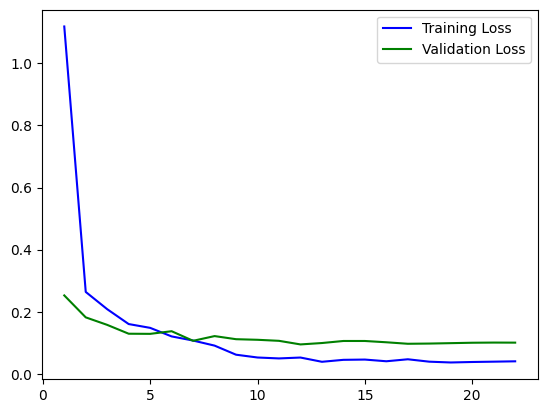

Test Accuracy: 0.9395
                            precision    recall  f1-score   support

                Abyssinian       0.96      0.95      0.95        98
          American Bulldog       0.82      0.93      0.87       100
 American Pit Bull Terrier       0.91      0.59      0.72       100
              Basset Hound       0.96      0.97      0.97       100
                    Beagle       0.97      0.95      0.96       100
                    Bengal       0.78      0.94      0.85       100
                    Birman       0.82      0.87      0.84       100
                    Bombay       0.83      0.98      0.90        88
                     Boxer       0.91      0.93      0.92        99
         British Shorthair       0.96      0.80      0.87       100
                 Chihuahua       0.92      0.96      0.94       100
              Egyptian Mau       0.92      0.89      0.91        97
    English Cocker Spaniel       1.00      0.98      0.99       100
            English Sette

In [ ]:
train = Train(lr=5e-3, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=4, _LoadData=_LoadData, training_mode=2)
train.train()
train.plot_loss_curves()
train.evaluate()
a = train.classification_report()

In [ ]:
train.plot_loss_curves()
train.evaluate()
a = train.classification_report()

NameError: name 'train' is not defined

In [ ]:
#print(train.model)
# Without any training we have an accuracy of around 4% which is almost tha same as guessing
train.evaluate()

Test Accuracy: 0.0409


0.04088307440719542

Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 2


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 135MB/s]


Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.054948 	 Validation Loss: 0.014098


Epoch 2/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.013287 	 Validation Loss: 0.009006


Epoch 3/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.009592 	 Validation Loss: 0.008274


Epoch 4/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.007224 	 Validation Loss: 0.006259


Epoch 5/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.007576 	 Validation Loss: 0.006792


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.004436 	 Validation Loss: 0.006440


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.003040 	 Validation Loss: 0.006001


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.003265 	 Validation Loss: 0.005887


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.002888 	 Validation Loss: 0.006196


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.002528 	 Validation Loss: 0.005868


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.002826 	 Validation Loss: 0.006314


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002495 	 Validation Loss: 0.005903
Training finished in 1492.84 seconds
Test Accuracy: 0.9379


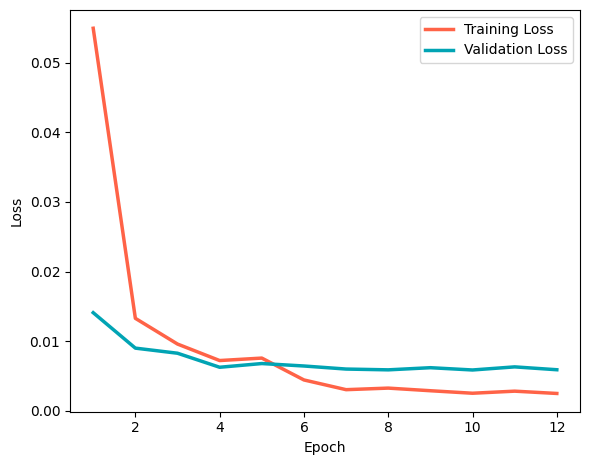

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 1, Training Loss: 0.087571 	 Validation Loss: 0.026915


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 2, Training Loss: 0.029829 	 Validation Loss: 0.017060


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 3, Training Loss: 0.020679 	 Validation Loss: 0.014106


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.018905 	 Validation Loss: 0.012452


Epoch 5/12: 100%|██████████| 184/184 [01:01<00:00,  3.00batch/s]


Epoch 5, Training Loss: 0.015330 	 Validation Loss: 0.009983


Epoch 6/12: 100%|██████████| 184/184 [01:01<00:00,  3.01batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.012102 	 Validation Loss: 0.009790


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 7, Training Loss: 0.010580 	 Validation Loss: 0.009842


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.010790 	 Validation Loss: 0.009651


Epoch 9/12: 100%|██████████| 184/184 [01:04<00:00,  2.86batch/s]


Epoch 9, Training Loss: 0.010599 	 Validation Loss: 0.009566


Epoch 10/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.010525 	 Validation Loss: 0.009178


Epoch 11/12: 100%|██████████| 184/184 [01:05<00:00,  2.79batch/s]


Epoch 11, Training Loss: 0.009622 	 Validation Loss: 0.009350


Epoch 12/12: 100%|██████████| 184/184 [01:06<00:00,  2.79batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.009906 	 Validation Loss: 0.009058
Training finished in 898.24 seconds
Test Accuracy: 0.9111


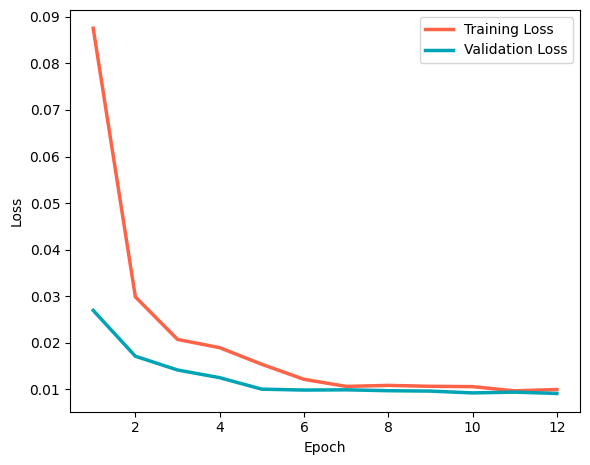

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 1, Training Loss: 0.054604 	 Validation Loss: 0.010732


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.015522 	 Validation Loss: 0.008353


Epoch 3/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.010436 	 Validation Loss: 0.006992


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.008340 	 Validation Loss: 0.008404


Epoch 5/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.007706 	 Validation Loss: 0.011074


Epoch 6/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.005369 	 Validation Loss: 0.006771


Epoch 7/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 7, Training Loss: 0.004232 	 Validation Loss: 0.006513


Epoch 8/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.003079 	 Validation Loss: 0.006755


Epoch 9/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.003566 	 Validation Loss: 0.006745


Epoch 10/12: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.003221 	 Validation Loss: 0.007194


Epoch 11/12: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


Epoch 11, Training Loss: 0.003115 	 Validation Loss: 0.006530


Epoch 12/12: 100%|██████████| 184/184 [01:54<00:00,  1.60batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.003226 	 Validation Loss: 0.006113
Training finished in 1509.17 seconds
Test Accuracy: 0.9392


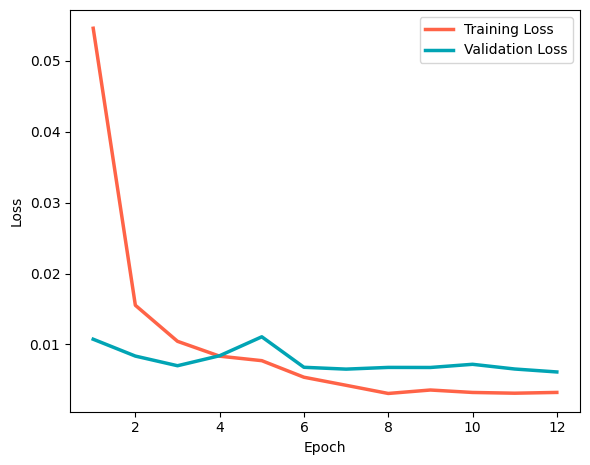

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.10batch/s]


Epoch 1, Training Loss: 0.088251 	 Validation Loss: 0.029436


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.10batch/s]


Epoch 2, Training Loss: 0.027677 	 Validation Loss: 0.018995


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 3, Training Loss: 0.020451 	 Validation Loss: 0.015591


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.10batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.017231 	 Validation Loss: 0.014478


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 5, Training Loss: 0.015592 	 Validation Loss: 0.012592


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.011695 	 Validation Loss: 0.011509


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 7, Training Loss: 0.011189 	 Validation Loss: 0.010936


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.010265 	 Validation Loss: 0.011088


Epoch 9/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


Epoch 9, Training Loss: 0.010536 	 Validation Loss: 0.010734


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.009856 	 Validation Loss: 0.011125


Epoch 11/12: 100%|██████████| 184/184 [01:04<00:00,  2.84batch/s]


Epoch 11, Training Loss: 0.008656 	 Validation Loss: 0.010210


Epoch 12/12: 100%|██████████| 184/184 [01:04<00:00,  2.85batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.009275 	 Validation Loss: 0.010776
Training finished in 891.89 seconds
Test Accuracy: 0.9144


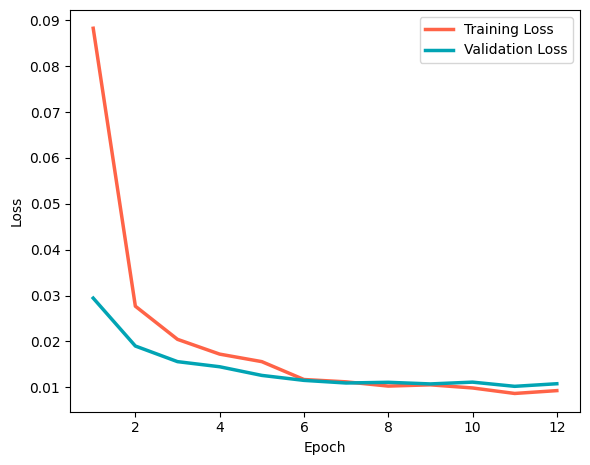

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.053608 	 Validation Loss: 0.013180


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.013513 	 Validation Loss: 0.010166


Epoch 3/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.009761 	 Validation Loss: 0.011579


Epoch 4/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.007908 	 Validation Loss: 0.008081


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.006368 	 Validation Loss: 0.011534


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.004984 	 Validation Loss: 0.007995


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.003495 	 Validation Loss: 0.007595


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.003122 	 Validation Loss: 0.007463


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.002715 	 Validation Loss: 0.007627


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.002915 	 Validation Loss: 0.007493


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.002024 	 Validation Loss: 0.007295


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002639 	 Validation Loss: 0.007132
Training finished in 1496.53 seconds
Test Accuracy: 0.9406


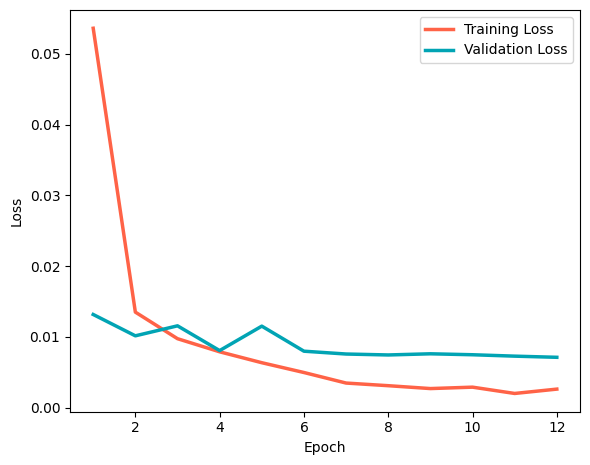

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 1, Training Loss: 0.087685 	 Validation Loss: 0.029885


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 2, Training Loss: 0.028807 	 Validation Loss: 0.019652


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 3, Training Loss: 0.021126 	 Validation Loss: 0.014445


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.017422 	 Validation Loss: 0.013716


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 5, Training Loss: 0.014389 	 Validation Loss: 0.011396


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.011165 	 Validation Loss: 0.009676


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


Epoch 7, Training Loss: 0.010849 	 Validation Loss: 0.009859


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.010747 	 Validation Loss: 0.009294


Epoch 9/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


Epoch 9, Training Loss: 0.009429 	 Validation Loss: 0.009239


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.009530 	 Validation Loss: 0.009726


Epoch 11/12: 100%|██████████| 184/184 [01:04<00:00,  2.83batch/s]


Epoch 11, Training Loss: 0.009359 	 Validation Loss: 0.009189


Epoch 12/12: 100%|██████████| 184/184 [01:04<00:00,  2.83batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.008645 	 Validation Loss: 0.009355
Training finished in 892.98 seconds
Test Accuracy: 0.9193


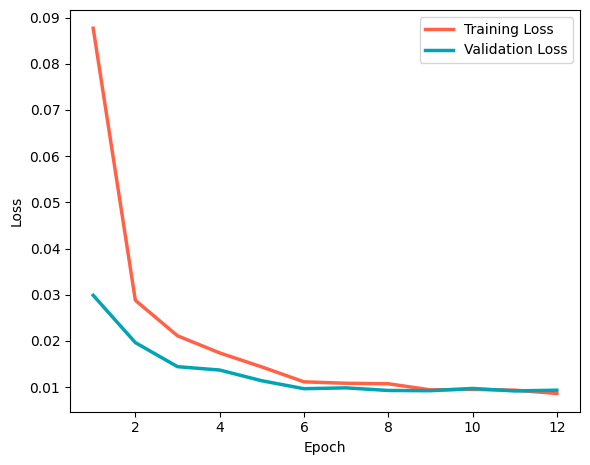

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.055453 	 Validation Loss: 0.013959


Epoch 2/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.014180 	 Validation Loss: 0.010808


Epoch 3/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.010454 	 Validation Loss: 0.010215


Epoch 4/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.008303 	 Validation Loss: 0.008850


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.005919 	 Validation Loss: 0.007812


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.003918 	 Validation Loss: 0.007621


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.003176 	 Validation Loss: 0.007622


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.002743 	 Validation Loss: 0.007544


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.002344 	 Validation Loss: 0.007375


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.002891 	 Validation Loss: 0.007306


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.002735 	 Validation Loss: 0.007895


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002056 	 Validation Loss: 0.007507
Training finished in 1494.31 seconds
Test Accuracy: 0.9359


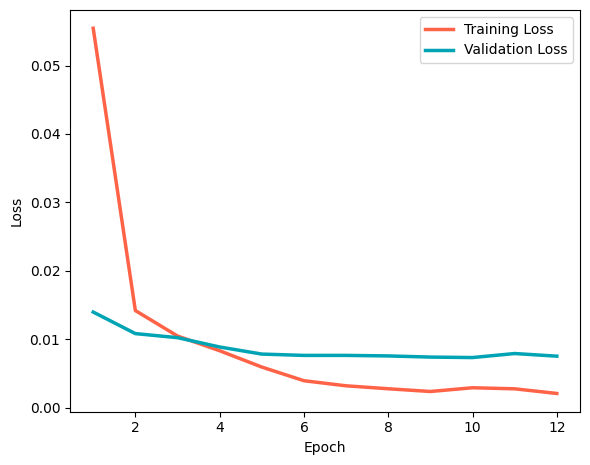

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.11batch/s]


Epoch 1, Training Loss: 0.085418 	 Validation Loss: 0.031612


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.10batch/s]


Epoch 2, Training Loss: 0.028855 	 Validation Loss: 0.022050


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.11batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.021113 	 Validation Loss: 0.017789


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 4, Training Loss: 0.016754 	 Validation Loss: 0.014965


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 5, Training Loss: 0.012475 	 Validation Loss: 0.012261


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.010381 	 Validation Loss: 0.012120


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


Epoch 7, Training Loss: 0.008782 	 Validation Loss: 0.011374


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 8, Training Loss: 0.008674 	 Validation Loss: 0.011537


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.008706 	 Validation Loss: 0.011473


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


Epoch 10, Training Loss: 0.008040 	 Validation Loss: 0.011114


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


Epoch 11, Training Loss: 0.008536 	 Validation Loss: 0.011793


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.007994 	 Validation Loss: 0.010419
Training finished in 888.02 seconds
Test Accuracy: 0.9182


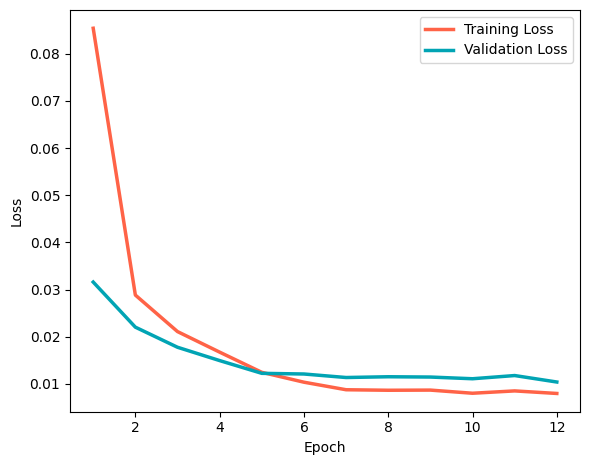

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.056947 	 Validation Loss: 0.012059


Epoch 2/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.013989 	 Validation Loss: 0.007486


Epoch 3/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.010227 	 Validation Loss: 0.007973


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.007588 	 Validation Loss: 0.009231


Epoch 5/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.007193 	 Validation Loss: 0.007024


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.004028 	 Validation Loss: 0.006553


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.003214 	 Validation Loss: 0.006187


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 8, Training Loss: 0.002607 	 Validation Loss: 0.006545


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.002711 	 Validation Loss: 0.006361


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.002866 	 Validation Loss: 0.006274


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.002423 	 Validation Loss: 0.006252


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002559 	 Validation Loss: 0.006196
Training finished in 1493.53 seconds
Test Accuracy: 0.9362


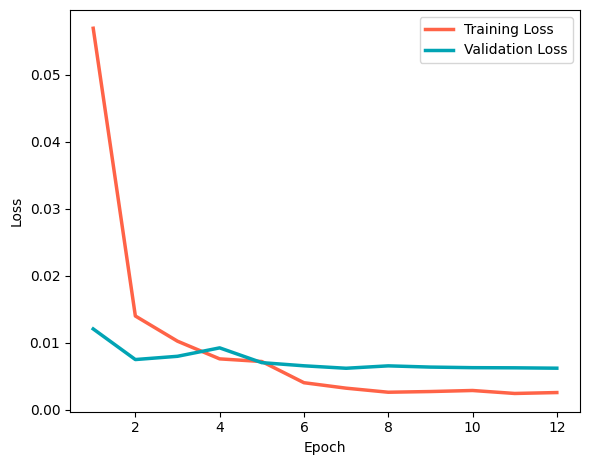

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 1, Training Loss: 0.087911 	 Validation Loss: 0.029850


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 2, Training Loss: 0.027942 	 Validation Loss: 0.020396


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.020251 	 Validation Loss: 0.015829


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 4, Training Loss: 0.016239 	 Validation Loss: 0.012425


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 5, Training Loss: 0.013431 	 Validation Loss: 0.011886


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.010516 	 Validation Loss: 0.010099


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


Epoch 7, Training Loss: 0.008976 	 Validation Loss: 0.010229


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.96batch/s]


Epoch 8, Training Loss: 0.009680 	 Validation Loss: 0.010033


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.008585 	 Validation Loss: 0.009747


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.90batch/s]


Epoch 10, Training Loss: 0.008316 	 Validation Loss: 0.009703


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.90batch/s]


Epoch 11, Training Loss: 0.008755 	 Validation Loss: 0.010000


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.008489 	 Validation Loss: 0.009512
Training finished in 888.14 seconds
Test Accuracy: 0.9191


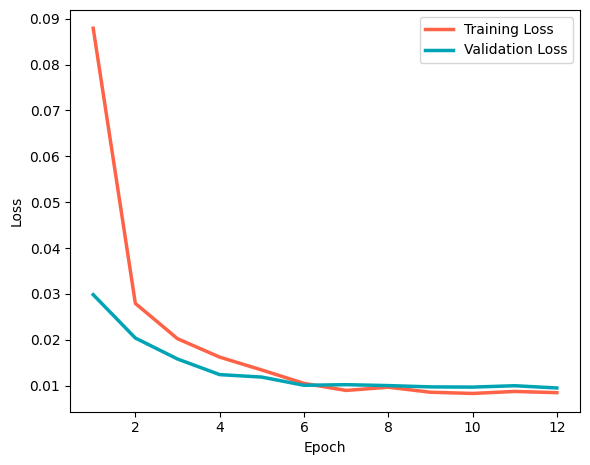

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.054547 	 Validation Loss: 0.015585


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.014388 	 Validation Loss: 0.009393


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.009226 	 Validation Loss: 0.008669


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.007664 	 Validation Loss: 0.007479


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.007174 	 Validation Loss: 0.008887


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.004104 	 Validation Loss: 0.007192


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 7, Training Loss: 0.003975 	 Validation Loss: 0.007026


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.003129 	 Validation Loss: 0.006646


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.002973 	 Validation Loss: 0.006797


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


Epoch 10, Training Loss: 0.002608 	 Validation Loss: 0.007069


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.002939 	 Validation Loss: 0.006806


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002461 	 Validation Loss: 0.006792
Training finished in 1498.85 seconds
Test Accuracy: 0.9376


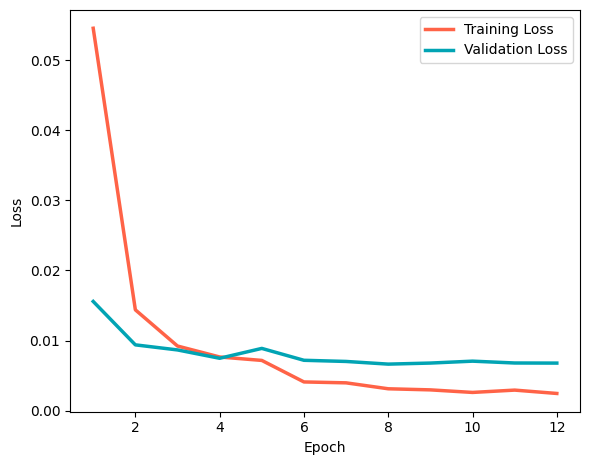

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 3
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.087365 	 Validation Loss: 0.031618


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.027762 	 Validation Loss: 0.019835


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.020205 	 Validation Loss: 0.016471


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 4, Training Loss: 0.016605 	 Validation Loss: 0.014238


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 5, Training Loss: 0.012793 	 Validation Loss: 0.013208


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.010626 	 Validation Loss: 0.012684


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 7, Training Loss: 0.010255 	 Validation Loss: 0.011050


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 8, Training Loss: 0.009037 	 Validation Loss: 0.011087


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.008884 	 Validation Loss: 0.011191


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.90batch/s]


Epoch 10, Training Loss: 0.008089 	 Validation Loss: 0.011768


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


Epoch 11, Training Loss: 0.008214 	 Validation Loss: 0.010779


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.89batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.008521 	 Validation Loss: 0.010343
Training finished in 892.78 seconds
Test Accuracy: 0.9250


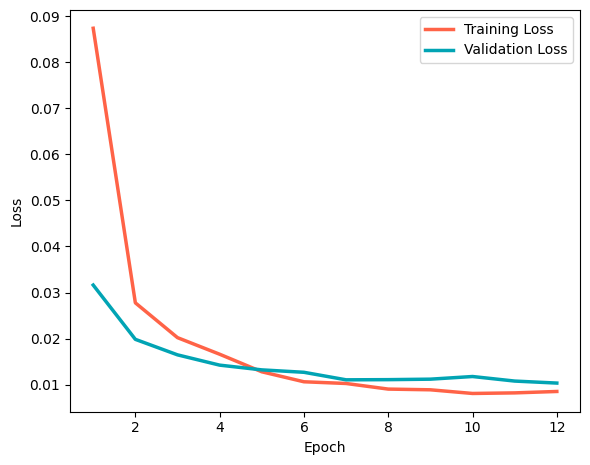

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.055157 	 Validation Loss: 0.013493


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.013844 	 Validation Loss: 0.009195


Epoch 3/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 3, Training Loss: 0.009819 	 Validation Loss: 0.008515


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.007404 	 Validation Loss: 0.008469


Epoch 5/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 5, Training Loss: 0.007233 	 Validation Loss: 0.008858


Epoch 6/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 6, Training Loss: 0.004740 	 Validation Loss: 0.007071


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.004085 	 Validation Loss: 0.007524


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.002904 	 Validation Loss: 0.006952


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.003582 	 Validation Loss: 0.007111


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.003206 	 Validation Loss: 0.006731


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.003076 	 Validation Loss: 0.006829


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002645 	 Validation Loss: 0.006901
Training finished in 1499.62 seconds
Test Accuracy: 0.9409


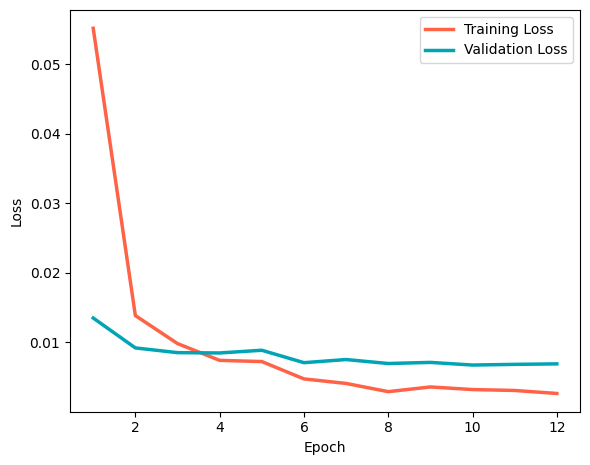

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.088360 	 Validation Loss: 0.029222


Epoch 2/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.028571 	 Validation Loss: 0.019268


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 3, Training Loss: 0.021127 	 Validation Loss: 0.016174


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.017109 	 Validation Loss: 0.014328


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 5, Training Loss: 0.014422 	 Validation Loss: 0.012976


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 6, Training Loss: 0.011774 	 Validation Loss: 0.012038


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 7, Training Loss: 0.010527 	 Validation Loss: 0.011393


Epoch 8/12: 100%|██████████| 184/184 [01:01<00:00,  2.98batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.009858 	 Validation Loss: 0.010902


Epoch 9/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


Epoch 9, Training Loss: 0.010673 	 Validation Loss: 0.011643


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


Epoch 10, Training Loss: 0.010001 	 Validation Loss: 0.010388


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


Epoch 11, Training Loss: 0.008844 	 Validation Loss: 0.010861


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.90batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.009835 	 Validation Loss: 0.010619
Training finished in 891.38 seconds
Test Accuracy: 0.9193


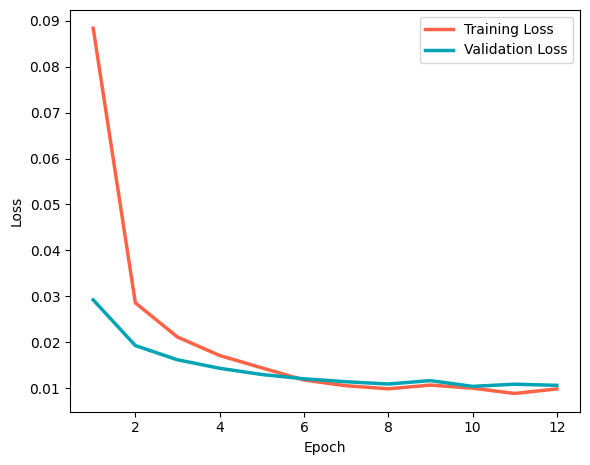

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 1, Training Loss: 0.054828 	 Validation Loss: 0.012309


Epoch 2/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 2, Training Loss: 0.013774 	 Validation Loss: 0.011354


Epoch 3/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 3, Training Loss: 0.009901 	 Validation Loss: 0.010352


Epoch 4/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.007734 	 Validation Loss: 0.012829


Epoch 5/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 5, Training Loss: 0.007729 	 Validation Loss: 0.012952


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.004513 	 Validation Loss: 0.008427


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.003887 	 Validation Loss: 0.008336


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.003238 	 Validation Loss: 0.007377


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.003366 	 Validation Loss: 0.007540


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.002503 	 Validation Loss: 0.006974


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.002937 	 Validation Loss: 0.007358


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002568 	 Validation Loss: 0.006818
Training finished in 1503.67 seconds
Test Accuracy: 0.9368


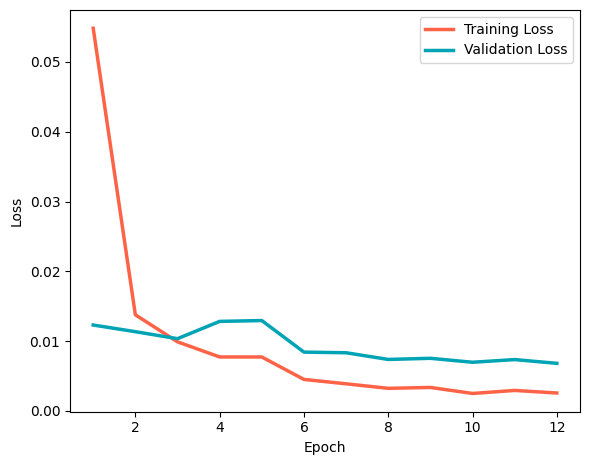

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.087031 	 Validation Loss: 0.028521


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.028397 	 Validation Loss: 0.019088


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 3, Training Loss: 0.020696 	 Validation Loss: 0.016031


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.017619 	 Validation Loss: 0.014839


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 5, Training Loss: 0.014610 	 Validation Loss: 0.012172


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 6, Training Loss: 0.011912 	 Validation Loss: 0.012030


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 7, Training Loss: 0.010991 	 Validation Loss: 0.011746


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.010122 	 Validation Loss: 0.011406


Epoch 9/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


Epoch 9, Training Loss: 0.010173 	 Validation Loss: 0.011780


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


Epoch 10, Training Loss: 0.009667 	 Validation Loss: 0.011659


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


Epoch 11, Training Loss: 0.009205 	 Validation Loss: 0.011519


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.009373 	 Validation Loss: 0.011288
Training finished in 889.25 seconds
Test Accuracy: 0.9229


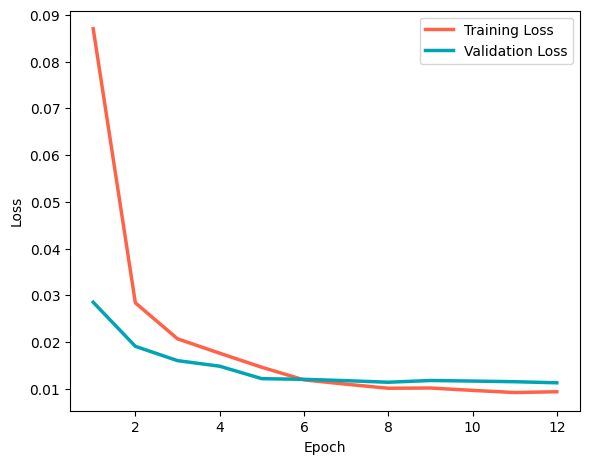

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.053269 	 Validation Loss: 0.013612


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.013385 	 Validation Loss: 0.010648


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.010444 	 Validation Loss: 0.009256


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.006775 	 Validation Loss: 0.012282


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.007743 	 Validation Loss: 0.008737


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.004076 	 Validation Loss: 0.006780


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.003720 	 Validation Loss: 0.006813


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.003412 	 Validation Loss: 0.006475


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 9, Training Loss: 0.003109 	 Validation Loss: 0.006917


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.003251 	 Validation Loss: 0.006437


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 11, Training Loss: 0.002749 	 Validation Loss: 0.006292


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002386 	 Validation Loss: 0.006407
Training finished in 1492.45 seconds
Test Accuracy: 0.9387


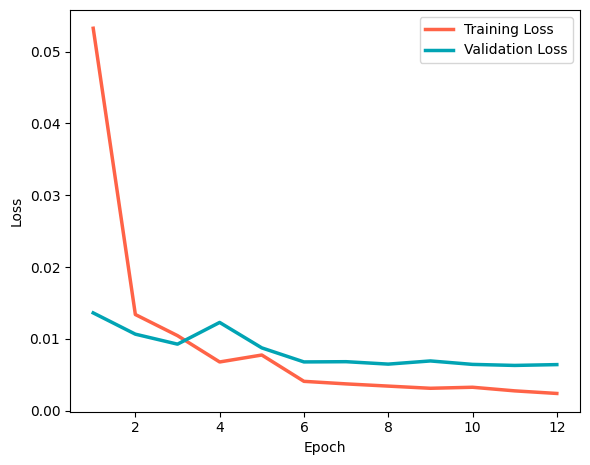

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.086738 	 Validation Loss: 0.031245


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 2, Training Loss: 0.027006 	 Validation Loss: 0.020432


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 3, Training Loss: 0.021243 	 Validation Loss: 0.015880


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.017011 	 Validation Loss: 0.013859


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 5, Training Loss: 0.014943 	 Validation Loss: 0.011246


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 6, Training Loss: 0.011449 	 Validation Loss: 0.010660


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 7, Training Loss: 0.010629 	 Validation Loss: 0.010852


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.010137 	 Validation Loss: 0.010903


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.92batch/s]


Epoch 9, Training Loss: 0.010452 	 Validation Loss: 0.009746


Epoch 10/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


Epoch 10, Training Loss: 0.009391 	 Validation Loss: 0.010084


Epoch 11/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 11, Training Loss: 0.010026 	 Validation Loss: 0.010474


Epoch 12/12: 100%|██████████| 184/184 [01:02<00:00,  2.92batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.009405 	 Validation Loss: 0.009920
Training finished in 885.10 seconds
Test Accuracy: 0.9166


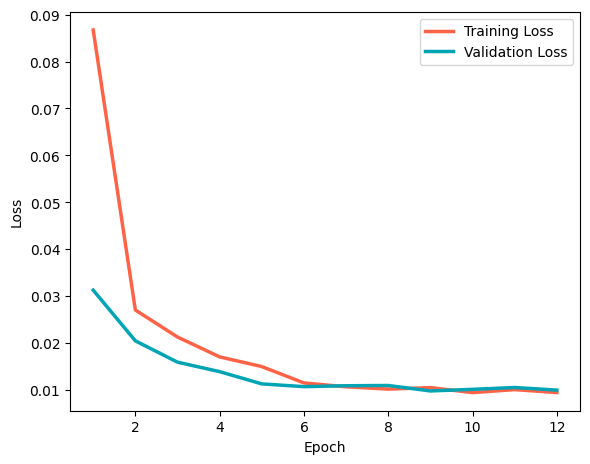

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.053575 	 Validation Loss: 0.014425


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.014836 	 Validation Loss: 0.009898


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.009273 	 Validation Loss: 0.008237


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.007710 	 Validation Loss: 0.007729


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.005814 	 Validation Loss: 0.008796


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.004642 	 Validation Loss: 0.007313


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.003798 	 Validation Loss: 0.007516


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.003655 	 Validation Loss: 0.007181


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.003063 	 Validation Loss: 0.007047


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.002480 	 Validation Loss: 0.007124


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.002810 	 Validation Loss: 0.007142


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002652 	 Validation Loss: 0.007303
Training finished in 1489.49 seconds
Test Accuracy: 0.9406


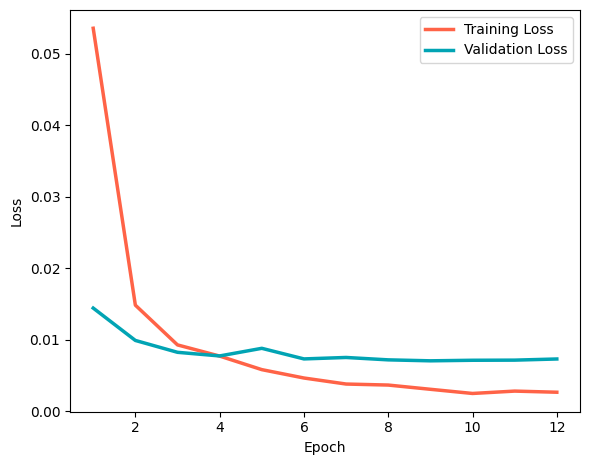

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.089117 	 Validation Loss: 0.032670


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 2, Training Loss: 0.027924 	 Validation Loss: 0.022663


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.021197 	 Validation Loss: 0.018431


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 4, Training Loss: 0.017153 	 Validation Loss: 0.017075


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 5, Training Loss: 0.015395 	 Validation Loss: 0.016150


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.012276 	 Validation Loss: 0.015344


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 7, Training Loss: 0.011716 	 Validation Loss: 0.014703


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 8, Training Loss: 0.011318 	 Validation Loss: 0.014481


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 9, Training Loss: 0.010851 	 Validation Loss: 0.014753


Epoch 10/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 10, Training Loss: 0.010631 	 Validation Loss: 0.014326


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 11, Training Loss: 0.011107 	 Validation Loss: 0.014843


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.010280 	 Validation Loss: 0.015170
Training finished in 872.27 seconds
Test Accuracy: 0.9133


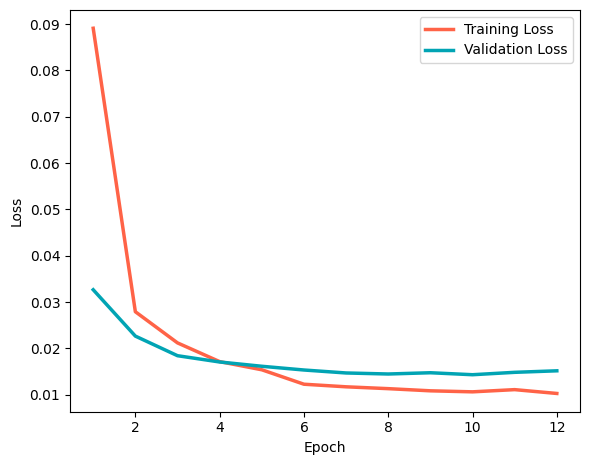

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.056080 	 Validation Loss: 0.012965


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.013891 	 Validation Loss: 0.008660


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.010331 	 Validation Loss: 0.008206


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.008042 	 Validation Loss: 0.007937


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.006331 	 Validation Loss: 0.007021


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.003893 	 Validation Loss: 0.006344


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.003485 	 Validation Loss: 0.006235


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.003071 	 Validation Loss: 0.005525


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.003175 	 Validation Loss: 0.005776


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.002846 	 Validation Loss: 0.005918


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.002317 	 Validation Loss: 0.005755


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002541 	 Validation Loss: 0.005940
Training finished in 1490.28 seconds
Test Accuracy: 0.9359


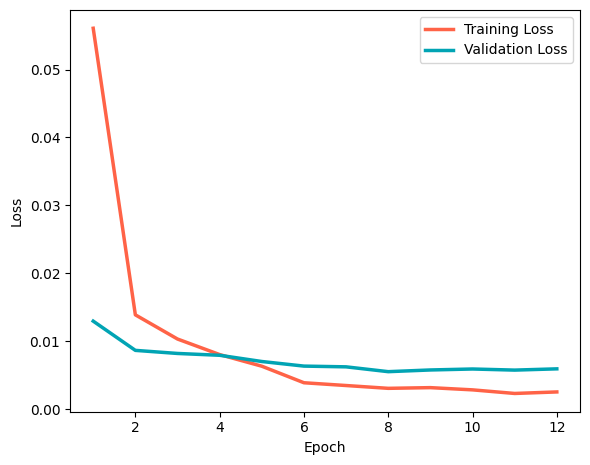

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.087222 	 Validation Loss: 0.029018


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.029341 	 Validation Loss: 0.017636


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 3, Training Loss: 0.021368 	 Validation Loss: 0.013458


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 4, Training Loss: 0.017927 	 Validation Loss: 0.012083


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 5, Training Loss: 0.015283 	 Validation Loss: 0.011198


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.013051 	 Validation Loss: 0.011408


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 7, Training Loss: 0.012448 	 Validation Loss: 0.010709


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 8, Training Loss: 0.011432 	 Validation Loss: 0.010024


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 9, Training Loss: 0.011568 	 Validation Loss: 0.010478


Epoch 10/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 10, Training Loss: 0.011296 	 Validation Loss: 0.009603


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 11, Training Loss: 0.012014 	 Validation Loss: 0.010552


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.011173 	 Validation Loss: 0.010332
Training finished in 875.88 seconds
Test Accuracy: 0.9150


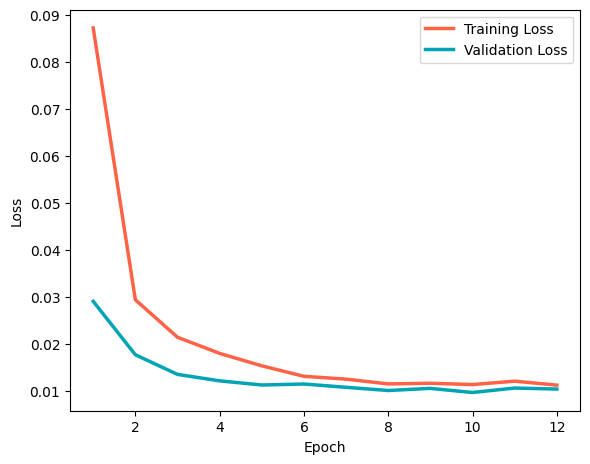

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.053146 	 Validation Loss: 0.013832


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.013756 	 Validation Loss: 0.009172


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.009299 	 Validation Loss: 0.009378


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.007904 	 Validation Loss: 0.009282


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.005611 	 Validation Loss: 0.010161


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.004622 	 Validation Loss: 0.008671


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.003628 	 Validation Loss: 0.008794


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.003094 	 Validation Loss: 0.008087


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.003960 	 Validation Loss: 0.008164


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.002845 	 Validation Loss: 0.008146


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.002657 	 Validation Loss: 0.008406


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.002895 	 Validation Loss: 0.007748
Training finished in 1488.78 seconds
Test Accuracy: 0.9411


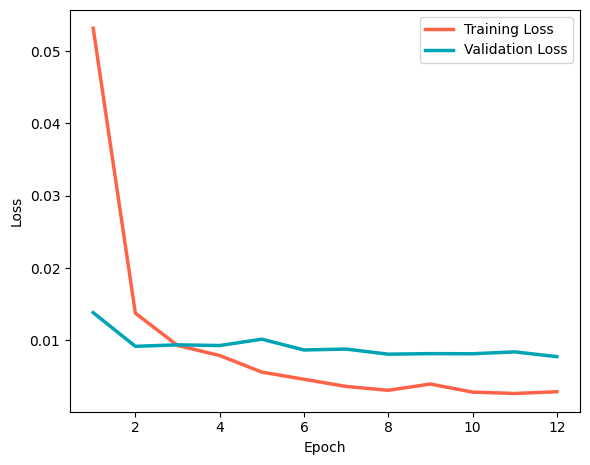

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 6
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.086965 	 Validation Loss: 0.031041


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 2, Training Loss: 0.028644 	 Validation Loss: 0.018783


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.020790 	 Validation Loss: 0.016739


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 4, Training Loss: 0.017149 	 Validation Loss: 0.015887


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 5, Training Loss: 0.015448 	 Validation Loss: 0.013284


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.012086 	 Validation Loss: 0.013526


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 7, Training Loss: 0.012744 	 Validation Loss: 0.012495


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 8, Training Loss: 0.011862 	 Validation Loss: 0.011717


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 9, Training Loss: 0.011358 	 Validation Loss: 0.012069


Epoch 10/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 10, Training Loss: 0.010496 	 Validation Loss: 0.012578


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 11, Training Loss: 0.010930 	 Validation Loss: 0.011780


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.010173 	 Validation Loss: 0.011724
Training finished in 872.01 seconds
Test Accuracy: 0.9136


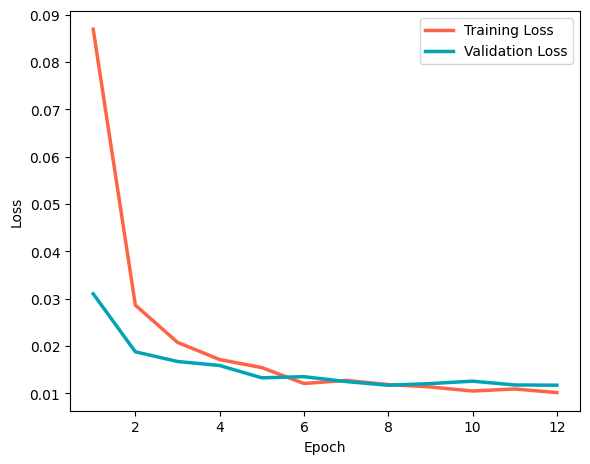

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.125653 	 Validation Loss: 0.026361


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026192 	 Validation Loss: 0.014738


Epoch 3/12: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.017946 	 Validation Loss: 0.012056


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.014640 	 Validation Loss: 0.010324


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012615 	 Validation Loss: 0.009640


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.009909 	 Validation Loss: 0.009347


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.010086 	 Validation Loss: 0.009312


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.008762 	 Validation Loss: 0.008801


Epoch 9/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.008840 	 Validation Loss: 0.008708


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.008801 	 Validation Loss: 0.008690


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.007929 	 Validation Loss: 0.008851


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.007886 	 Validation Loss: 0.008748
Training finished in 1499.65 seconds
Test Accuracy: 0.9384


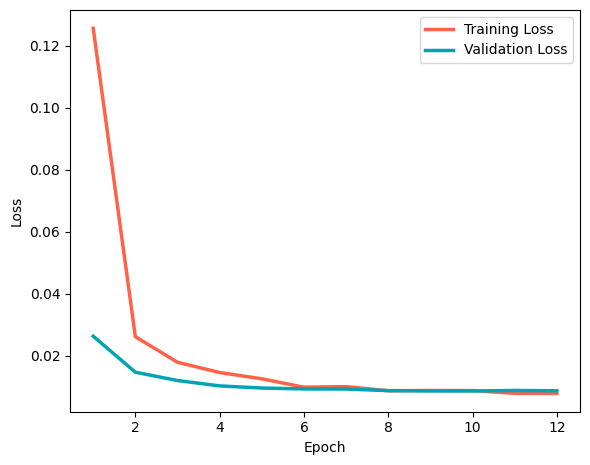

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 1, Training Loss: 0.171969 	 Validation Loss: 0.126114


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.095441 	 Validation Loss: 0.074821


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.060568 	 Validation Loss: 0.050227


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.045407 	 Validation Loss: 0.037395


Epoch 5/12: 100%|██████████| 184/184 [01:01<00:00,  3.02batch/s]


Epoch 5, Training Loss: 0.033750 	 Validation Loss: 0.026599


Epoch 6/12: 100%|██████████| 184/184 [01:01<00:00,  3.00batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.028959 	 Validation Loss: 0.025507


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.92batch/s]


Epoch 7, Training Loss: 0.028133 	 Validation Loss: 0.024320


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.026764 	 Validation Loss: 0.023926


Epoch 9/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


Epoch 9, Training Loss: 0.025830 	 Validation Loss: 0.023503


Epoch 10/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.024158 	 Validation Loss: 0.022308


Epoch 11/12: 100%|██████████| 184/184 [01:05<00:00,  2.82batch/s]


Epoch 11, Training Loss: 0.024000 	 Validation Loss: 0.022030


Epoch 12/12: 100%|██████████| 184/184 [01:05<00:00,  2.83batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.024163 	 Validation Loss: 0.022113
Training finished in 898.53 seconds
Test Accuracy: 0.9103


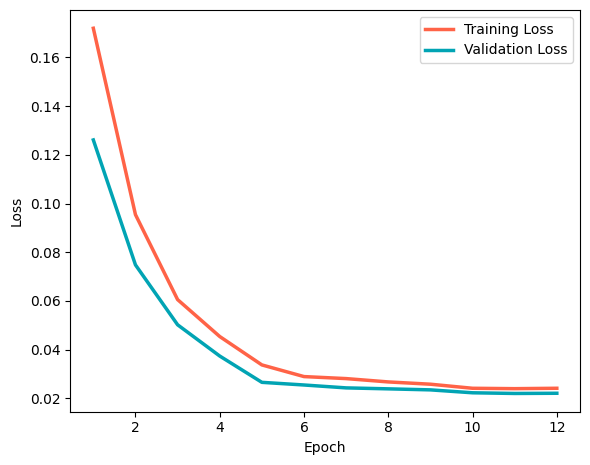

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.127534 	 Validation Loss: 0.023846


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.027480 	 Validation Loss: 0.012634


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.018941 	 Validation Loss: 0.009923


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.015139 	 Validation Loss: 0.008802


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012712 	 Validation Loss: 0.007523


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.010207 	 Validation Loss: 0.006952


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.009656 	 Validation Loss: 0.007197


Epoch 8/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.009843 	 Validation Loss: 0.006762


Epoch 9/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.009422 	 Validation Loss: 0.006767


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.009706 	 Validation Loss: 0.006630


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.008784 	 Validation Loss: 0.006495


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.61batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.009065 	 Validation Loss: 0.006498
Training finished in 1501.20 seconds
Test Accuracy: 0.9343


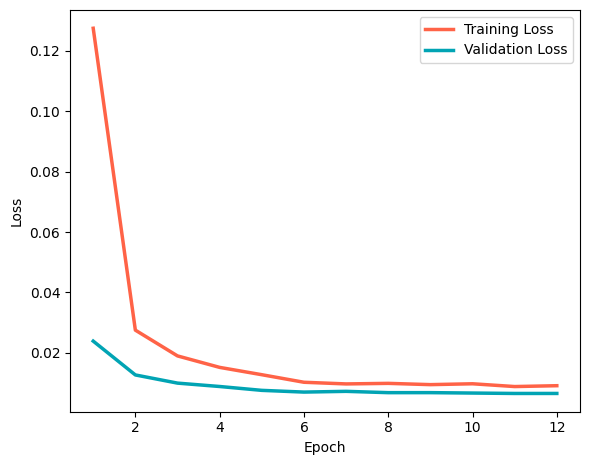

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.172491 	 Validation Loss: 0.125689


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.096102 	 Validation Loss: 0.073737


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 3, Training Loss: 0.061695 	 Validation Loss: 0.049525


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.046536 	 Validation Loss: 0.038093


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 5, Training Loss: 0.033909 	 Validation Loss: 0.026706


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.028744 	 Validation Loss: 0.025631


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 7, Training Loss: 0.027800 	 Validation Loss: 0.024224


Epoch 8/12: 100%|██████████| 184/184 [01:03<00:00,  2.91batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.027414 	 Validation Loss: 0.023454


Epoch 9/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


Epoch 9, Training Loss: 0.025520 	 Validation Loss: 0.022550


Epoch 10/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.025204 	 Validation Loss: 0.021850


Epoch 11/12: 100%|██████████| 184/184 [01:05<00:00,  2.81batch/s]


Epoch 11, Training Loss: 0.024890 	 Validation Loss: 0.021422


Epoch 12/12: 100%|██████████| 184/184 [01:05<00:00,  2.81batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.024112 	 Validation Loss: 0.021700
Training finished in 900.60 seconds
Test Accuracy: 0.9060


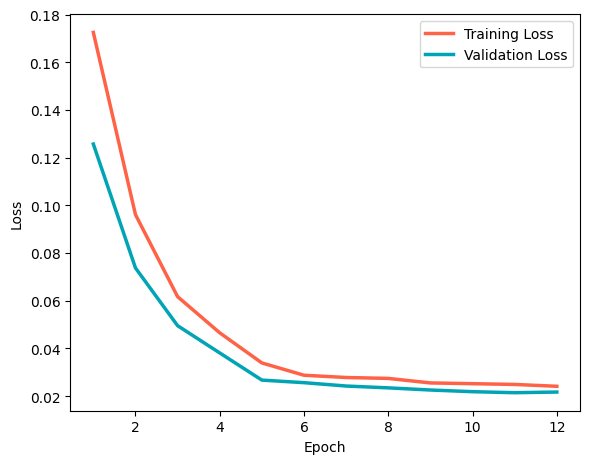

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126907 	 Validation Loss: 0.025884


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026056 	 Validation Loss: 0.012442


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.017107 	 Validation Loss: 0.009635


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.015599 	 Validation Loss: 0.009294


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012301 	 Validation Loss: 0.007518


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.009415 	 Validation Loss: 0.007053


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.009618 	 Validation Loss: 0.006461


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.008920 	 Validation Loss: 0.006613


Epoch 9/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 9, Training Loss: 0.008976 	 Validation Loss: 0.006389


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 10, Training Loss: 0.008337 	 Validation Loss: 0.006179


Epoch 11/12: 100%|██████████| 184/184 [01:54<00:00,  1.61batch/s]


Epoch 11, Training Loss: 0.008701 	 Validation Loss: 0.006014


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008045 	 Validation Loss: 0.006408
Training finished in 1502.55 seconds
Test Accuracy: 0.9351


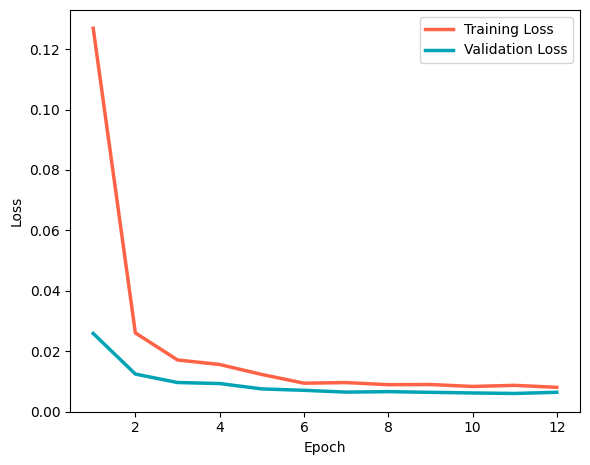

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 2
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.172255 	 Validation Loss: 0.125591


Epoch 2/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 2, Training Loss: 0.094867 	 Validation Loss: 0.072443


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.060292 	 Validation Loss: 0.048265


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.045496 	 Validation Loss: 0.037400


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 5, Training Loss: 0.035416 	 Validation Loss: 0.026196


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.029304 	 Validation Loss: 0.026290


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 7, Training Loss: 0.028153 	 Validation Loss: 0.025325


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.027146 	 Validation Loss: 0.023239


Epoch 9/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


Epoch 9, Training Loss: 0.027534 	 Validation Loss: 0.023089


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 10, Training Loss: 0.025440 	 Validation Loss: 0.021931


Epoch 11/12: 100%|██████████| 184/184 [01:05<00:00,  2.83batch/s]


Epoch 11, Training Loss: 0.024837 	 Validation Loss: 0.021874


Epoch 12/12: 100%|██████████| 184/184 [01:05<00:00,  2.82batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.024678 	 Validation Loss: 0.022267
Training finished in 895.91 seconds
Test Accuracy: 0.9106


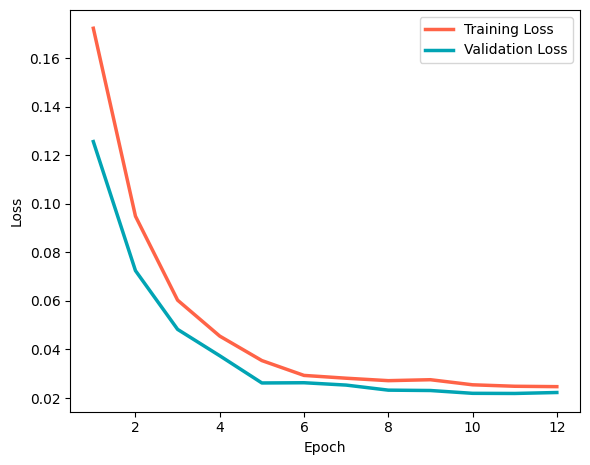

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.127890 	 Validation Loss: 0.026928


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.025433 	 Validation Loss: 0.013391


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.018223 	 Validation Loss: 0.011101


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.013702 	 Validation Loss: 0.009230


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012646 	 Validation Loss: 0.009491


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.010105 	 Validation Loss: 0.008245


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.009722 	 Validation Loss: 0.007813


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.008604 	 Validation Loss: 0.007746


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.009269 	 Validation Loss: 0.007222


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.008674 	 Validation Loss: 0.007025


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.008659 	 Validation Loss: 0.006945


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008113 	 Validation Loss: 0.007599
Training finished in 1499.98 seconds
Test Accuracy: 0.9384


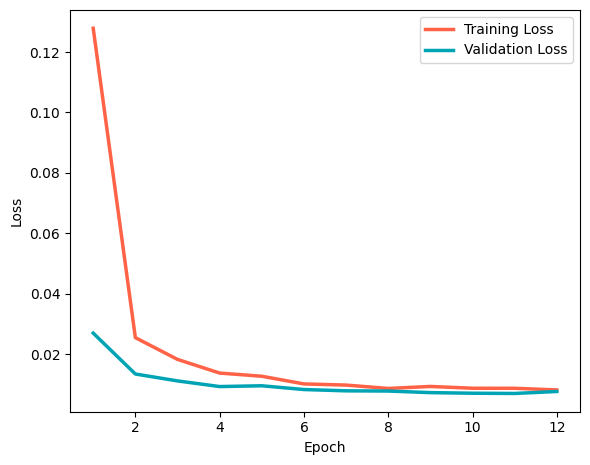

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 1, Training Loss: 0.171315 	 Validation Loss: 0.125476


Epoch 2/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 2, Training Loss: 0.095309 	 Validation Loss: 0.075317


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.059927 	 Validation Loss: 0.049788


Epoch 4/12: 100%|██████████| 184/184 [01:01<00:00,  3.00batch/s]


Epoch 4, Training Loss: 0.040482 	 Validation Loss: 0.031347


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.02batch/s]


Epoch 5, Training Loss: 0.029752 	 Validation Loss: 0.023621


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.025255 	 Validation Loss: 0.022890


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.92batch/s]


Epoch 7, Training Loss: 0.024816 	 Validation Loss: 0.022218


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


Epoch 8, Training Loss: 0.024609 	 Validation Loss: 0.021664


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.023382 	 Validation Loss: 0.021005


Epoch 10/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


Epoch 10, Training Loss: 0.023045 	 Validation Loss: 0.019869


Epoch 11/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


Epoch 11, Training Loss: 0.022619 	 Validation Loss: 0.020107


Epoch 12/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.022750 	 Validation Loss: 0.019943
Training finished in 897.30 seconds
Test Accuracy: 0.9095


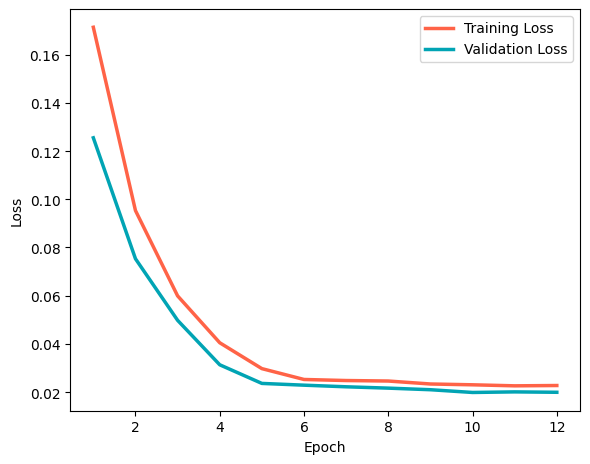

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126702 	 Validation Loss: 0.026520


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.025378 	 Validation Loss: 0.014819


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.018138 	 Validation Loss: 0.011404


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.015368 	 Validation Loss: 0.009747


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012356 	 Validation Loss: 0.008562


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.009682 	 Validation Loss: 0.008303


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.009326 	 Validation Loss: 0.007666


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.008793 	 Validation Loss: 0.007636


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.008979 	 Validation Loss: 0.007196


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 10, Training Loss: 0.008732 	 Validation Loss: 0.007350


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.008117 	 Validation Loss: 0.007218


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008609 	 Validation Loss: 0.007002
Training finished in 1500.86 seconds
Test Accuracy: 0.9370


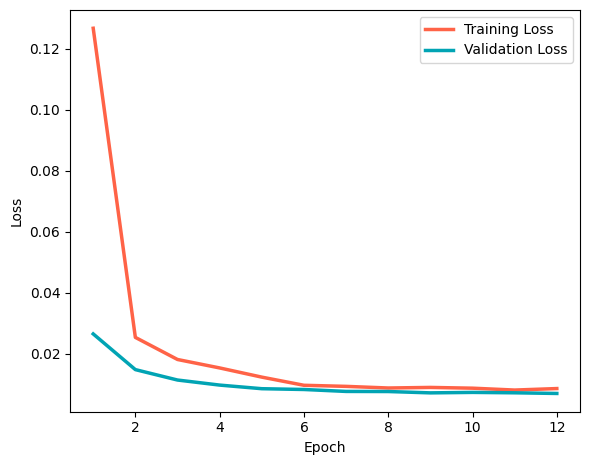

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.171432 	 Validation Loss: 0.128037


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.095482 	 Validation Loss: 0.074857


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.059523 	 Validation Loss: 0.051353


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 4, Training Loss: 0.040987 	 Validation Loss: 0.032653


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 5, Training Loss: 0.029616 	 Validation Loss: 0.025549


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.026048 	 Validation Loss: 0.024072


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 7, Training Loss: 0.026065 	 Validation Loss: 0.024475


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 8, Training Loss: 0.023492 	 Validation Loss: 0.022955


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.023929 	 Validation Loss: 0.023004


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


Epoch 10, Training Loss: 0.022484 	 Validation Loss: 0.022211


Epoch 11/12: 100%|██████████| 184/184 [01:04<00:00,  2.87batch/s]


Epoch 11, Training Loss: 0.022727 	 Validation Loss: 0.021506


Epoch 12/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.022376 	 Validation Loss: 0.021841
Training finished in 892.45 seconds
Test Accuracy: 0.9122


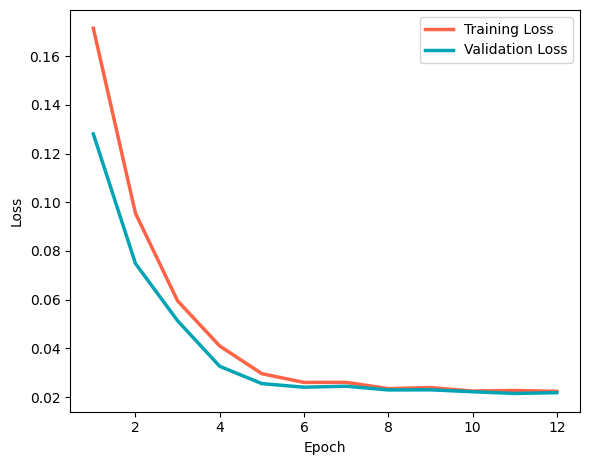

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126695 	 Validation Loss: 0.023856


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026011 	 Validation Loss: 0.012879


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 3, Training Loss: 0.017726 	 Validation Loss: 0.011427


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.013993 	 Validation Loss: 0.010099


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012192 	 Validation Loss: 0.009199


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 6, Training Loss: 0.009234 	 Validation Loss: 0.008345


Epoch 7/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 7, Training Loss: 0.008872 	 Validation Loss: 0.007997


Epoch 8/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 8, Training Loss: 0.008603 	 Validation Loss: 0.008058


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 9, Training Loss: 0.008100 	 Validation Loss: 0.007989


Epoch 10/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.008208 	 Validation Loss: 0.007619


Epoch 11/12: 100%|██████████| 184/184 [01:53<00:00,  1.62batch/s]


Epoch 11, Training Loss: 0.007858 	 Validation Loss: 0.007289


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.007535 	 Validation Loss: 0.007958
Training finished in 1498.61 seconds
Test Accuracy: 0.9351


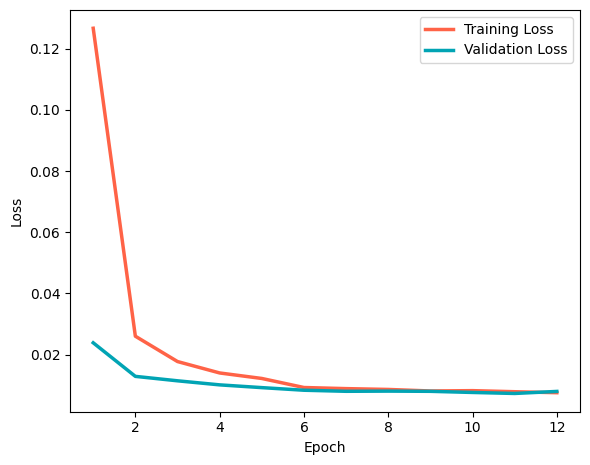

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 3
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.171791 	 Validation Loss: 0.125914


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.095589 	 Validation Loss: 0.075104


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 3, Training Loss: 0.060792 	 Validation Loss: 0.050886


Epoch 4/12: 100%|██████████| 184/184 [01:01<00:00,  3.01batch/s]


Epoch 4, Training Loss: 0.041408 	 Validation Loss: 0.030444


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 5, Training Loss: 0.029986 	 Validation Loss: 0.023879


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 6, Training Loss: 0.025776 	 Validation Loss: 0.022542


Epoch 7/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


Epoch 7, Training Loss: 0.025108 	 Validation Loss: 0.022777


Epoch 8/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 8, Training Loss: 0.023851 	 Validation Loss: 0.020853


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 9, Training Loss: 0.023363 	 Validation Loss: 0.020893


Epoch 10/12: 100%|██████████| 184/184 [01:03<00:00,  2.88batch/s]


Epoch 10, Training Loss: 0.023496 	 Validation Loss: 0.020046


Epoch 11/12: 100%|██████████| 184/184 [01:04<00:00,  2.86batch/s]


Epoch 11, Training Loss: 0.022169 	 Validation Loss: 0.019637


Epoch 12/12: 100%|██████████| 184/184 [01:04<00:00,  2.85batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.022393 	 Validation Loss: 0.019579
Training finished in 896.11 seconds
Test Accuracy: 0.9117


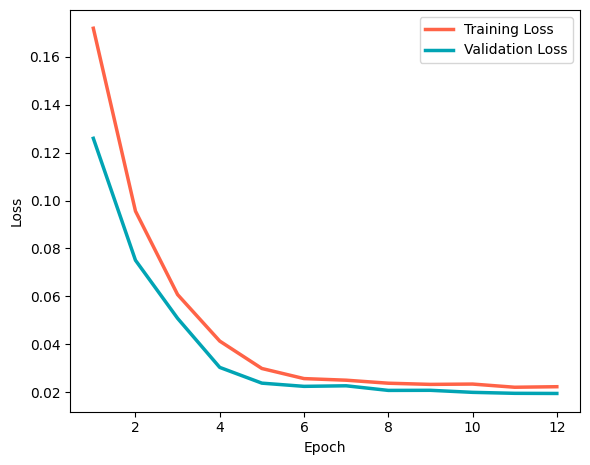

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126879 	 Validation Loss: 0.024274


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026786 	 Validation Loss: 0.013328


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.020053 	 Validation Loss: 0.010590


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.015412 	 Validation Loss: 0.008835


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.014240 	 Validation Loss: 0.008012


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.010051 	 Validation Loss: 0.007537


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009901 	 Validation Loss: 0.007254


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.008933 	 Validation Loss: 0.007034


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.009899 	 Validation Loss: 0.006796


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.009045 	 Validation Loss: 0.006902


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.008815 	 Validation Loss: 0.006937


Epoch 12/12: 100%|██████████| 184/184 [01:53<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.009111 	 Validation Loss: 0.006994
Training finished in 1497.01 seconds
Test Accuracy: 0.9357


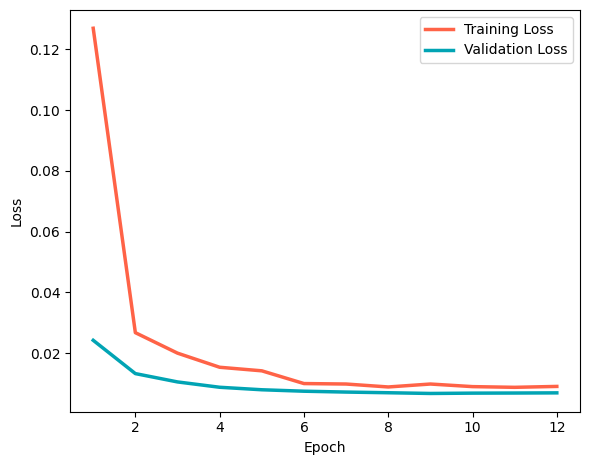

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.171830 	 Validation Loss: 0.124937


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.095106 	 Validation Loss: 0.072457


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 3, Training Loss: 0.061269 	 Validation Loss: 0.049813


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.045811 	 Validation Loss: 0.036374


Epoch 5/12: 100%|██████████| 184/184 [01:01<00:00,  3.00batch/s]


Epoch 5, Training Loss: 0.034339 	 Validation Loss: 0.026435


Epoch 6/12: 100%|██████████| 184/184 [01:01<00:00,  3.01batch/s]


Epoch 6, Training Loss: 0.029660 	 Validation Loss: 0.026825


Epoch 7/12: 100%|██████████| 184/184 [01:01<00:00,  3.00batch/s]


Epoch 7, Training Loss: 0.028155 	 Validation Loss: 0.024839


Epoch 8/12: 100%|██████████| 184/184 [01:01<00:00,  3.01batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.027909 	 Validation Loss: 0.024250


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.92batch/s]


Epoch 9, Training Loss: 0.026703 	 Validation Loss: 0.023578


Epoch 10/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


Epoch 10, Training Loss: 0.025463 	 Validation Loss: 0.022307


Epoch 11/12: 100%|██████████| 184/184 [01:03<00:00,  2.92batch/s]


Epoch 11, Training Loss: 0.025278 	 Validation Loss: 0.023042


Epoch 12/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.025266 	 Validation Loss: 0.022190
Training finished in 890.93 seconds
Test Accuracy: 0.9103


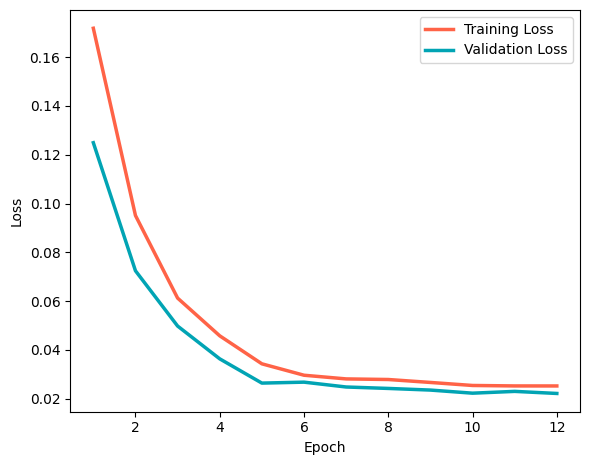

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126286 	 Validation Loss: 0.024639


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026027 	 Validation Loss: 0.012596


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.017725 	 Validation Loss: 0.011117


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.015719 	 Validation Loss: 0.011388


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012988 	 Validation Loss: 0.009254


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.009943 	 Validation Loss: 0.008288


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009388 	 Validation Loss: 0.008037


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.008878 	 Validation Loss: 0.007930


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.008719 	 Validation Loss: 0.007809


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


Epoch 10, Training Loss: 0.008510 	 Validation Loss: 0.007966


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.008251 	 Validation Loss: 0.007825


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008464 	 Validation Loss: 0.007777
Training finished in 1496.34 seconds
Test Accuracy: 0.9357


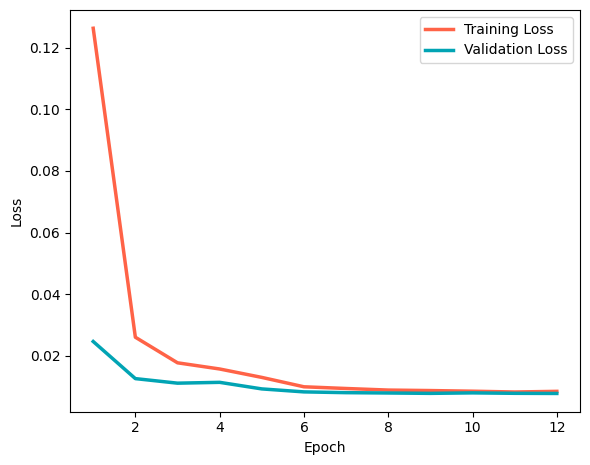

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 1, Training Loss: 0.171839 	 Validation Loss: 0.124228


Epoch 2/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 2, Training Loss: 0.095004 	 Validation Loss: 0.072862


Epoch 3/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 3, Training Loss: 0.062078 	 Validation Loss: 0.049287


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.046069 	 Validation Loss: 0.036718


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 5, Training Loss: 0.034403 	 Validation Loss: 0.027036


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 6, Training Loss: 0.029505 	 Validation Loss: 0.025260


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 7, Training Loss: 0.027990 	 Validation Loss: 0.023992


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.027611 	 Validation Loss: 0.023517


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


Epoch 9, Training Loss: 0.026748 	 Validation Loss: 0.022944


Epoch 10/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 10, Training Loss: 0.026085 	 Validation Loss: 0.022813


Epoch 11/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 11, Training Loss: 0.024847 	 Validation Loss: 0.022301


Epoch 12/12: 100%|██████████| 184/184 [01:02<00:00,  2.93batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.025338 	 Validation Loss: 0.022368
Training finished in 886.09 seconds
Test Accuracy: 0.9073


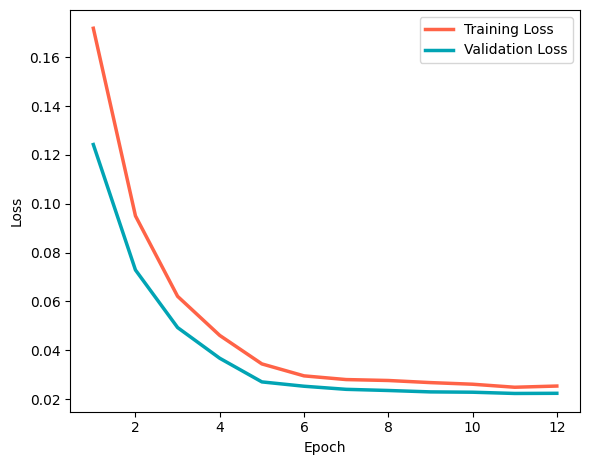

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.127089 	 Validation Loss: 0.025896


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.026108 	 Validation Loss: 0.013403


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.018226 	 Validation Loss: 0.011157


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 4, Training Loss: 0.015156 	 Validation Loss: 0.009582


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.011694 	 Validation Loss: 0.008141


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.009453 	 Validation Loss: 0.007606


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009094 	 Validation Loss: 0.007279


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 8, Training Loss: 0.008754 	 Validation Loss: 0.007692


Epoch 9/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 9, Training Loss: 0.008394 	 Validation Loss: 0.007191


Epoch 10/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 10, Training Loss: 0.007810 	 Validation Loss: 0.006910


Epoch 11/12: 100%|██████████| 184/184 [01:52<00:00,  1.63batch/s]


Epoch 11, Training Loss: 0.008784 	 Validation Loss: 0.006644


Epoch 12/12: 100%|██████████| 184/184 [01:52<00:00,  1.64batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.007867 	 Validation Loss: 0.006865
Training finished in 1494.55 seconds
Test Accuracy: 0.9354


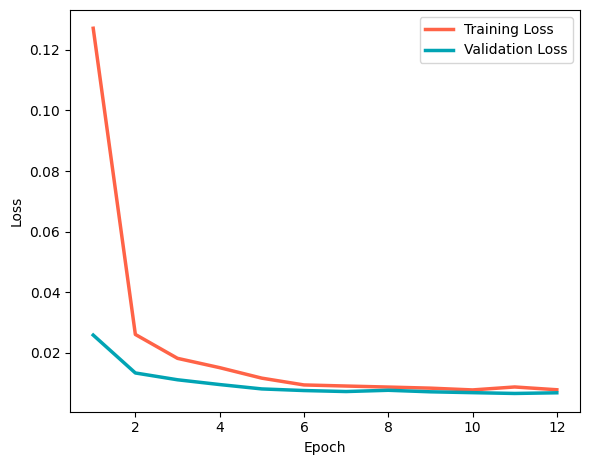

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 4
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.172812 	 Validation Loss: 0.124368


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 2, Training Loss: 0.095513 	 Validation Loss: 0.072129


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.061664 	 Validation Loss: 0.048638


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 4, Training Loss: 0.046367 	 Validation Loss: 0.036839


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 5, Training Loss: 0.034514 	 Validation Loss: 0.024044


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 6, Training Loss: 0.029277 	 Validation Loss: 0.024039


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 7, Training Loss: 0.028579 	 Validation Loss: 0.023390


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 8, Training Loss: 0.027440 	 Validation Loss: 0.022940


Epoch 9/12: 100%|██████████| 184/184 [01:02<00:00,  2.94batch/s]


Epoch 9, Training Loss: 0.026907 	 Validation Loss: 0.021513


Epoch 10/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 10, Training Loss: 0.026010 	 Validation Loss: 0.021075


Epoch 11/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


Epoch 11, Training Loss: 0.025544 	 Validation Loss: 0.021220


Epoch 12/12: 100%|██████████| 184/184 [01:02<00:00,  2.95batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.026048 	 Validation Loss: 0.021595
Training finished in 883.92 seconds
Test Accuracy: 0.9079


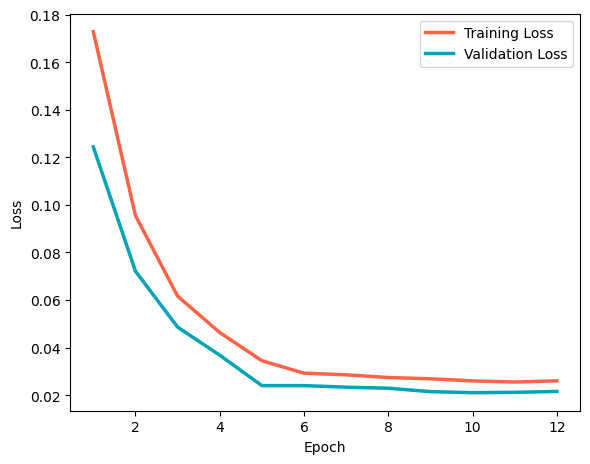

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.126326 	 Validation Loss: 0.027029


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.025734 	 Validation Loss: 0.015558


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.016884 	 Validation Loss: 0.012729


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.014429 	 Validation Loss: 0.011054


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012586 	 Validation Loss: 0.011233


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.010098 	 Validation Loss: 0.009460


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009684 	 Validation Loss: 0.009481


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.009242 	 Validation Loss: 0.009468


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.008902 	 Validation Loss: 0.008866


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.008880 	 Validation Loss: 0.009186


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.008779 	 Validation Loss: 0.008719


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008151 	 Validation Loss: 0.009247
Training finished in 1488.14 seconds
Test Accuracy: 0.9359


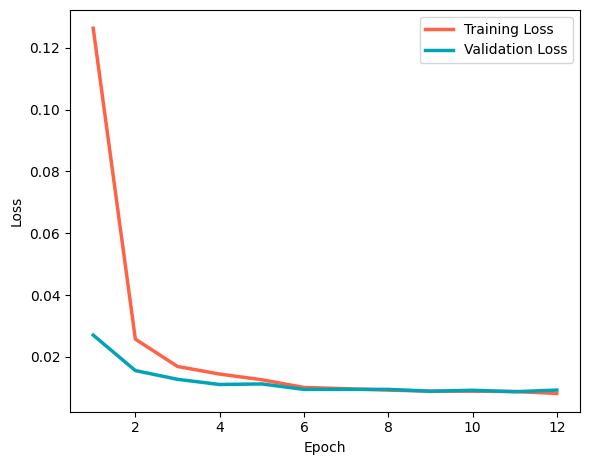

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 4
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.172380 	 Validation Loss: 0.126842


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 2, Training Loss: 0.096024 	 Validation Loss: 0.071754


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.061112 	 Validation Loss: 0.048340


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.09batch/s]


Epoch 4, Training Loss: 0.045773 	 Validation Loss: 0.038798


Epoch 5/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 5, Training Loss: 0.036979 	 Validation Loss: 0.031131


Epoch 6/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.033611 	 Validation Loss: 0.031251


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 7, Training Loss: 0.033139 	 Validation Loss: 0.028738


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 8, Training Loss: 0.031311 	 Validation Loss: 0.028312


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 9, Training Loss: 0.029804 	 Validation Loss: 0.026598


Epoch 10/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 10, Training Loss: 0.029332 	 Validation Loss: 0.026370


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 11, Training Loss: 0.029569 	 Validation Loss: 0.026011


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.029106 	 Validation Loss: 0.025975
Training finished in 876.33 seconds
Test Accuracy: 0.9057


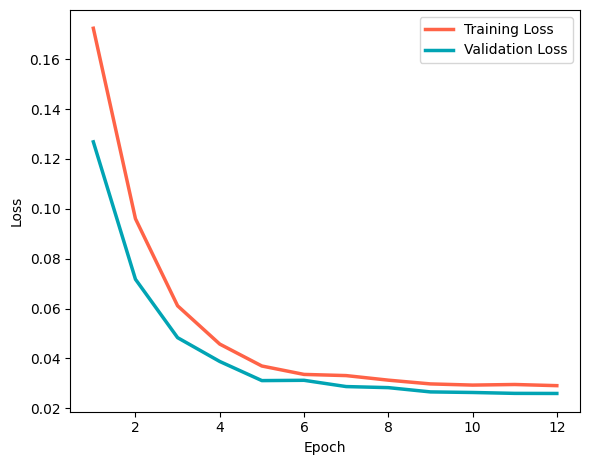

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.126741 	 Validation Loss: 0.025256


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.025461 	 Validation Loss: 0.012939


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.018190 	 Validation Loss: 0.010186


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.015044 	 Validation Loss: 0.009809


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012342 	 Validation Loss: 0.007806


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.009981 	 Validation Loss: 0.007004


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009329 	 Validation Loss: 0.007203


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.009532 	 Validation Loss: 0.007080


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.008198 	 Validation Loss: 0.006652


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.008565 	 Validation Loss: 0.006785


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.008225 	 Validation Loss: 0.006864


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.009110 	 Validation Loss: 0.006684
Training finished in 1490.74 seconds
Test Accuracy: 0.9365


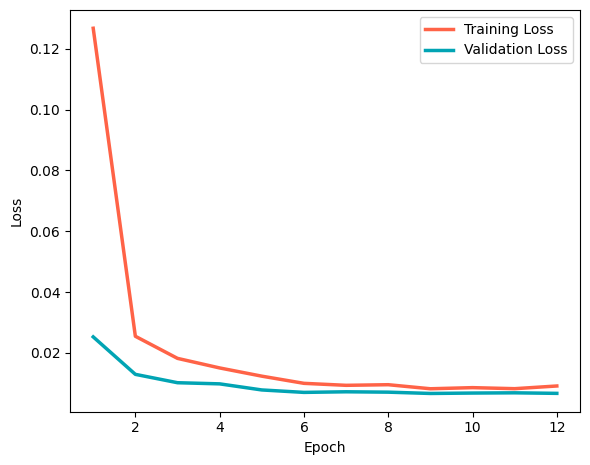

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 6
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 1, Training Loss: 0.172454 	 Validation Loss: 0.125240


Epoch 2/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 2, Training Loss: 0.095745 	 Validation Loss: 0.074107


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.061435 	 Validation Loss: 0.049860


Epoch 4/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 4, Training Loss: 0.045852 	 Validation Loss: 0.038919


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 5, Training Loss: 0.037215 	 Validation Loss: 0.031248


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.033369 	 Validation Loss: 0.030925


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 7, Training Loss: 0.033116 	 Validation Loss: 0.030128


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 8, Training Loss: 0.031723 	 Validation Loss: 0.028708


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 9, Training Loss: 0.030968 	 Validation Loss: 0.028478


Epoch 10/12: 100%|██████████| 184/184 [01:00<00:00,  3.03batch/s]


Epoch 10, Training Loss: 0.029995 	 Validation Loss: 0.026458


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.05batch/s]


Epoch 11, Training Loss: 0.029587 	 Validation Loss: 0.027382


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.028954 	 Validation Loss: 0.027354
Training finished in 876.85 seconds
Test Accuracy: 0.9057


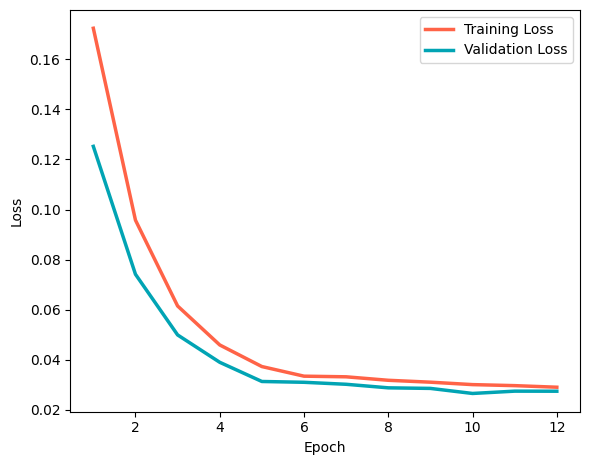

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 8
  Training Mode: 2
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.127363 	 Validation Loss: 0.030631


Epoch 2/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.026627 	 Validation Loss: 0.013849


Epoch 3/12: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.017512 	 Validation Loss: 0.011357


Epoch 4/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.015735 	 Validation Loss: 0.009431


Epoch 5/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.012753 	 Validation Loss: 0.008652


Epoch 6/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.weight False
1.weight True
1.bias True
Epoch 6, Training Loss: 0.010683 	 Validation Loss: 0.007877


Epoch 7/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 7, Training Loss: 0.009899 	 Validation Loss: 0.007560


Epoch 8/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 8, Training Loss: 0.008863 	 Validation Loss: 0.007342


Epoch 9/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 9, Training Loss: 0.008947 	 Validation Loss: 0.007571


Epoch 10/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.009073 	 Validation Loss: 0.007230


Epoch 11/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.009094 	 Validation Loss: 0.007287


Epoch 12/12: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


0.0.weight False
0.1.weight True
0.1.bias True
1.0.weight False
1.1.weight True
1.1.bias True
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight True
3.1.bias True
Epoch 12, Training Loss: 0.008902 	 Validation Loss: 0.006997
Training finished in 1489.73 seconds
Test Accuracy: 0.9376


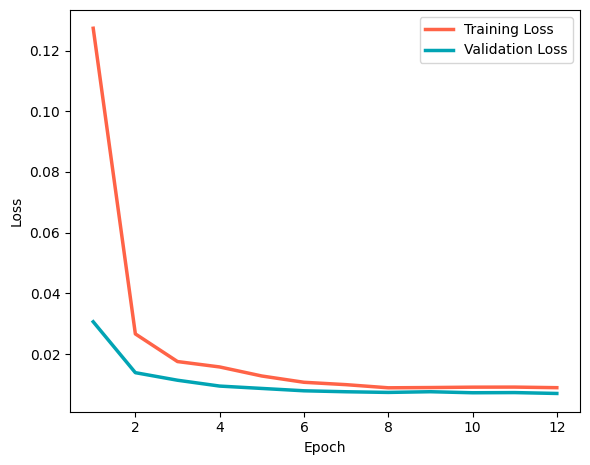

----------------------------------------
Training with parameters:
  Learning Rate: 0.001
  Unfreeze Interval: 6
  Reduce Learning Rate: 8
  Training Mode: 3
Using gpu: True 


Epoch 1/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 1, Training Loss: 0.172853 	 Validation Loss: 0.126046


Epoch 2/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 2, Training Loss: 0.095775 	 Validation Loss: 0.073286


Epoch 3/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


Epoch 3, Training Loss: 0.061167 	 Validation Loss: 0.049522


Epoch 4/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 4, Training Loss: 0.045559 	 Validation Loss: 0.036952


Epoch 5/12: 100%|██████████| 184/184 [00:59<00:00,  3.07batch/s]


Epoch 5, Training Loss: 0.036916 	 Validation Loss: 0.031013


Epoch 6/12: 100%|██████████| 184/184 [00:59<00:00,  3.08batch/s]


0.weight False
1.weight False
1.bias False
Epoch 6, Training Loss: 0.033497 	 Validation Loss: 0.030645


Epoch 7/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 7, Training Loss: 0.032001 	 Validation Loss: 0.029469


Epoch 8/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 8, Training Loss: 0.030438 	 Validation Loss: 0.027694


Epoch 9/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


Epoch 9, Training Loss: 0.030445 	 Validation Loss: 0.026441


Epoch 10/12: 100%|██████████| 184/184 [01:00<00:00,  3.04batch/s]


Epoch 10, Training Loss: 0.029163 	 Validation Loss: 0.025998


Epoch 11/12: 100%|██████████| 184/184 [01:00<00:00,  3.07batch/s]


Epoch 11, Training Loss: 0.029317 	 Validation Loss: 0.025833


Epoch 12/12: 100%|██████████| 184/184 [01:00<00:00,  3.06batch/s]


0.0.weight False
0.1.weight False
0.1.bias False
1.0.weight False
1.1.weight False
1.1.bias False
2.fc1.weight False
2.fc1.bias False
2.fc2.weight False
2.fc2.bias False
3.0.weight False
3.1.weight False
3.1.bias False
Epoch 12, Training Loss: 0.028923 	 Validation Loss: 0.026089
Training finished in 874.28 seconds
Test Accuracy: 0.9084


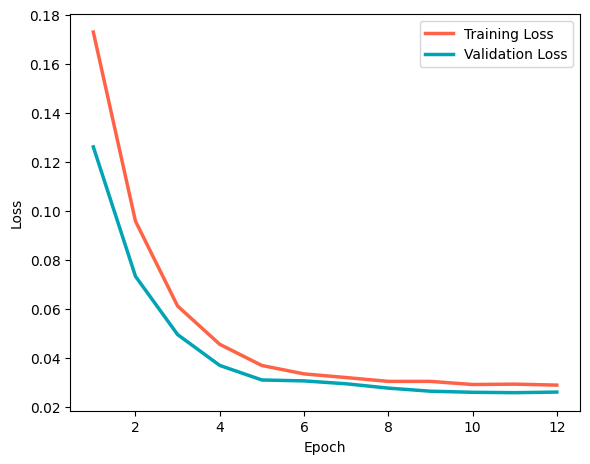

----------------------------------------


In [ ]:
lr_list = [5e-3, 1e-3]
unfreeze_interval_list = [2, 3, 4, 6]
reduce_learning_rate_list = [4, 6, 8]
training_mode_list = [2]

for lr in lr_list:
    for unfreeze_interval in unfreeze_interval_list:
        for reduce_learning_rate in reduce_learning_rate_list:
            for training_mode in training_mode_list:
                print(f"Training with parameters:")
                print(f"  Learning Rate: {lr}")
                print(f"  Unfreeze Interval: {unfreeze_interval}")
                print(f"  Reduce Learning Rate: {reduce_learning_rate}")
                print(f"  Training Mode: {training_mode}")
                train = Train(lr=lr, bs=16, epochs=16, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
                train.train()
                train.evaluate()
                train.plot_loss_curves()
                print("-" * 40)



Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 1, Training Loss: 0.055318 	 Validation Loss: 0.013763


Epoch 2/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.014383 	 Validation Loss: 0.012217


Epoch 3/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.010593 	 Validation Loss: 0.008417


Epoch 4/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.007023 	 Validation Loss: 0.010138


Epoch 5/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 5, Training Loss: 0.006680 	 Validation Loss: 0.008611


Epoch 6/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 6, Training Loss: 0.005579 	 Validation Loss: 0.010476
Test Accuracy: 0.9234


Epoch 7/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 7, Training Loss: 0.000953 	 Validation Loss: 0.008900


Epoch 8/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 8, Training Loss: 0.003790 	 Validation Loss: 0.007564


Epoch 9/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 9, Training Loss: 0.003307 	 Validation Loss: 0.007854


Epoch 10/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 10, Training Loss: 0.003306 	 Validation Loss: 0.008142


Epoch 11/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 11, Training Loss: 0.003022 	 Validation Loss: 0.007976


Epoch 12/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 12, Training Loss: 0.002707 	 Validation Loss: 0.007386
Test Accuracy: 0.9392


Epoch 13/24: 100%|██████████| 184/184 [01:44<00:00,  1.75batch/s]


Epoch 13, Training Loss: 0.000455 	 Validation Loss: 0.007320


Epoch 14/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 14, Training Loss: 0.002475 	 Validation Loss: 0.007435


Epoch 15/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 15, Training Loss: 0.002413 	 Validation Loss: 0.007384


Epoch 16/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 16, Training Loss: 0.002264 	 Validation Loss: 0.007214


Epoch 17/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 17, Training Loss: 0.002719 	 Validation Loss: 0.006939


Epoch 18/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 18, Training Loss: 0.002594 	 Validation Loss: 0.007748
Test Accuracy: 0.9392


Epoch 19/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 19, Training Loss: 0.000593 	 Validation Loss: 0.007718


Epoch 20/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 20, Training Loss: 0.002360 	 Validation Loss: 0.007362


Epoch 21/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 21, Training Loss: 0.002150 	 Validation Loss: 0.007266


Epoch 22/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 22, Training Loss: 0.002314 	 Validation Loss: 0.007272


Epoch 23/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 23, Training Loss: 0.002190 	 Validation Loss: 0.007385


Epoch 24/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 24, Training Loss: 0.002343 	 Validation Loss: 0.007263
Test Accuracy: 0.9365
Training finished in 3212.98 seconds
Test Accuracy: 0.9365


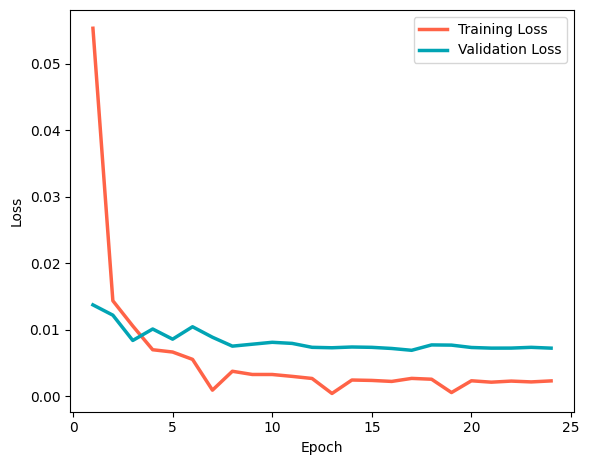

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 4
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.054961 	 Validation Loss: 0.014775


Epoch 2/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 2, Training Loss: 0.013696 	 Validation Loss: 0.010763


Epoch 3/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 3, Training Loss: 0.009892 	 Validation Loss: 0.013799


Epoch 4/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.007175 	 Validation Loss: 0.011450
Test Accuracy: 0.9321


Epoch 5/24: 100%|██████████| 184/184 [01:44<00:00,  1.75batch/s]


Epoch 5, Training Loss: 0.001768 	 Validation Loss: 0.010562


Epoch 6/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 6, Training Loss: 0.004554 	 Validation Loss: 0.009336


Epoch 7/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 7, Training Loss: 0.004214 	 Validation Loss: 0.009153


Epoch 8/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 8, Training Loss: 0.003658 	 Validation Loss: 0.009744
Test Accuracy: 0.9395


Epoch 9/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 9, Training Loss: 0.000995 	 Validation Loss: 0.009742


Epoch 10/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 10, Training Loss: 0.002866 	 Validation Loss: 0.009016


Epoch 11/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 11, Training Loss: 0.003483 	 Validation Loss: 0.009291


Epoch 12/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 12, Training Loss: 0.003319 	 Validation Loss: 0.008989
Test Accuracy: 0.9403


Epoch 13/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 13, Training Loss: 0.000886 	 Validation Loss: 0.008976


Epoch 14/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 14, Training Loss: 0.003515 	 Validation Loss: 0.009181


Epoch 15/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 15, Training Loss: 0.003610 	 Validation Loss: 0.009359


Epoch 16/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 16, Training Loss: 0.003448 	 Validation Loss: 0.009489
Test Accuracy: 0.9414


Epoch 17/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 17, Training Loss: 0.000885 	 Validation Loss: 0.009487


Epoch 18/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 18, Training Loss: 0.003579 	 Validation Loss: 0.008968


Epoch 19/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 19, Training Loss: 0.002852 	 Validation Loss: 0.009309


Epoch 20/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 20, Training Loss: 0.003692 	 Validation Loss: 0.009247
Test Accuracy: 0.9414


Epoch 21/24: 100%|██████████| 184/184 [01:44<00:00,  1.77batch/s]


Epoch 21, Training Loss: 0.000911 	 Validation Loss: 0.009247


Epoch 22/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 22, Training Loss: 0.003036 	 Validation Loss: 0.009192


Epoch 23/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 23, Training Loss: 0.003398 	 Validation Loss: 0.009135


Epoch 24/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 24, Training Loss: 0.003696 	 Validation Loss: 0.009087
Test Accuracy: 0.9411
Training finished in 3319.77 seconds
Test Accuracy: 0.9411


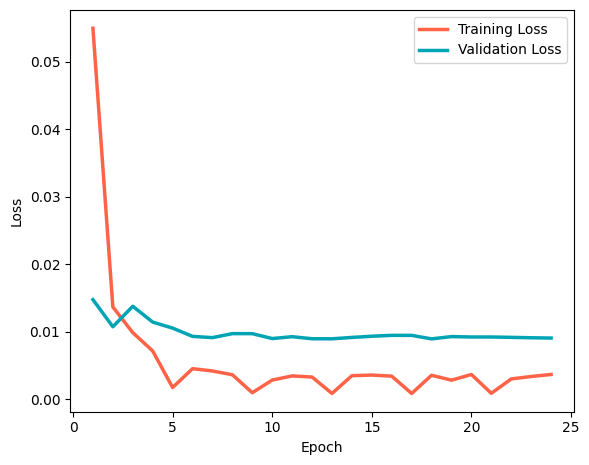

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 2
  Reduce Learning Rate: 5
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.054743 	 Validation Loss: 0.013599


Epoch 2/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.014552 	 Validation Loss: 0.009899


Epoch 3/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.009298 	 Validation Loss: 0.008354


Epoch 4/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 4, Training Loss: 0.007580 	 Validation Loss: 0.009315


Epoch 5/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.005353 	 Validation Loss: 0.007783
Test Accuracy: 0.9305


Epoch 6/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 6, Training Loss: 0.001158 	 Validation Loss: 0.007743


Epoch 7/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 7, Training Loss: 0.003895 	 Validation Loss: 0.007236


Epoch 8/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 8, Training Loss: 0.003253 	 Validation Loss: 0.007155


Epoch 9/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 9, Training Loss: 0.003009 	 Validation Loss: 0.006700


Epoch 10/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 10, Training Loss: 0.002976 	 Validation Loss: 0.006748
Test Accuracy: 0.9414


Epoch 11/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 11, Training Loss: 0.000645 	 Validation Loss: 0.006873


Epoch 12/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 12, Training Loss: 0.002293 	 Validation Loss: 0.006820


Epoch 13/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 13, Training Loss: 0.002857 	 Validation Loss: 0.006893


Epoch 14/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 14, Training Loss: 0.002512 	 Validation Loss: 0.007208


Epoch 15/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 15, Training Loss: 0.002612 	 Validation Loss: 0.006756
Test Accuracy: 0.9419


Epoch 16/24: 100%|██████████| 184/184 [01:44<00:00,  1.76batch/s]


Epoch 16, Training Loss: 0.000586 	 Validation Loss: 0.006748


Epoch 17/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 17, Training Loss: 0.002788 	 Validation Loss: 0.007030


Epoch 18/24: 100%|██████████| 184/184 [01:51<00:00,  1.65batch/s]


Epoch 18, Training Loss: 0.002841 	 Validation Loss: 0.006827


Epoch 19/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 19, Training Loss: 0.0026 	 Validation Loss: 0.0067. Early stopping triggered
Training finished in 2522.09 seconds
Test Accuracy: 0.9414


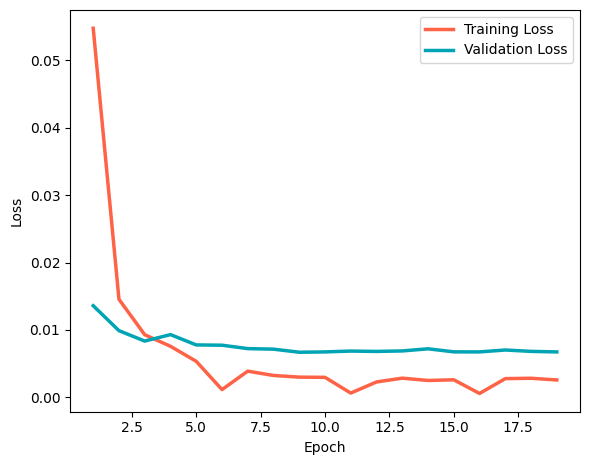

----------------------------------------
Training with parameters:
  Learning Rate: 0.005
  Unfreeze Interval: 4
  Reduce Learning Rate: 6
  Training Mode: 1
Using gpu: True 


Epoch 1/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 1, Training Loss: 0.055333 	 Validation Loss: 0.012303


Epoch 2/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 2, Training Loss: 0.015264 	 Validation Loss: 0.010884


Epoch 3/24: 100%|██████████| 184/184 [01:50<00:00,  1.66batch/s]


Epoch 3, Training Loss: 0.009898 	 Validation Loss: 0.007629


Epoch 4/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 4, Training Loss: 0.007494 	 Validation Loss: 0.010013


Epoch 5/24: 100%|██████████| 184/184 [01:51<00:00,  1.66batch/s]


Epoch 5, Training Loss: 0.006247 	 Validation Loss: 0.009923


Epoch 6/24:  30%|██▉       | 55/184 [00:33<01:18,  1.65batch/s]


KeyboardInterrupt: 

In [ ]:
testing = [(0.005, 2, 6, 1), (0.005, 2, 4, 1), (0.005, 2, 5, 1),
           (0.005, 4, 6, 1), (0.005, 6, 8, 2), (0.005, 4, 8, 1),
           (0.005, 4, 5, 2), (0.005, 3, 8, 1), (0.005, 6, 5, 2)]


for lr, unfreeze_interval, reduce_learning_rate, training_mode in testing:
    print(f"Training with parameters:")
    print(f"  Learning Rate: {lr}")
    print(f"  Unfreeze Interval: {unfreeze_interval}")
    print(f"  Reduce Learning Rate: {reduce_learning_rate}")
    print(f"  Training Mode: {training_mode}")
    train = Train(lr=lr, bs=16, epochs=24, split_ratio=0.8, model=None, unfreeze_interval=unfreeze_interval, _LoadData=_LoadData, change_of_learning_rate=10, reduce_learning_rate=reduce_learning_rate, training_mode=training_mode)
    train.train()
    train.evaluate()
    train.plot_loss_curves()
    print("-" * 40)

